# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


CASE 1
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8,(8*1*1*768)] =>
    => 2 GRU((6144,512)|dropout(0.5)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]

CASE 2
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8*8,(1*1*768)] =>
    => 2 GRU((768,512)|drop_out(0.3)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]
    


# Code (w/ lib) 

Add sanity check when init to see if folders and custom methods are created

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  GRU: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  GRU: GRU (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set path_labels: partA/starting_point/test_23.csv
Start training phase the model at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541
 list_splits_idxs [array([ 2,  3,  5,  9, 15, 21]), array([ 0,  1,  4,  6,  7,  8, 11, 12, 13, 16, 17, 20]), array([10, 14, 18, 19, 22])]
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k0_cross_val/test.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k0_cross_val/val.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k0_cross_val/train.csv
training using validation set
Extracting features...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k0_cross_val/train.csv
Loading features from SSD...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0.6666666666666666  GPU free/total (GB) : 2.08/3.71

1.0  GPU free/total (GB) : 2.08/3.71

Epoch [1/5] | 2024-12-12 17:45:45
 Train
  Loss             : 3.2548 
  Loss per_class   : [0.         3.45529413 3.38312817 5.02172422]
 Test
  Loss: 1.5730 
  Loss per_class   : [1.2227727  2.85356963 3.0966233  4.88033545]
0.3333333333333333  GPU free/total (GB) : 2.08/3.71

0.6666666666666666  GPU free/total (GB) : 2.08/3.71

1.0  GPU free/total (GB) : 2.08/3.71

Epoch [2/5] | 2024-12-12 17:45:45
 Train
  Loss             : 2.5401 
  Loss per_class   : [0.         1.07563639 2.14689875 8.88898659]
 Test
  Loss: 1.8020 
  Loss per_class   : [1.62594932 3.89592838 3.4321661  5.45618033]
0.3333333333333333  GPU free/total (GB) : 2.08/3.71

0.6666666666666666  GPU free/total (GB) : 2.08/3.71

1.0  GPU free/total (GB) : 2.08/3.71

Epoch [3/5] | 2024-12-12 17:45:45
 Train
  Loss             : 0.9851 
  Loss per_class   : [0.         0.82648075 0.00809288 4.12277555]
 Test
  Loss: 1.5942 
  Loss per

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0.6666666666666666  GPU free/total (GB) : 2.08/3.71

1.0  GPU free/total (GB) : 2.08/3.71

Epoch [5/5] | 2024-12-12 17:45:45
 Train
  Loss             : 0.8004 
  Loss per_class   : [0.         0.5751828  0.29089761 1.85242975]
 Test
  Loss: 0.8233 
  Loss per_class   : [3.41423821 2.04062378 0.77884984 1.07269001]
Load and save best model for next steps...
Best model weights saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k0_cross_val
saving_path_losses: history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k0_cross_val/losses
MAE_PER_CLASS training: [0.         0.5751828  0.29089761 1.85242975]
MAE_PER_CLASS test: [3.41423821 2.04062378 0.77884984 1.07269001]
Plot MAE per subject saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k0_cross_val/losses/train_mae_per_subject.png.png
Plot MAE per subject saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GR

/home/villi/Desktop/PainAssessmentVideo/custom/tools.py:441: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(20, 10))


training using validation set
Extracting features...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k1_cross_val/train.csv
Loading features from SSD...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k1_cross_val/val.csv
Loading features from SSD...
Training using GRU.....
history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k1_cross_val/train.csv
Try to use custom DataLoader...
Max count member: 3
Number of splits: 3
Max count member: 3
Number of splits: 3
Custom DataLoader instantiated
0.3333333333333333  GPU free/total (GB) : 2.08/3.71

0.6666666666666666  GPU free/total (GB) : 2.08/3.71

1.0  GPU free/total (GB) : 2.08/3.71

Epoch [1/5] | 2024-12-12 17:45:48
 Train
  Loss             : 2.9362 
  Loss per_class   : [3.30434608 4.99273539 2.15071774 4.08655405]
 Test
  Loss: 1.2228 
  Loss per_class   : [0.         2.83088088 1.09951162 1.70319819]
0.3333333333333

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/sklearn/model_se

1.0  GPU free/total (GB) : 2.08/3.71

Epoch [4/5] | 2024-12-12 17:45:48
 Train
  Loss             : 1.2045 
  Loss per_class   : [2.24827075 1.65732336 0.26718628 1.74029398]
 Test
  Loss: 1.4994 
  Loss per_class   : [0.         0.18393111 0.7742964  4.0189414 ]
0.3333333333333333  GPU free/total (GB) : 2.08/3.71

0.6666666666666666  GPU free/total (GB) : 2.08/3.71

1.0  GPU free/total (GB) : 2.08/3.71

Epoch [5/5] | 2024-12-12 17:45:48
 Train
  Loss             : 0.4207 
  Loss per_class   : [0.95169276 0.87033165 0.05603886 0.08039546]
 Test
  Loss: 0.9306 
  Loss per_class   : [0.         2.06747556 1.10061622 1.20773554]
Load and save best model for next steps...
Best model weights saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k1_cross_val
saving_path_losses: history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k1_cross_val/losses
MAE_PER_CLASS training: [0.95169276 0.87033165 0.05603886 0.08039546]
MAE_

Perplexity value 20 is too high. Using perplexity 15.67 instead


Start t-SNE computation...


Perplexity value 20 is too high. Using perplexity 15.67 instead


 t-SNE computation done.
 X_tsne.shape: (48, 2)
TSNE_X.shape: torch.Size([48, 8, 1, 1, 384])
TSNE_labels.shape: torch.Size([48])
Using CPU
PCA using 48 components...
Start t-SNE computation...


Perplexity value 20 is too high. Using perplexity 15.67 instead


 t-SNE computation done.
 X_tsne.shape: (48, 2)
TSNE_X.shape: torch.Size([48, 1024])
TSNE_labels.shape: torch.Size([48])
Using CPU
Start t-SNE computation...


Perplexity value 11 is too high. Using perplexity 3.67 instead


 t-SNE computation done.
 X_tsne.shape: (48, 2)
y_pred tensor([[1.2286, 0.8868, 0.7899, 1.0161],
        [1.5993, 1.5832, 1.6458, 1.0646],
        [1.7328, 3.0304, 3.0594, 2.8064],
        [0.4220, 2.1564, 0.7115, 1.4454],
        [1.0655, 1.6270, 1.1811, 1.1811],
        [2.4407, 1.4976, 1.7905, 2.5500],
        [1.7279, 1.6734, 1.6983, 1.8336],
        [2.7680, 2.2857, 2.2398, 1.8816],
        [2.6119, 2.9941, 2.7005, 2.6452],
        [2.4115, 2.9719, 2.8656, 3.4170],
        [0.4355, 0.7369, 3.0827, 1.7484],
        [0.7040, 1.7004, 1.6064, 1.8014]])
y_last_hidden tensor([1., 1., 3., 1., 1., 3., 2., 2., 3., 3., 2., 2.])
TSNE_X.shape: torch.Size([12, 1024])
TSNE_labels.shape: torch.Size([12])
Using CPU
Start t-SNE computation...


Perplexity value 11 is too high. Using perplexity 3.67 instead


 t-SNE computation done.
 X_tsne.shape: (12, 2)
TSNE_X.shape: torch.Size([12, 1024])
TSNE_labels.shape: torch.Size([12])
Using CPU
Start t-SNE computation...
 t-SNE computation done.
 X_tsne.shape: (12, 2)
Creating video with predictions for val
 list_input_video_path: ['partA/video/video/092009_m_54/092009_m_54-BL1-095.mp4', 'partA/video/video/082315_w_60/082315_w_60-BL1-081.mp4', 'partA/video/video/092009_m_54/092009_m_54-PA1-018.mp4', 'partA/video/video/092009_m_54/092009_m_54-PA1-043.mp4', 'partA/video/video/082315_w_60/082315_w_60-PA1-032.mp4', 'partA/video/video/092514_m_50/092514_m_50-PA1-042.mp4', 'partA/video/video/092514_m_50/092514_m_50-PA2-001.mp4', 'partA/video/video/092009_m_54/092009_m_54-PA2-027.mp4', 'partA/video/video/092009_m_54/092009_m_54-PA2-064.mp4', 'partA/video/video/092009_m_54/092009_m_54-PA3-077.mp4', 'partA/video/video/082315_w_60/082315_w_60-PA3-010.mp4', 'partA/video/video/092009_m_54/092009_m_54-PA3-073.mp4']
 list_frame_indices: torch.Size([48, 16])
 sa

Perplexity value 19 is too high. Using perplexity 6.33 instead


idx [0 1 2 3]
len(idx) 4
Plotting...
  predictions shape torch.Size([4])
  n_chunks 4
indices [0 1 2 3]
Creating folder to save tsne plots at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k1_cross_val
Split val
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k1_cross_val/val.csv
Loading features from SSD...
TSNE_X.shape: torch.Size([20, 8, 1, 1, 384])
TSNE_labels.shape: torch.Size([20])
Using CPU
PCA using 20 components...
Start t-SNE computation...


Perplexity value 19 is too high. Using perplexity 6.33 instead


 t-SNE computation done.
 X_tsne.shape: (20, 2)
TSNE_X.shape: torch.Size([20, 8, 1, 1, 384])
TSNE_labels.shape: torch.Size([20])
Using CPU
PCA using 20 components...
Start t-SNE computation...


Perplexity value 19 is too high. Using perplexity 6.33 instead


 t-SNE computation done.
 X_tsne.shape: (20, 2)
TSNE_X.shape: torch.Size([20, 1024])
TSNE_labels.shape: torch.Size([20])
Using CPU
Start t-SNE computation...


Perplexity value 4 is too high. Using perplexity 1.33 instead


 t-SNE computation done.
 X_tsne.shape: (20, 2)
y_pred tensor([[2.3343, 3.1630, 2.8799, 2.9709],
        [1.8926, 1.8983, 2.1499, 2.2611],
        [1.8517, 1.7441, 2.4219, 2.4375],
        [2.1820, 2.2737, 2.4835, 2.2784],
        [1.8080, 3.1186, 1.9884, 2.1325]])
y_last_hidden tensor([3., 2., 2., 2., 2.])
TSNE_X.shape: torch.Size([5, 1024])
TSNE_labels.shape: torch.Size([5])
Using CPU
Start t-SNE computation...


Perplexity value 4 is too high. Using perplexity 1.33 instead


 t-SNE computation done.
 X_tsne.shape: (5, 2)
TSNE_X.shape: torch.Size([5, 1024])
TSNE_labels.shape: torch.Size([5])
Using CPU
Start t-SNE computation...
 t-SNE computation done.
 X_tsne.shape: (5, 2)
Creating video with predictions for val
 list_input_video_path: ['partA/video/video/120514_w_56/120514_w_56-PA1-064.mp4', 'partA/video/video/120514_w_56/120514_w_56-PA2-018.mp4', 'partA/video/video/081014_w_27/081014_w_27-PA3-047.mp4', 'partA/video/video/120514_w_56/120514_w_56-PA3-037.mp4', 'partA/video/video/101916_m_40/101916_m_40-PA3-016.mp4']
 list_frame_indices: torch.Size([20, 16])
 sample_ids: torch.Size([20])
 all_predictions: torch.Size([20])
 list_ground_truth: torch.Size([20])
input_video_path: partA/video/video/120514_w_56/120514_w_56-PA1-064.mp4
input_video_path: partA/video/video/120514_w_56/120514_w_56-PA2-018.mp4
input_video_path: partA/video/video/081014_w_27/081014_w_27-PA3-047.mp4
input_video_path: partA/video/video/120514_w_56/120514_w_56-PA3-037.mp4
input_video_path

Perplexity value 20 is too high. Using perplexity 7.67 instead


idx [4 5 6 7]
len(idx) 4
Plotting...
  predictions shape torch.Size([4])
  n_chunks 4
indices [0 1 2 3]
Creating folder to save tsne plots at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k2_cross_val
Split val
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734043541/train_GRU/k2_cross_val/val.csv
Loading features from SSD...
TSNE_X.shape: torch.Size([24, 8, 1, 1, 384])
TSNE_labels.shape: torch.Size([24])
Using CPU
PCA using 24 components...
Start t-SNE computation...


Perplexity value 20 is too high. Using perplexity 7.67 instead


 t-SNE computation done.
 X_tsne.shape: (24, 2)
TSNE_X.shape: torch.Size([24, 8, 1, 1, 384])
TSNE_labels.shape: torch.Size([24])
Using CPU
PCA using 24 components...
Start t-SNE computation...


Perplexity value 20 is too high. Using perplexity 7.67 instead


 t-SNE computation done.
 X_tsne.shape: (24, 2)
TSNE_X.shape: torch.Size([24, 1024])
TSNE_labels.shape: torch.Size([24])
Using CPU
Start t-SNE computation...


Perplexity value 5 is too high. Using perplexity 1.67 instead


 t-SNE computation done.
 X_tsne.shape: (24, 2)
y_pred tensor([[1.8384, 1.3350, 2.3096, 2.3919],
        [2.4989, 1.2706, 1.3977, 1.4884],
        [0.7508, 0.9496, 1.5523, 3.3410],
        [1.1876, 1.7885, 1.8602, 1.7372],
        [2.2406, 2.1248, 1.7429, 1.7805],
        [0.9294, 1.4809, 1.3869, 1.3834]])
y_last_hidden tensor([2., 1., 3., 2., 2., 1.])
TSNE_X.shape: torch.Size([6, 1024])
TSNE_labels.shape: torch.Size([6])
Using CPU
Start t-SNE computation...


Perplexity value 5 is too high. Using perplexity 1.67 instead


 t-SNE computation done.
 X_tsne.shape: (6, 2)
TSNE_X.shape: torch.Size([6, 1024])
TSNE_labels.shape: torch.Size([6])
Using CPU
Start t-SNE computation...
 t-SNE computation done.
 X_tsne.shape: (6, 2)
Creating video with predictions for val
 list_input_video_path: ['partA/video/video/101609_m_36/101609_m_36-BL1-085.mp4', 'partA/video/video/101015_w_43/101015_w_43-PA1-006.mp4', 'partA/video/video/101609_m_36/101609_m_36-PA1-035.mp4', 'partA/video/video/101015_w_43/101015_w_43-PA1-007.mp4', 'partA/video/video/101015_w_43/101015_w_43-PA2-028.mp4', 'partA/video/video/101015_w_43/101015_w_43-PA3-053.mp4']
 list_frame_indices: torch.Size([24, 16])
 sample_ids: torch.Size([24])
 all_predictions: torch.Size([24])
 list_ground_truth: torch.Size([24])
input_video_path: partA/video/video/101609_m_36/101609_m_36-BL1-085.mp4
input_video_path: partA/video/video/101015_w_43/101015_w_43-PA1-006.mp4
input_video_path: partA/video/video/101609_m_36/101609_m_36-PA1-035.mp4
input_video_path: partA/video/v

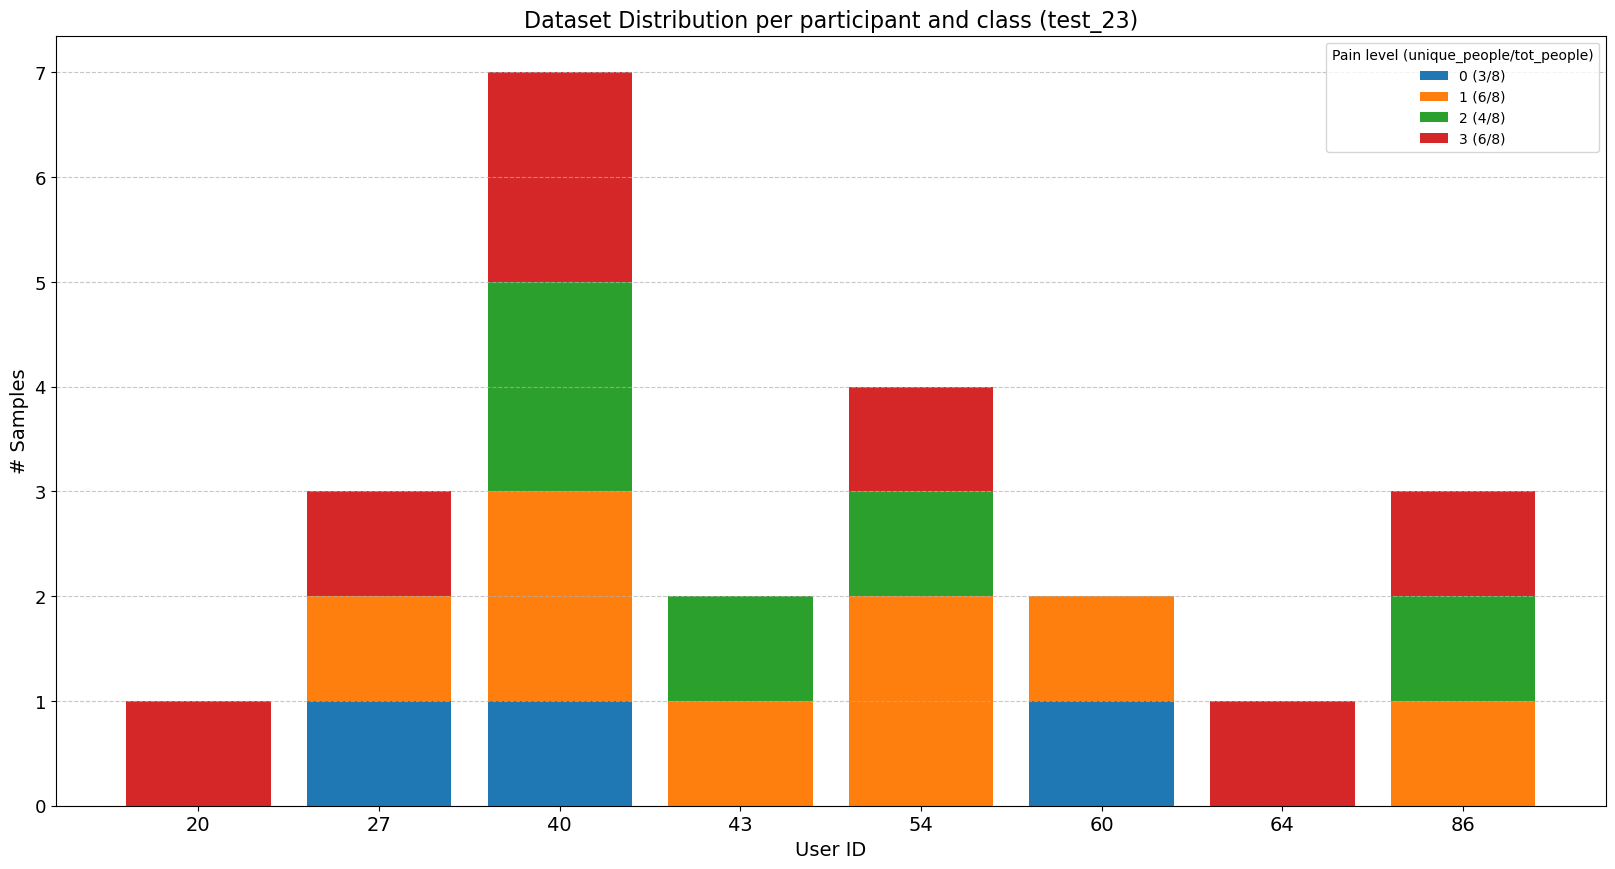

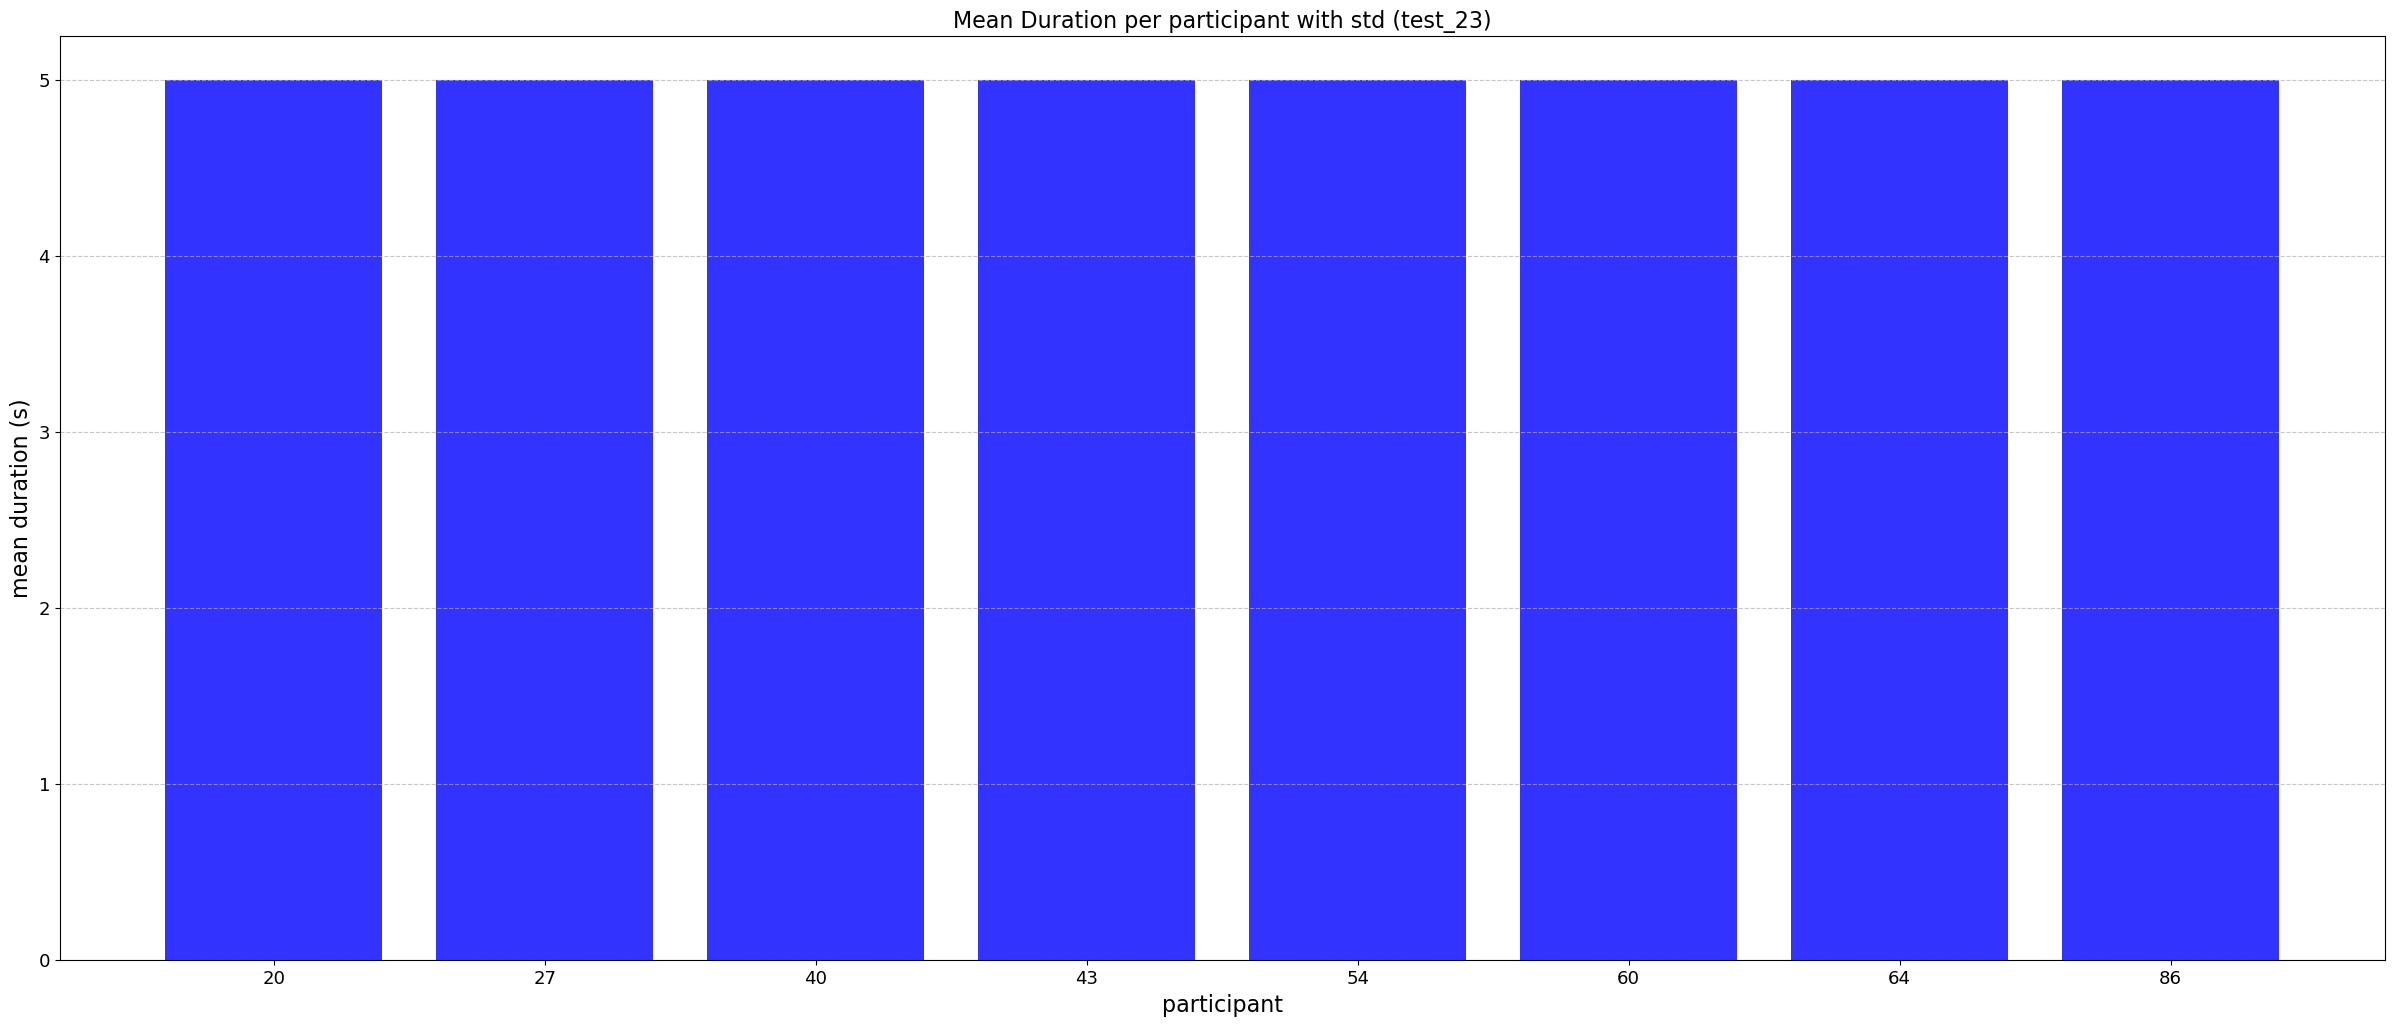

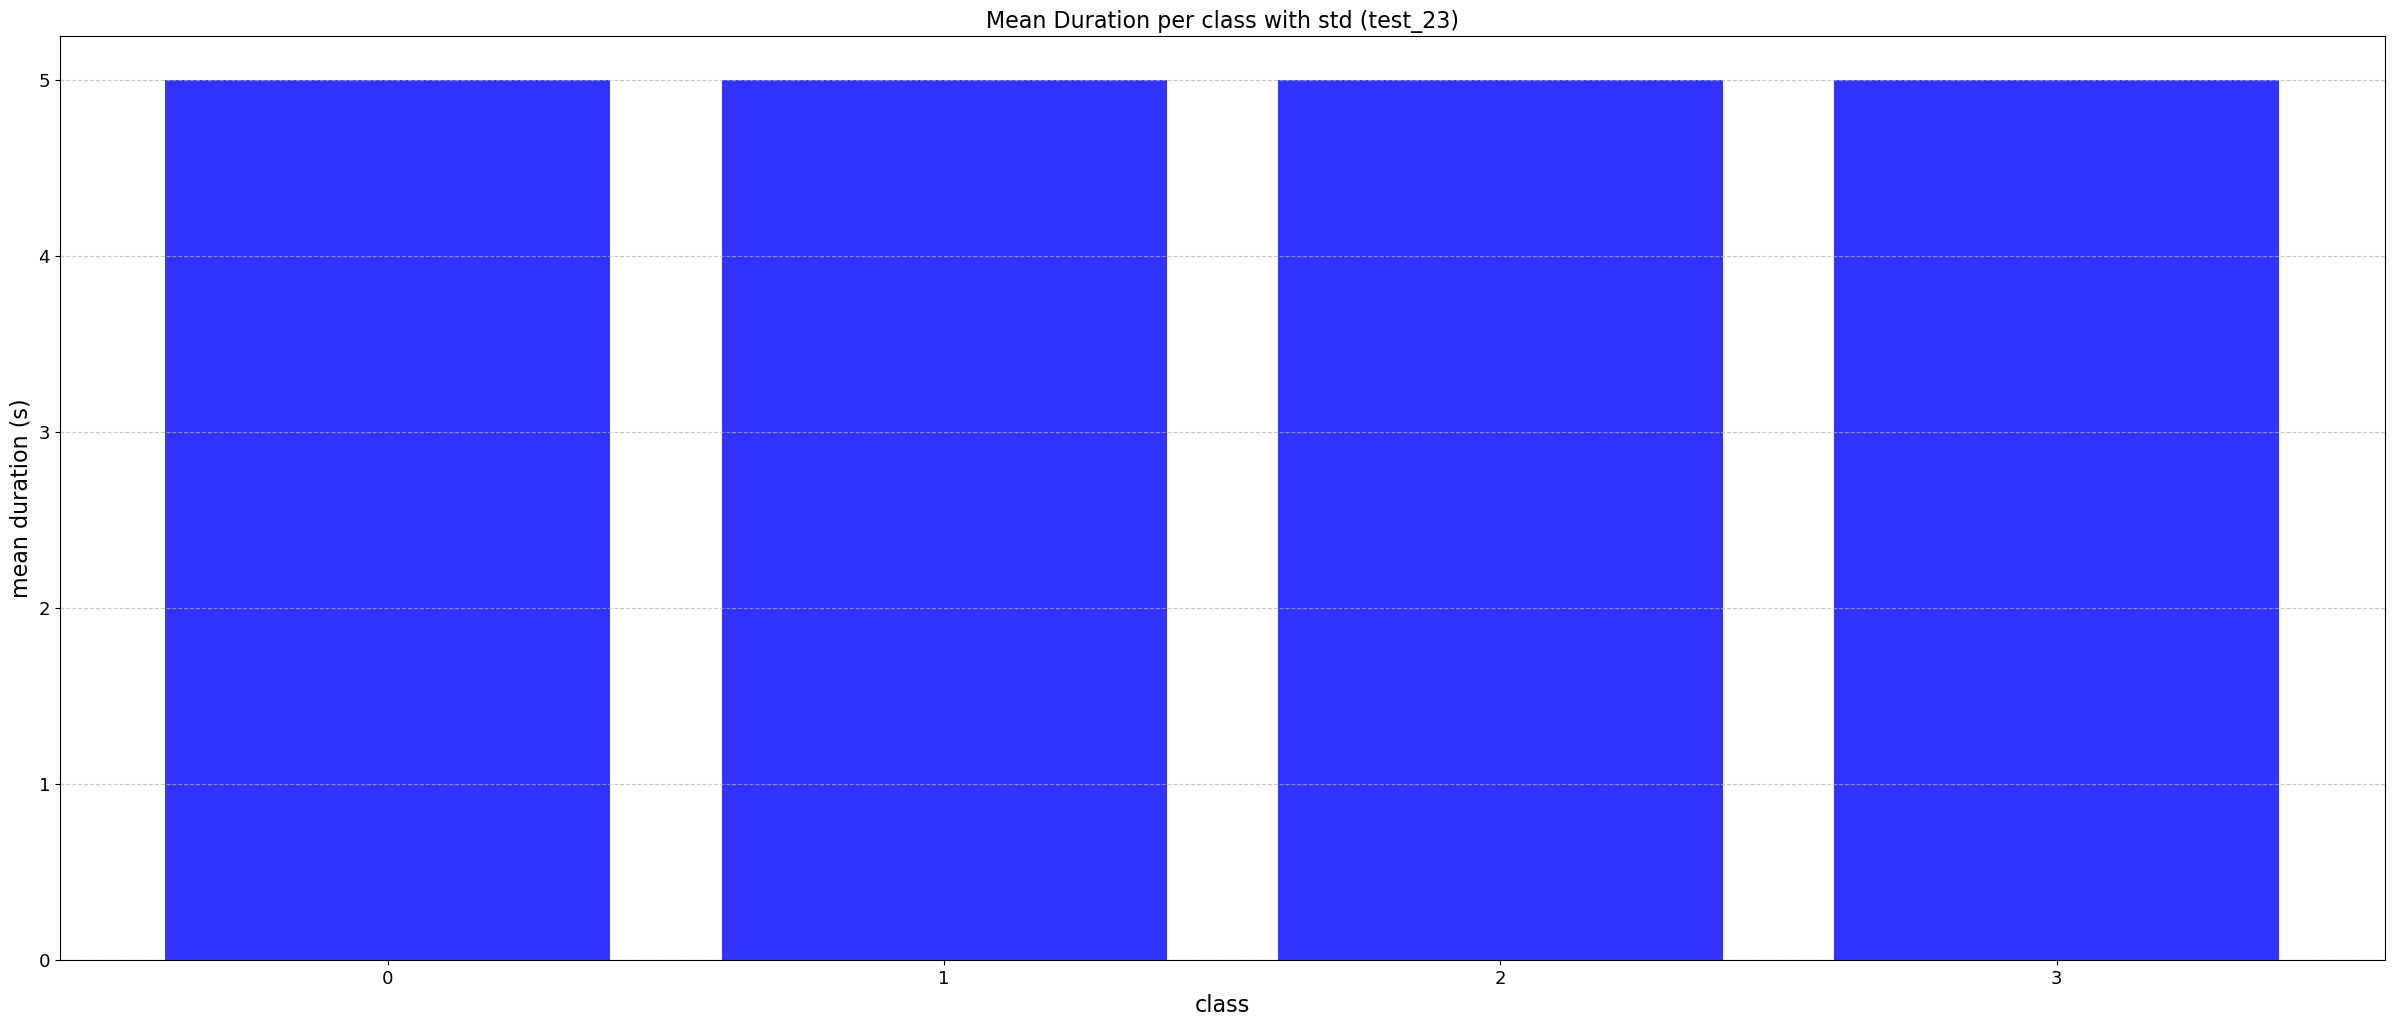

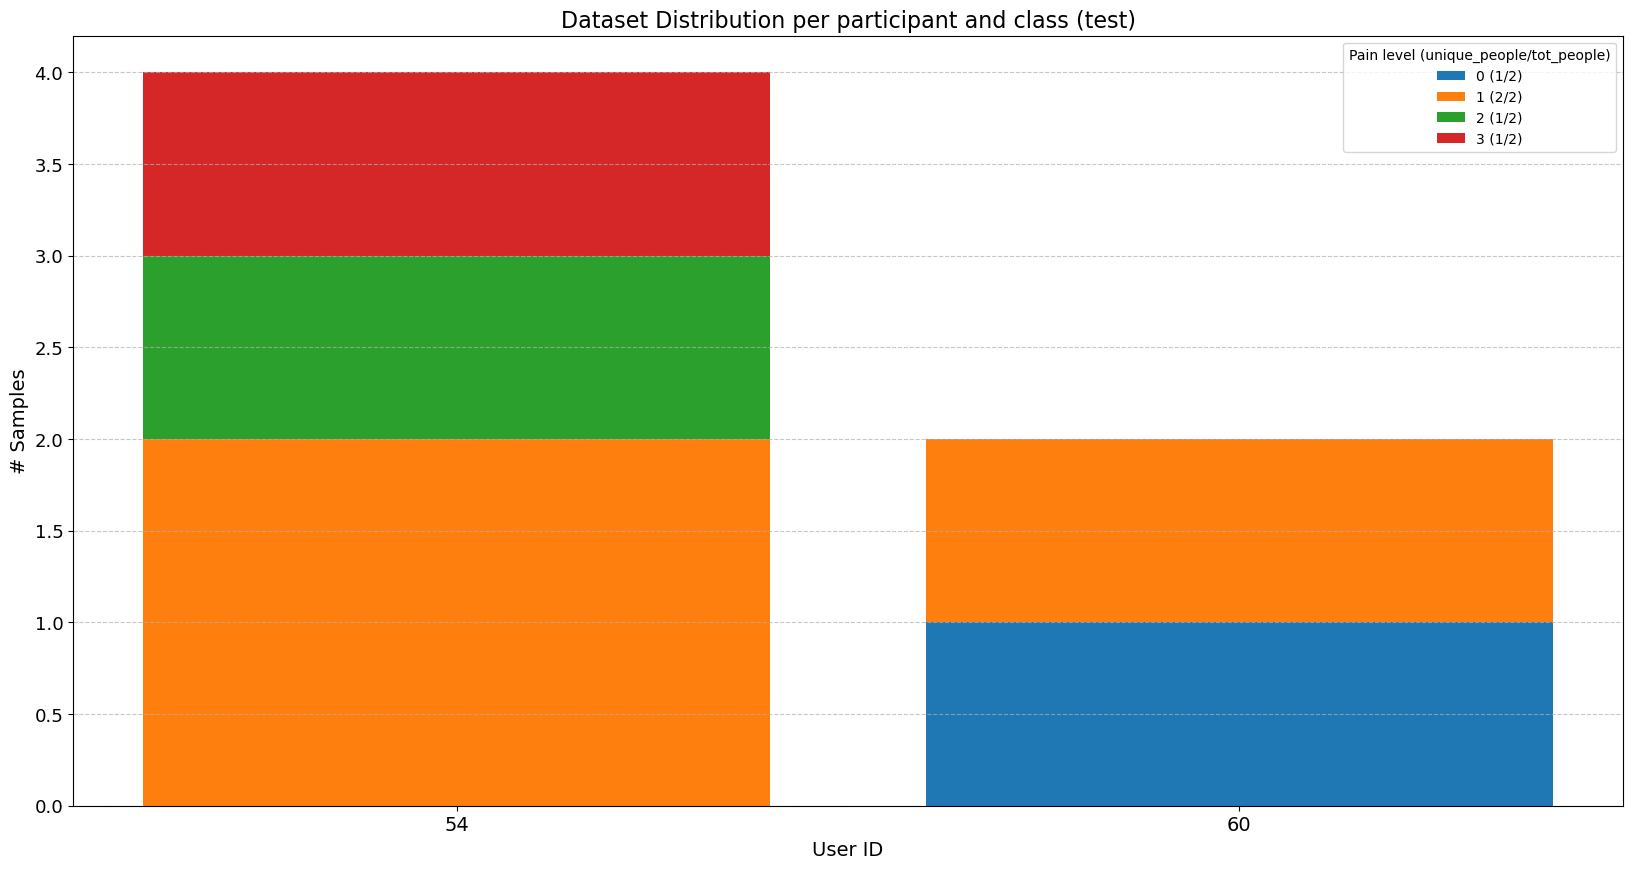

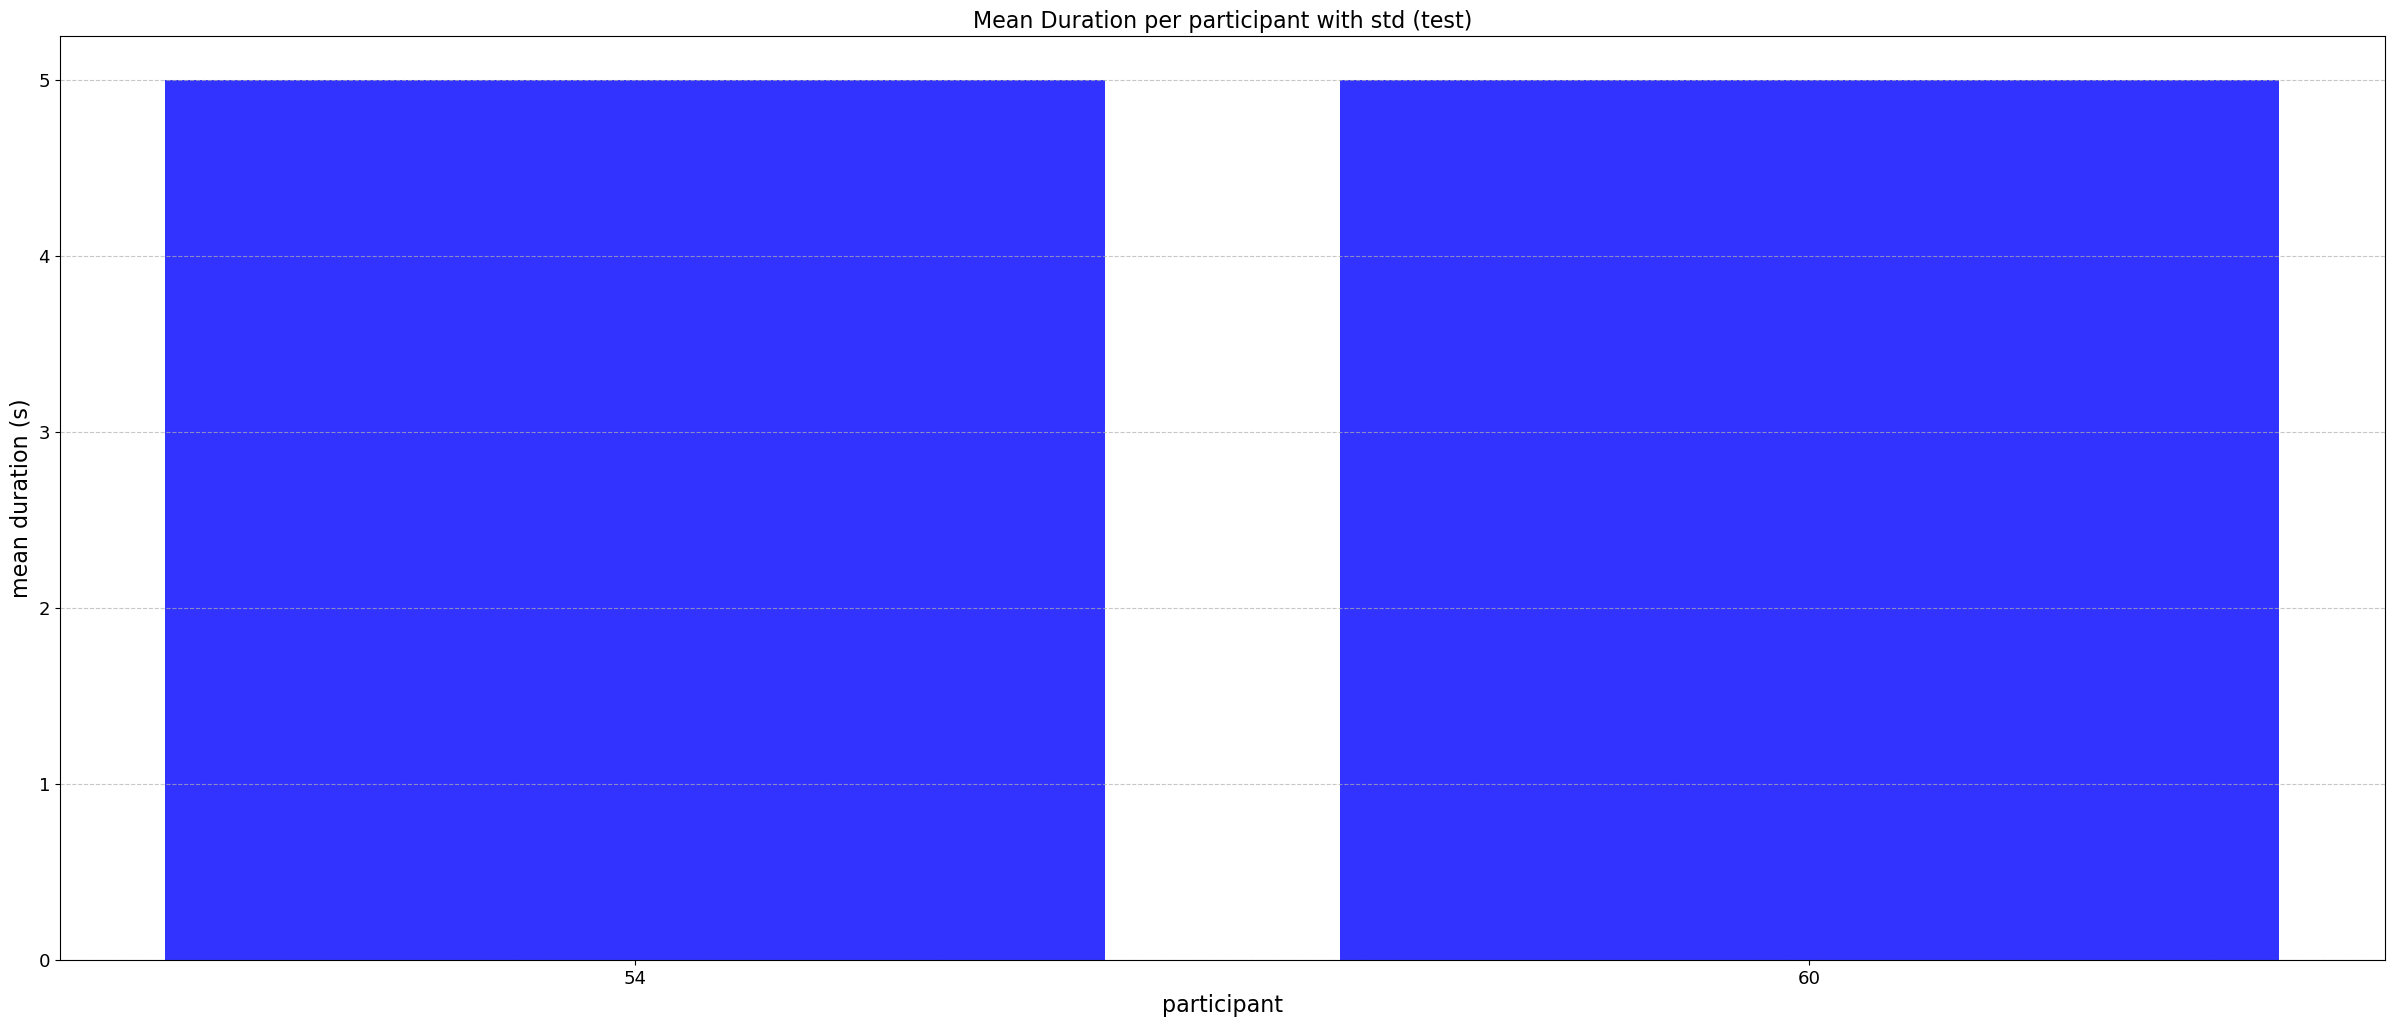

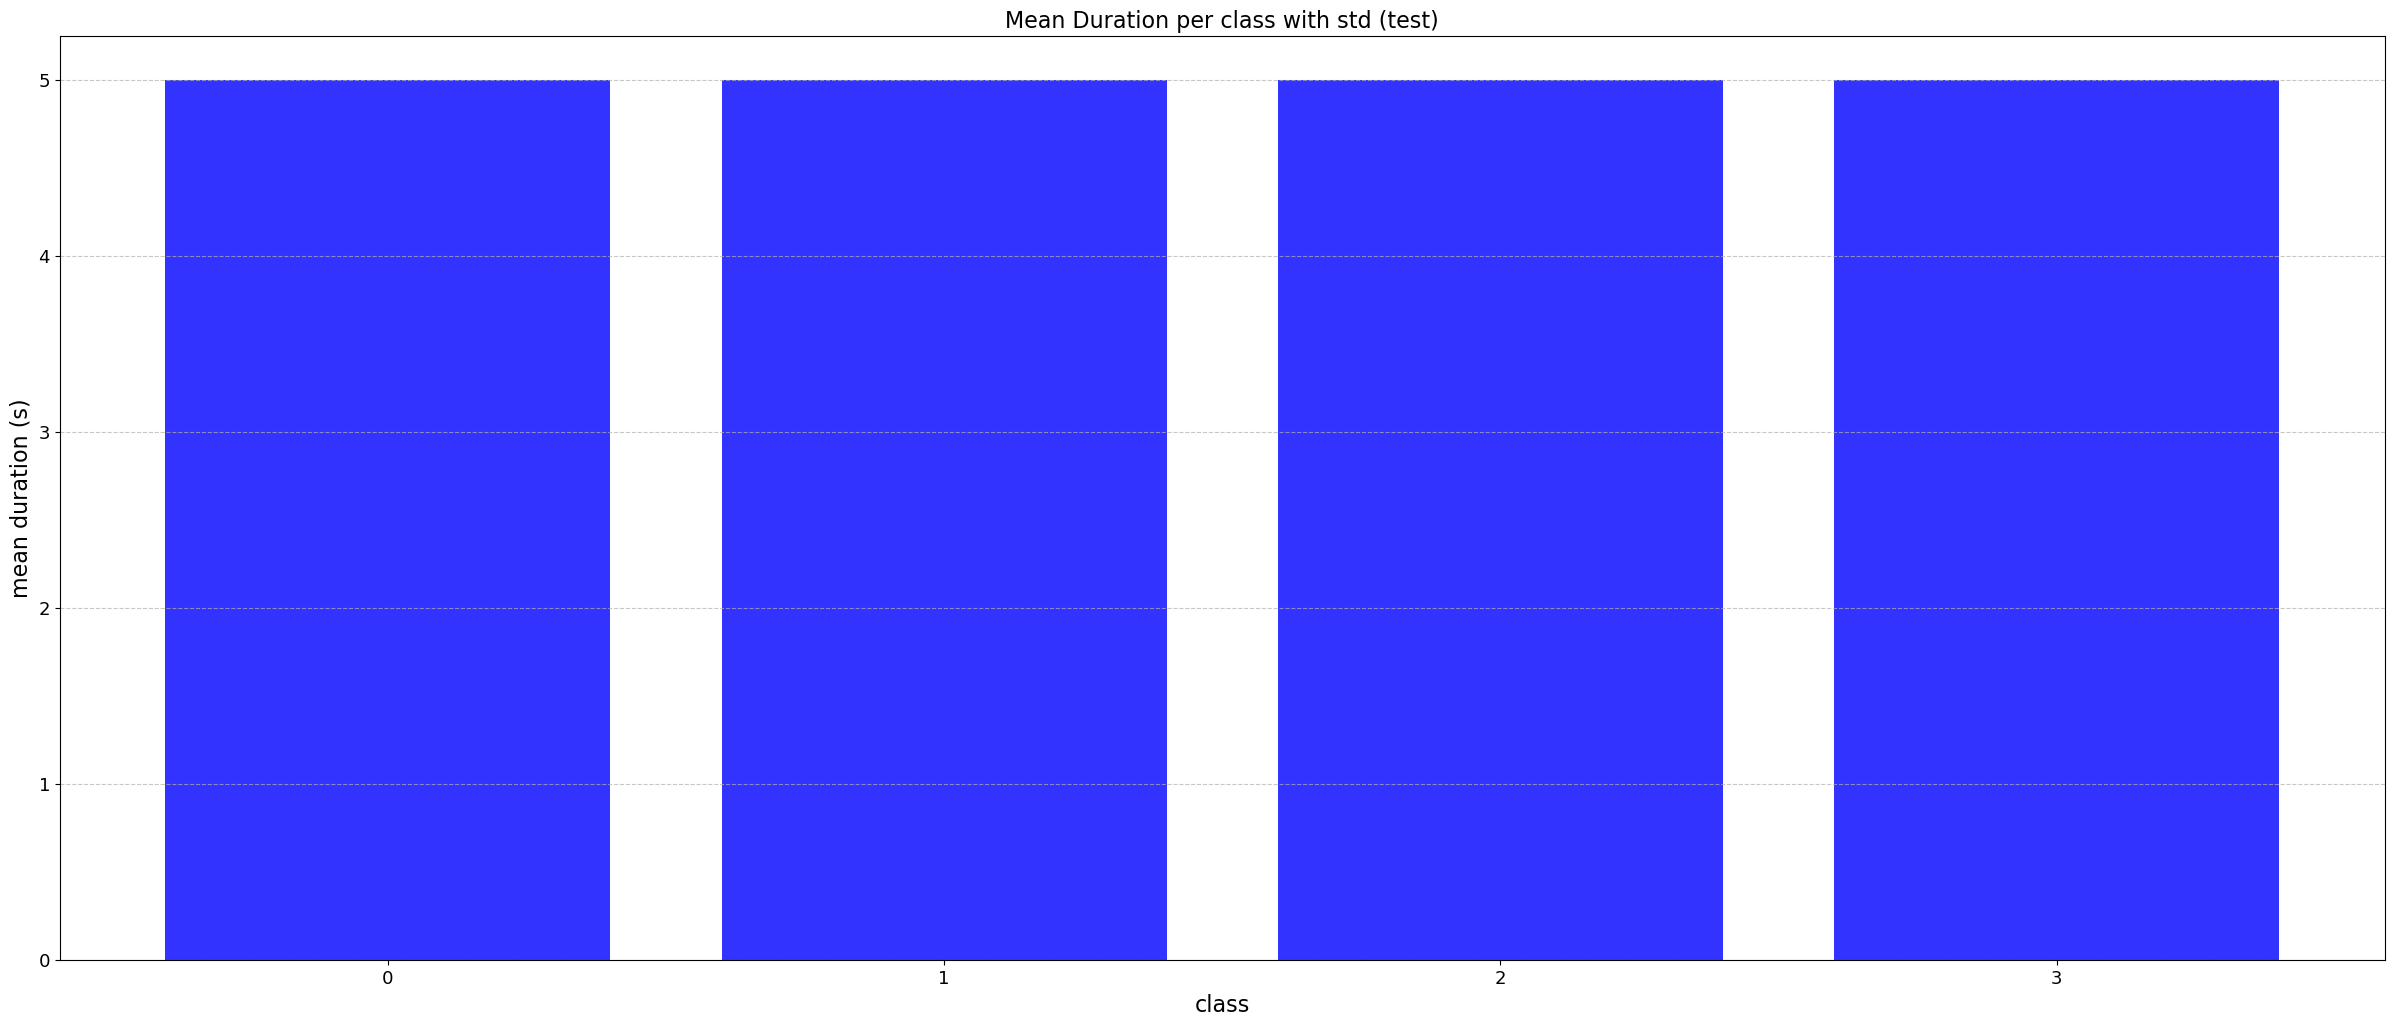

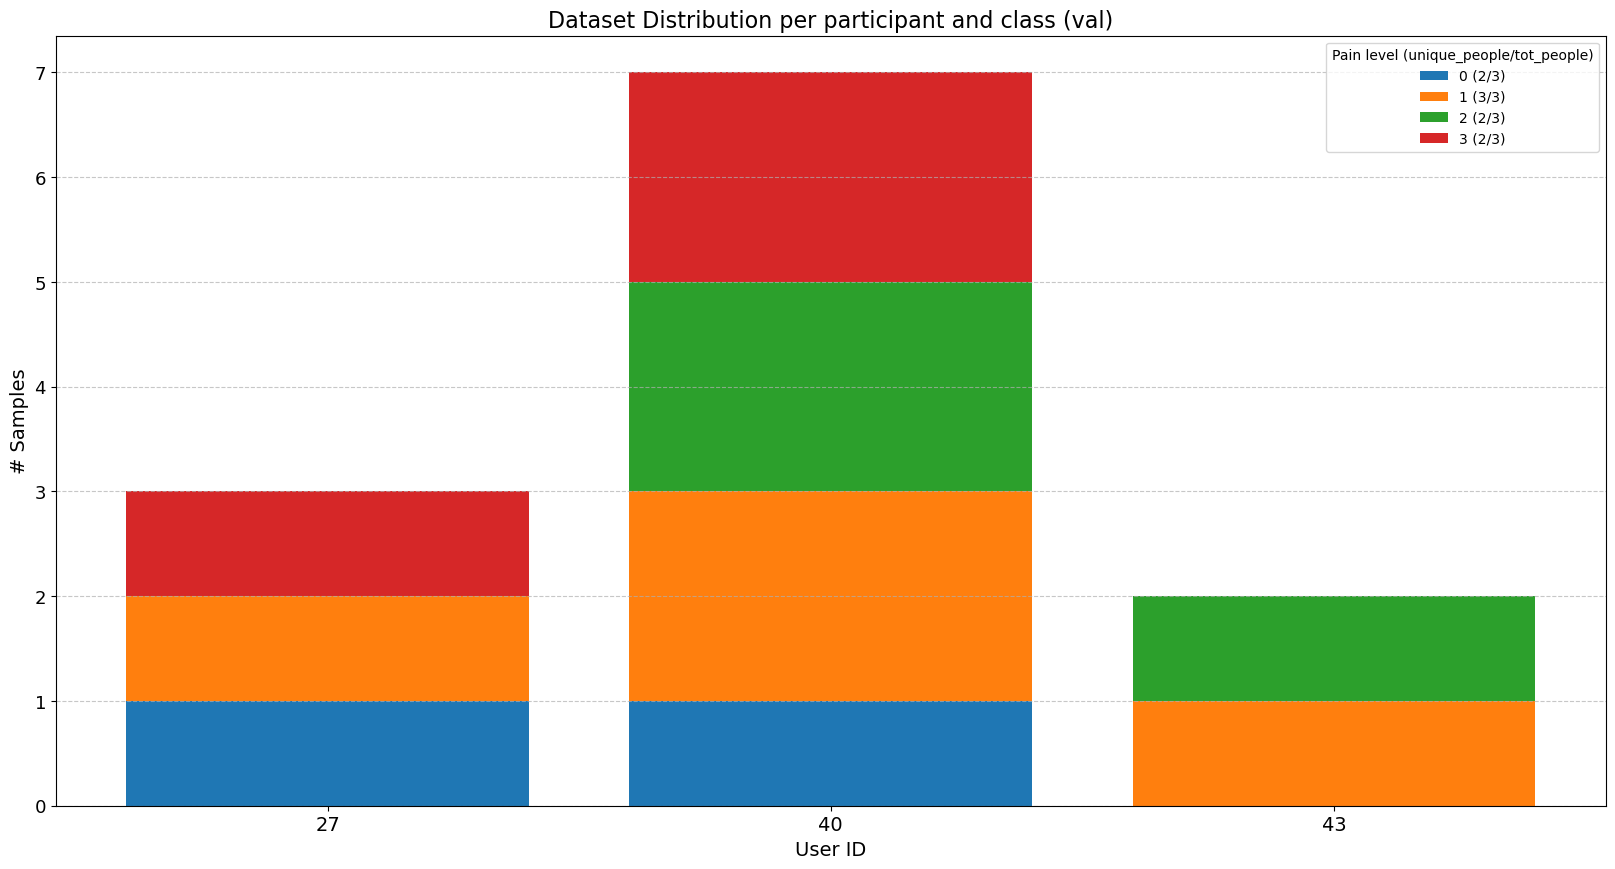

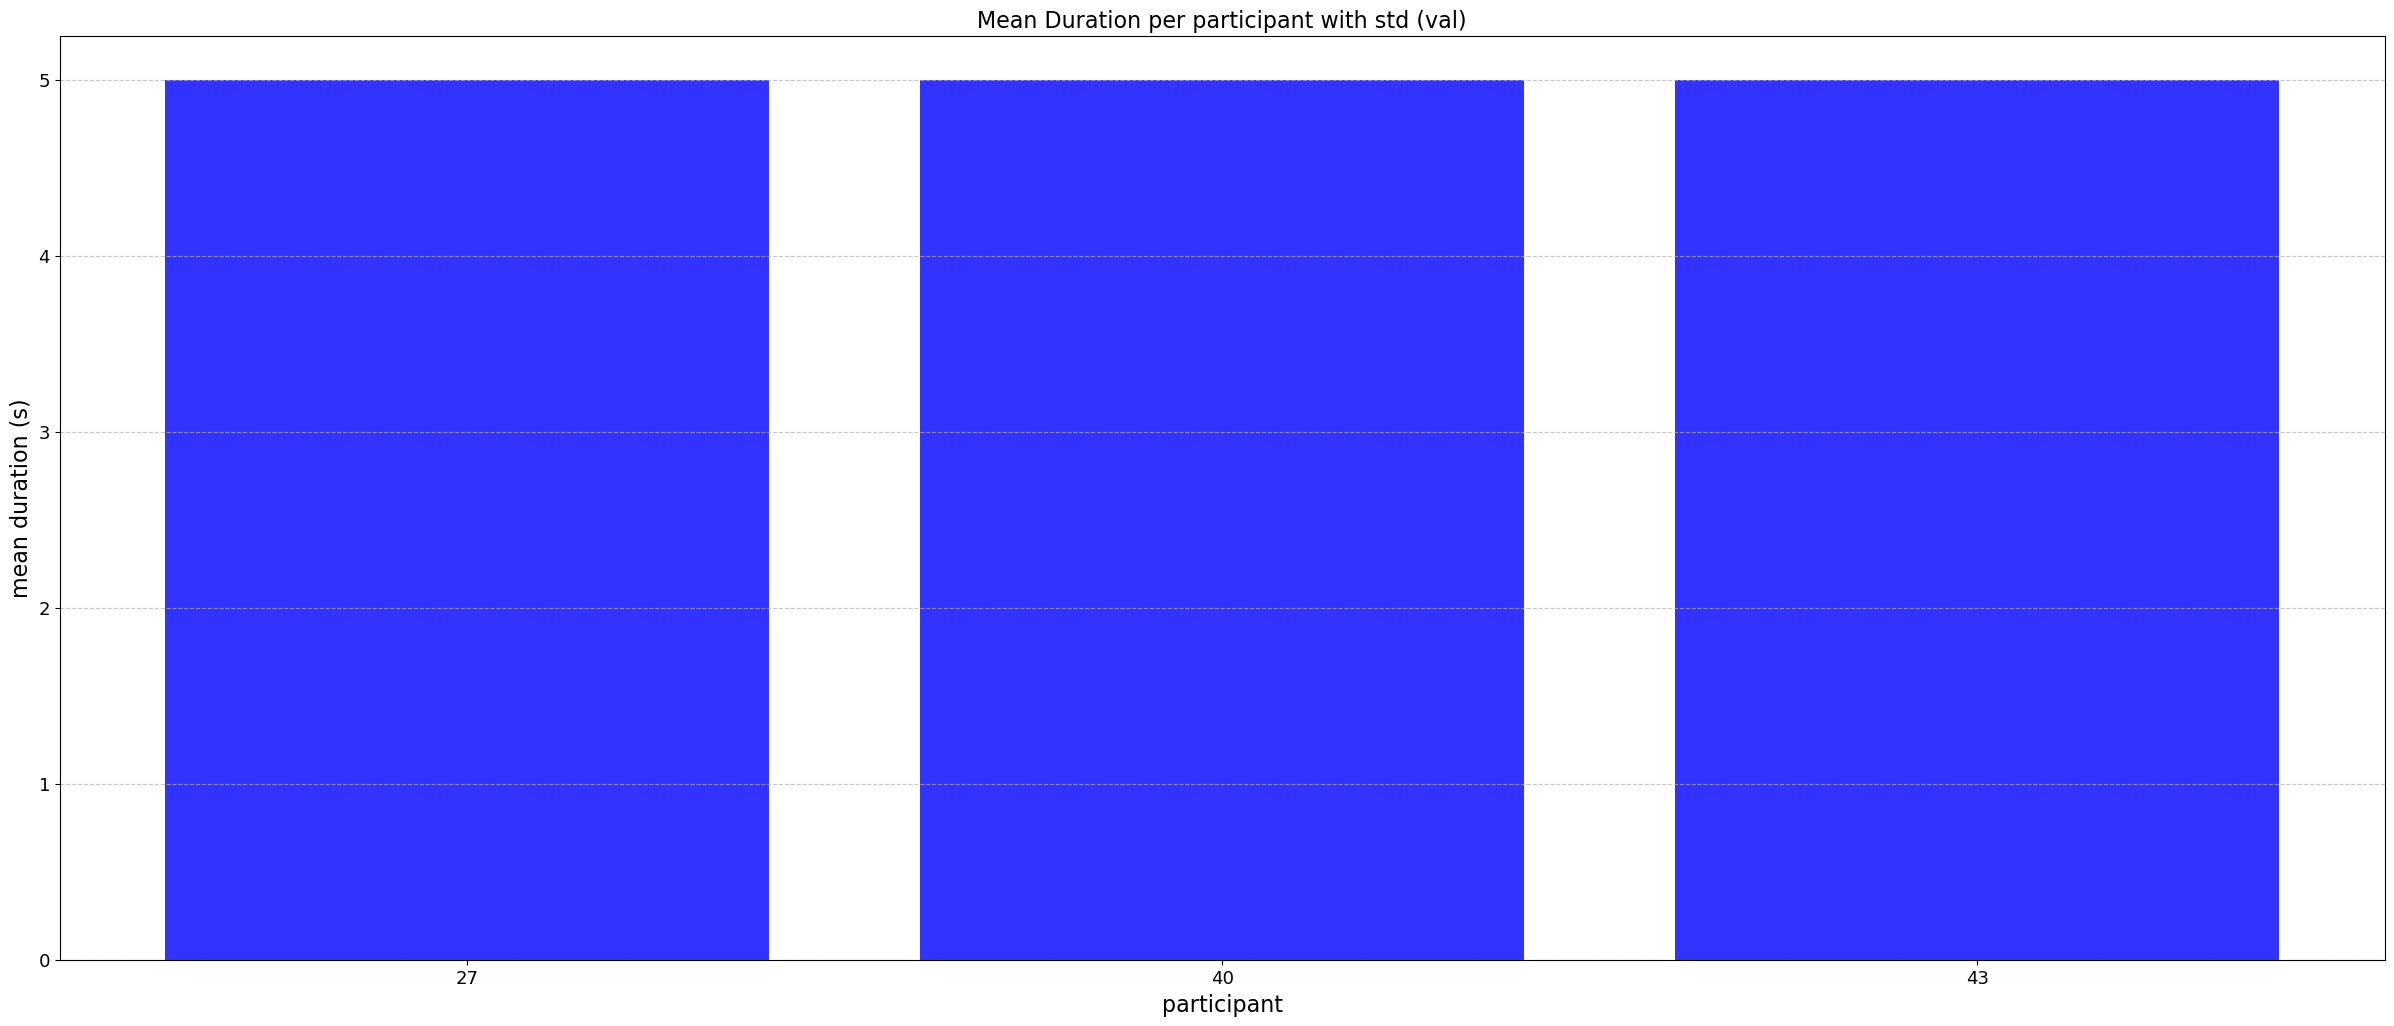

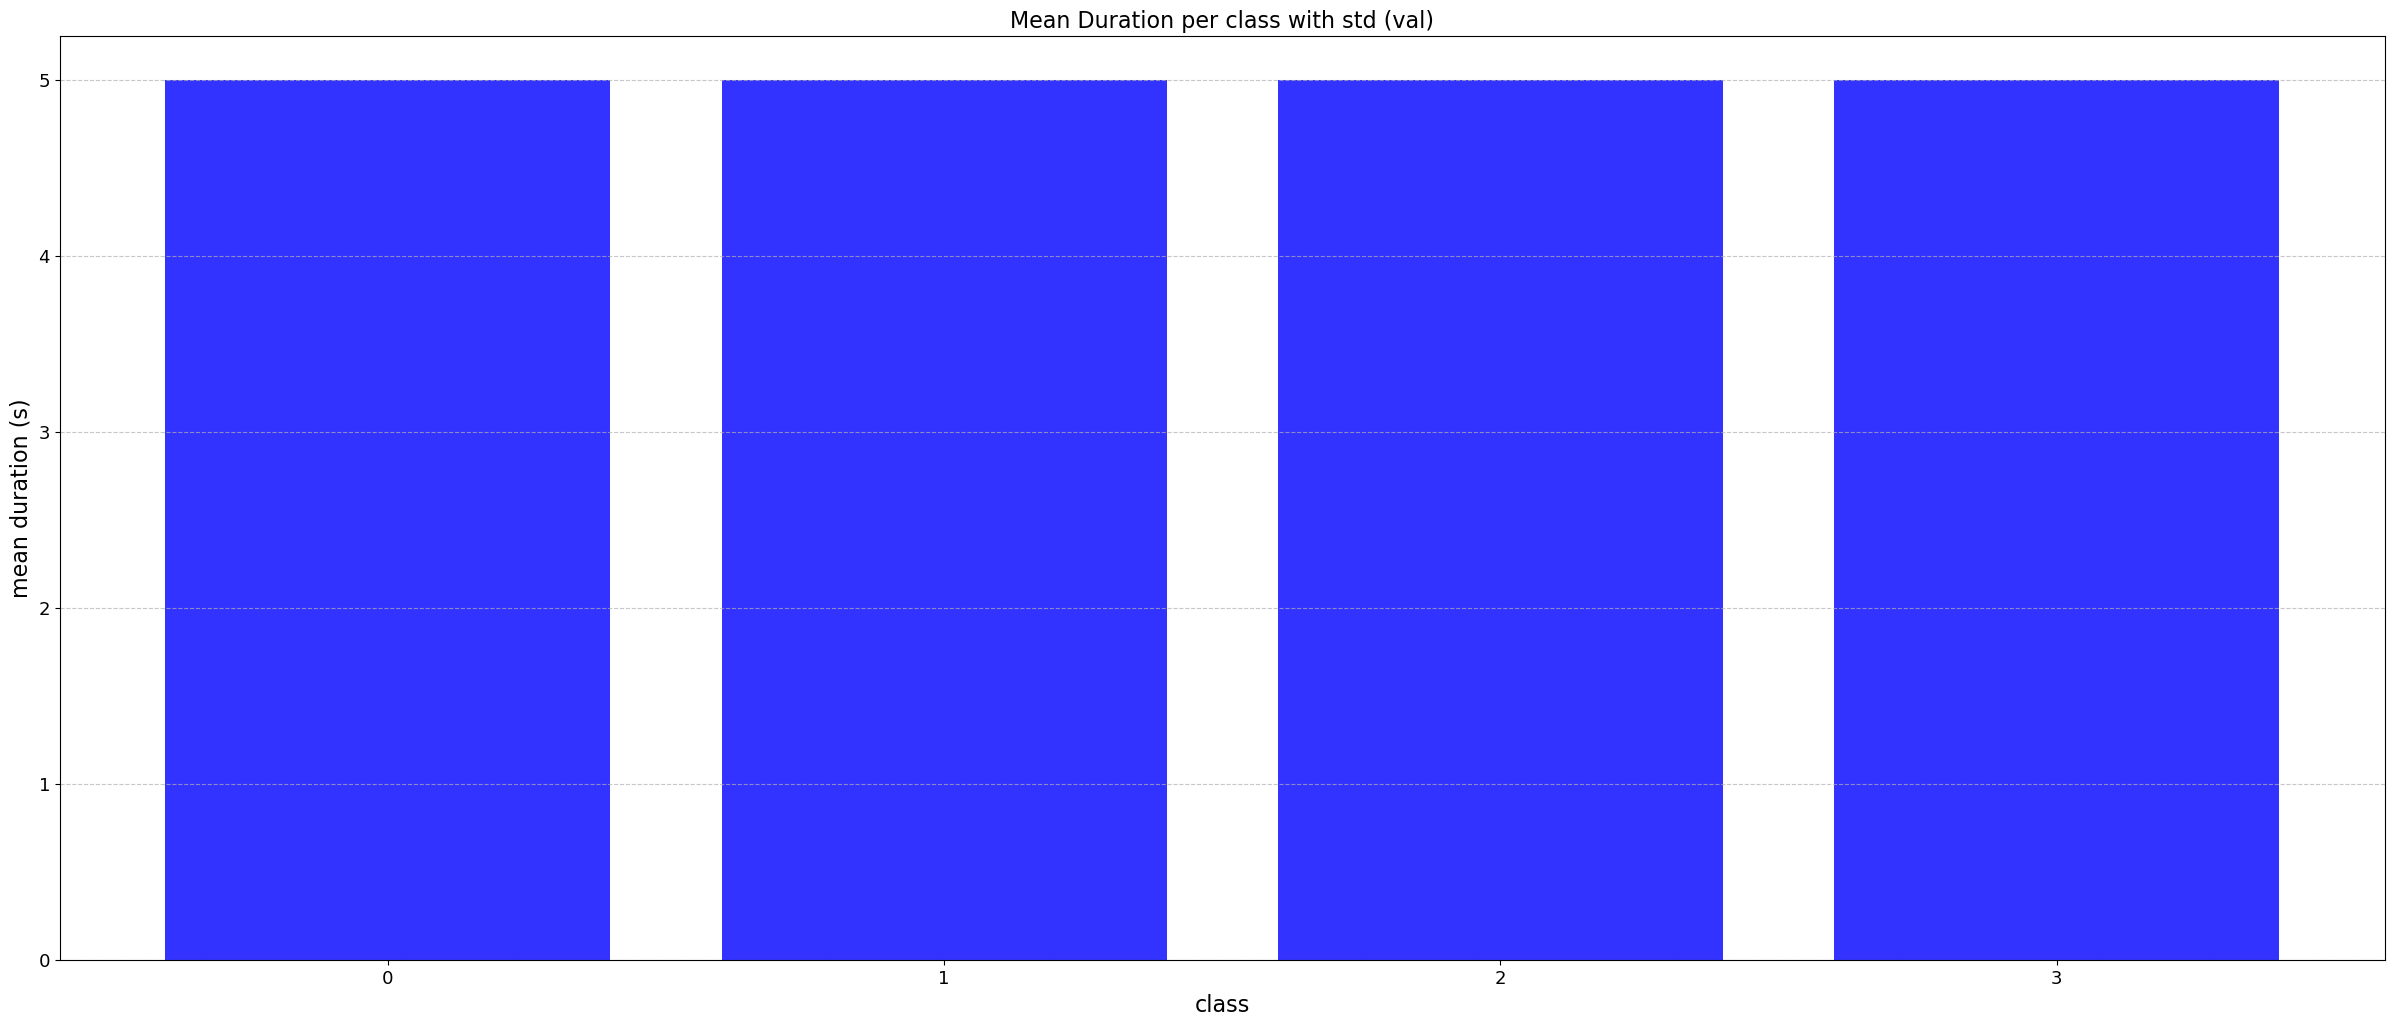

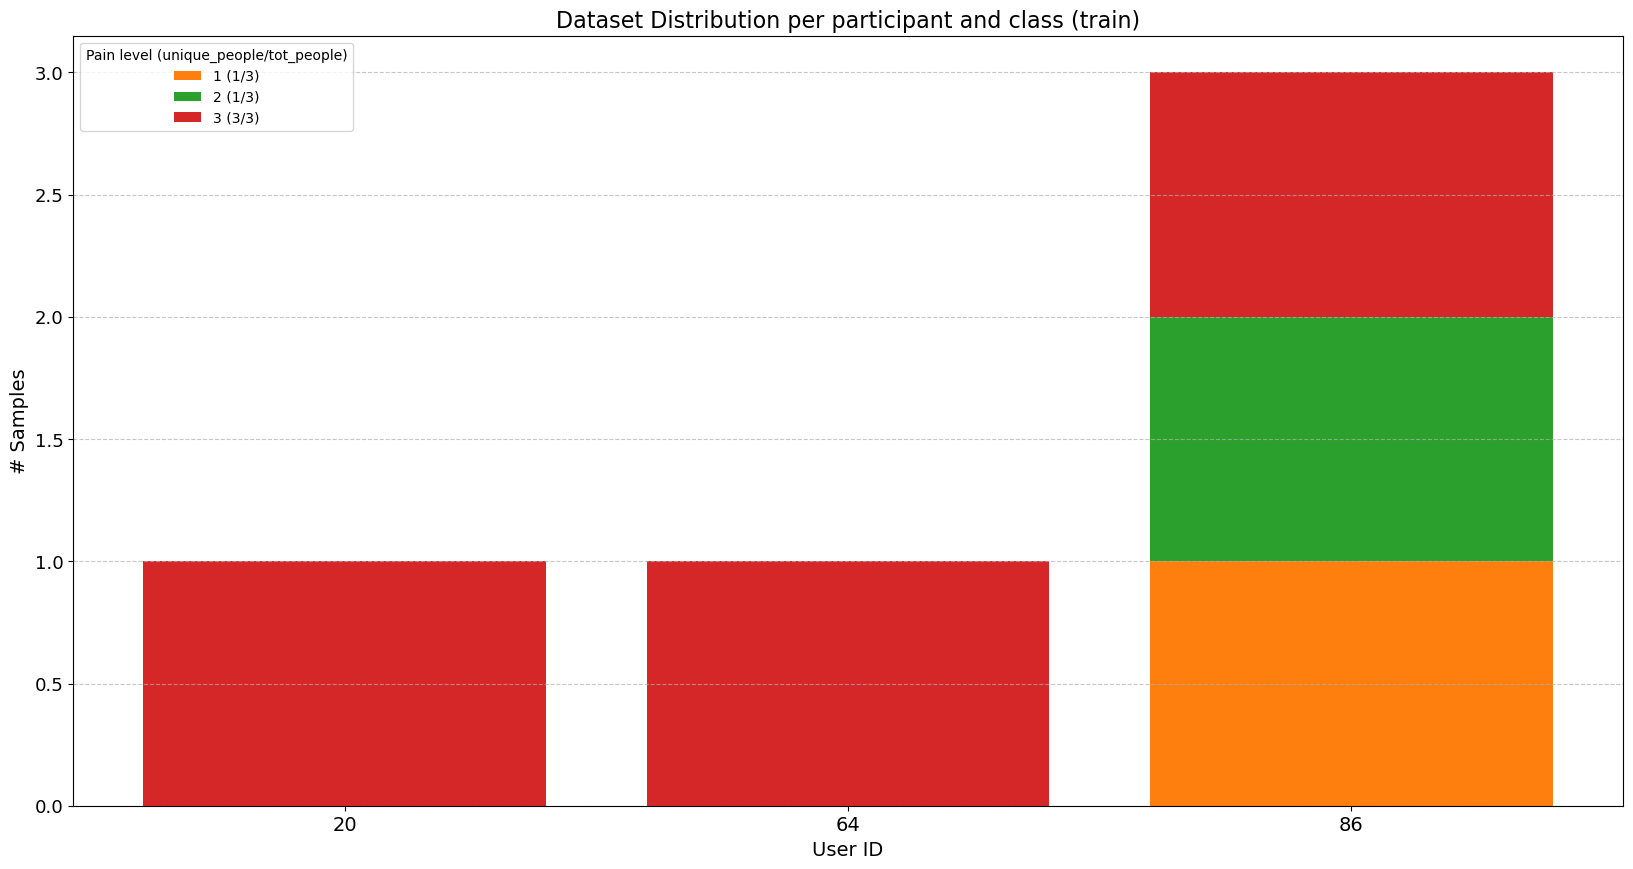

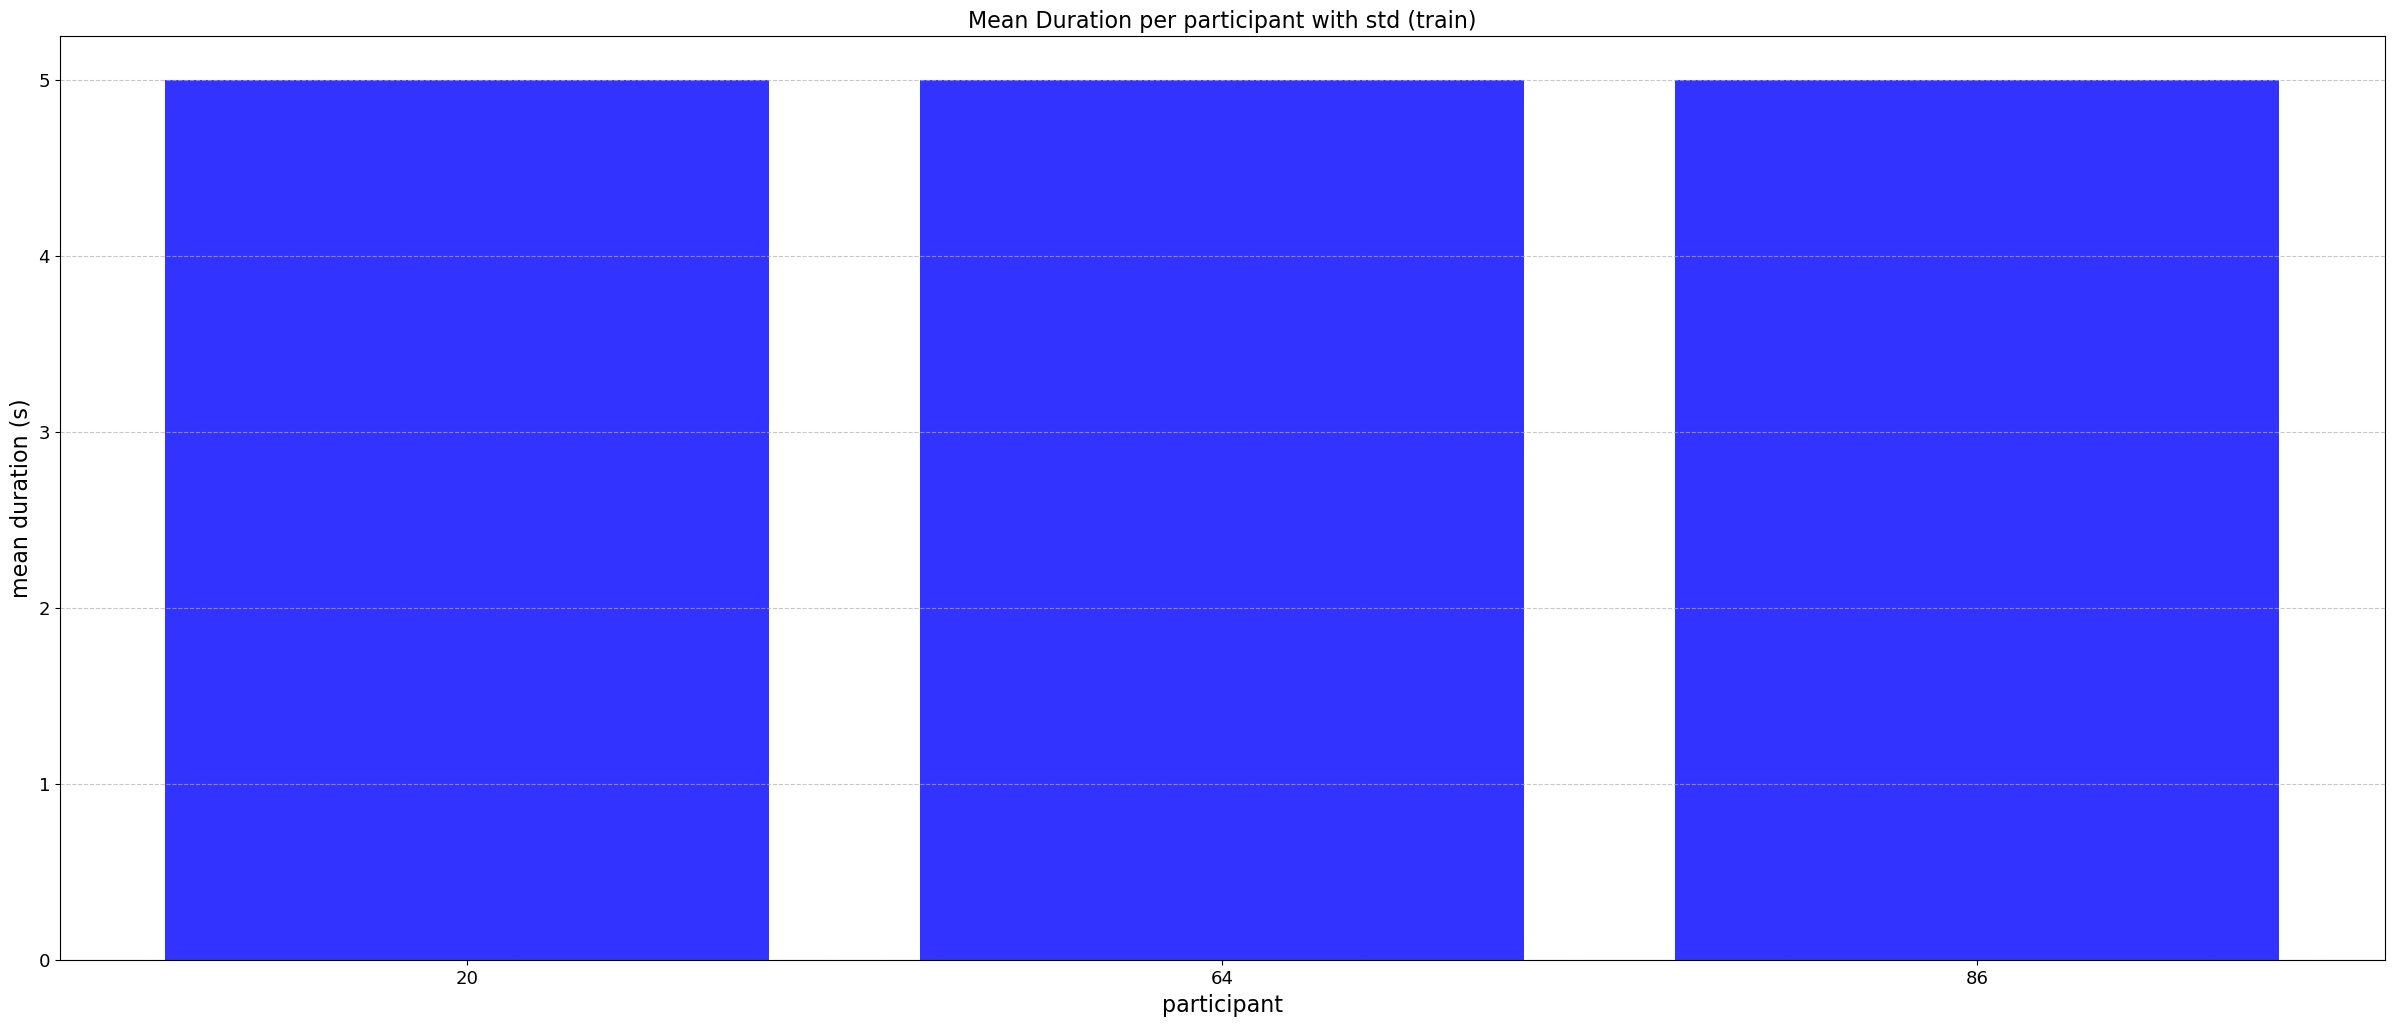

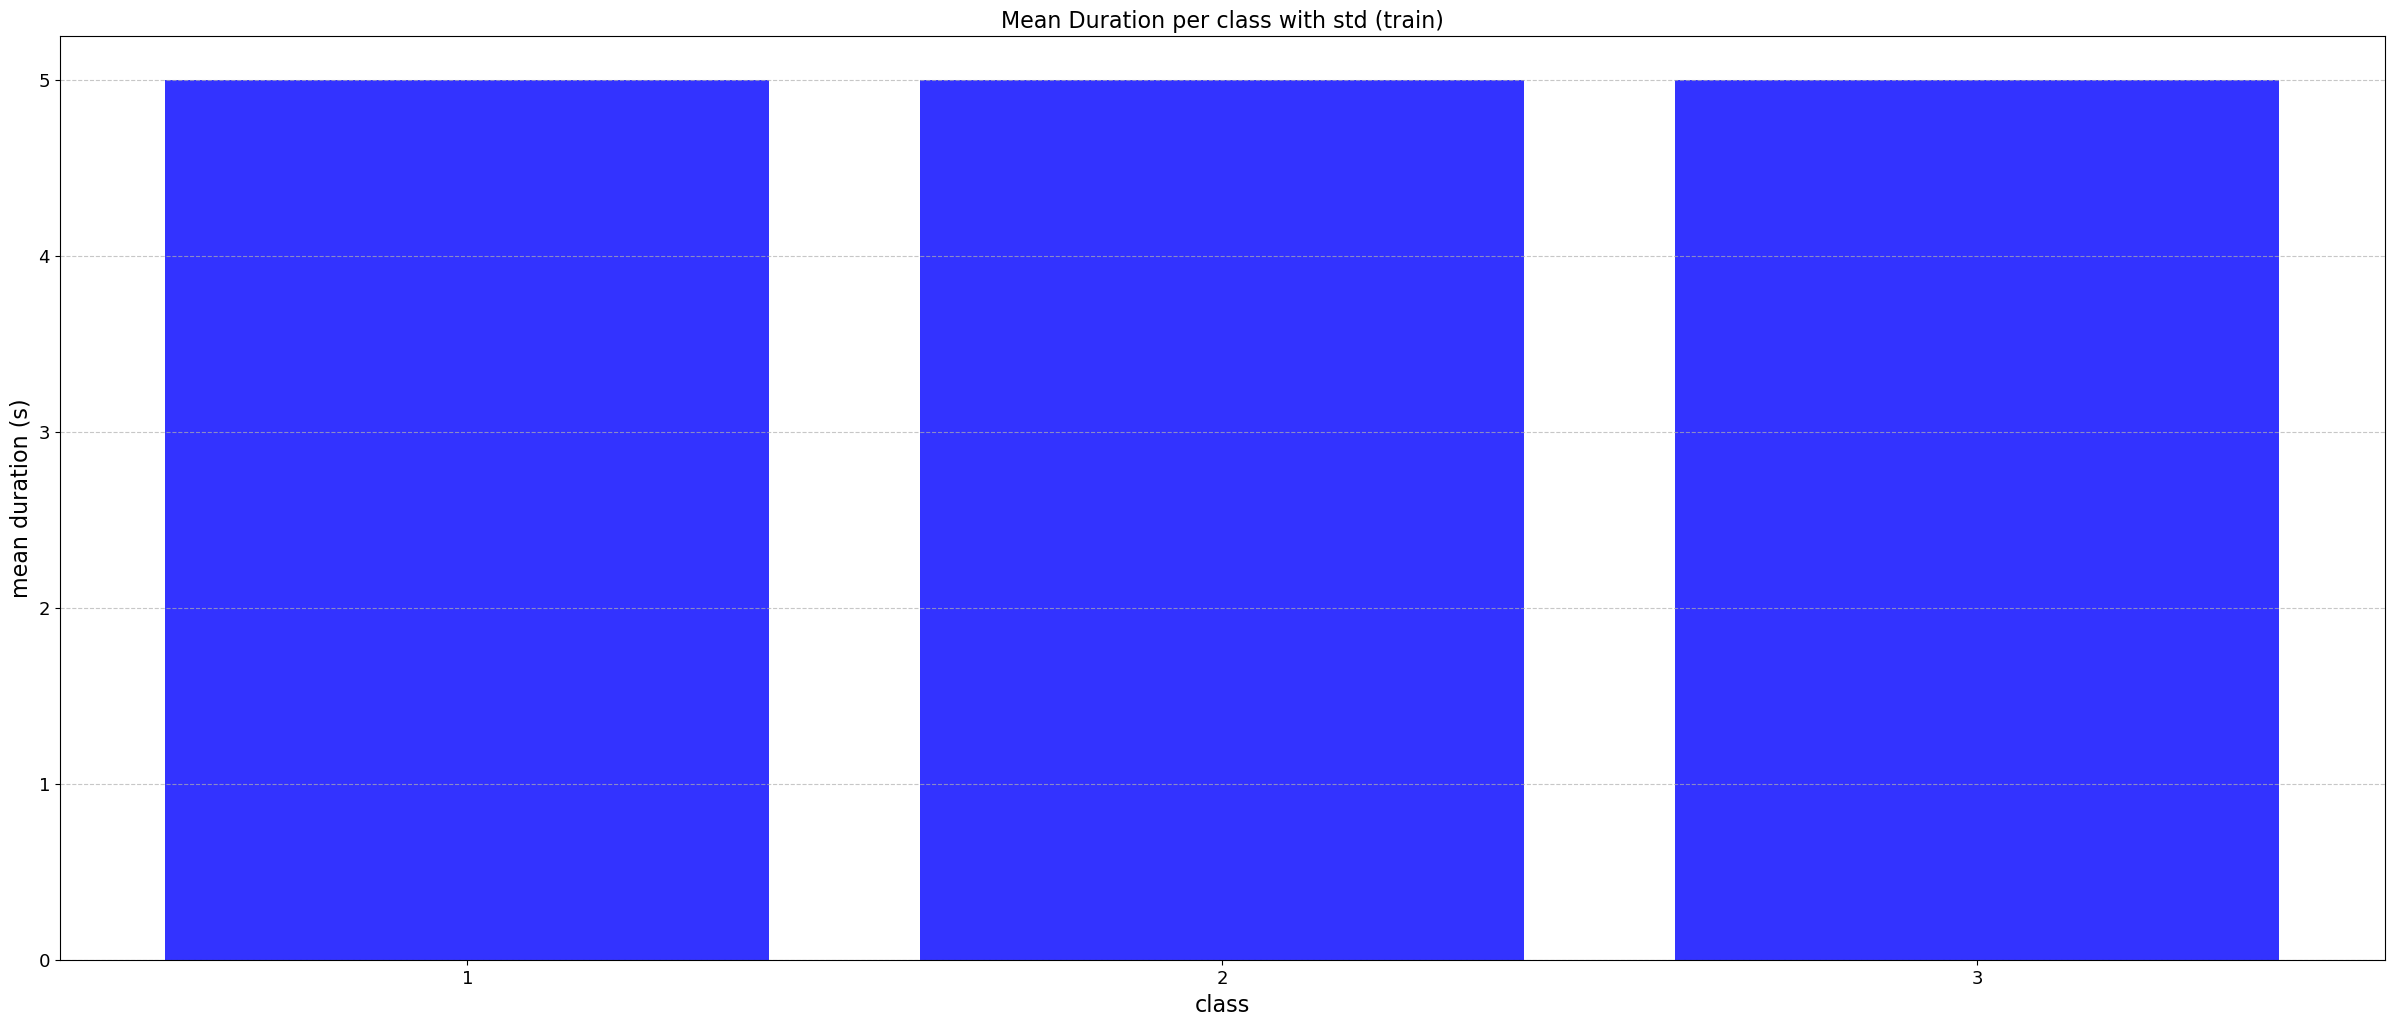

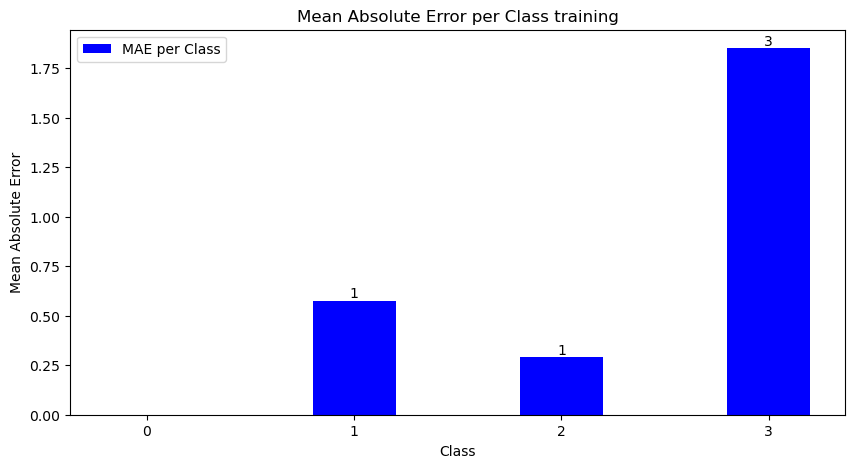

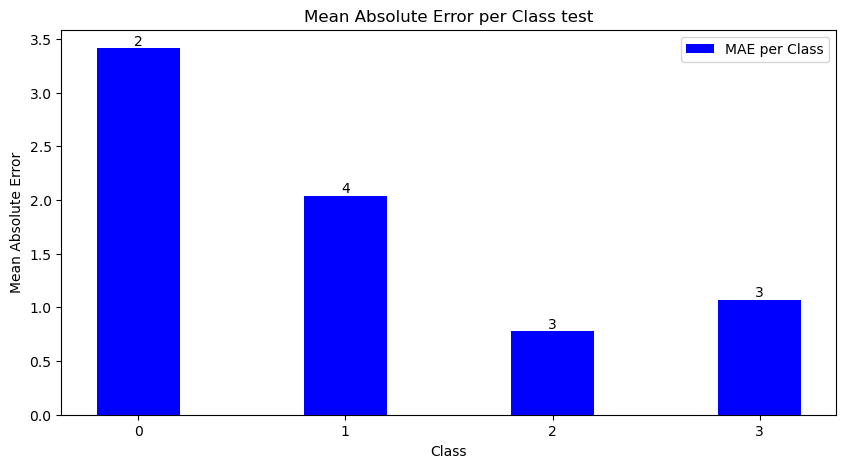

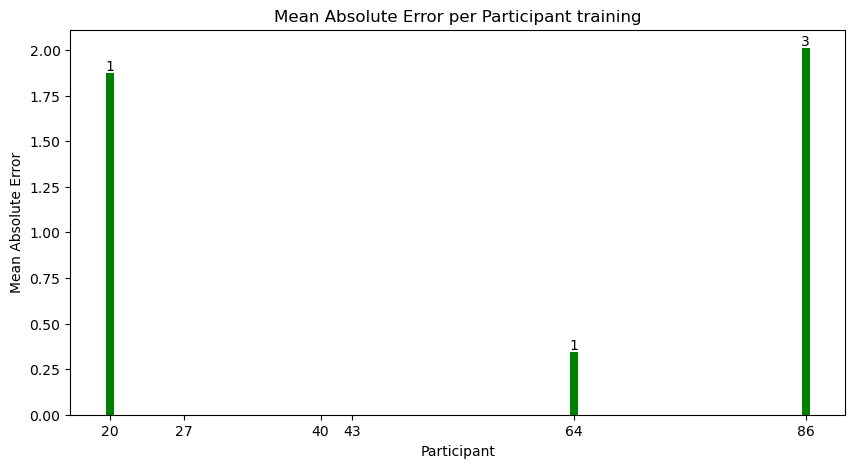

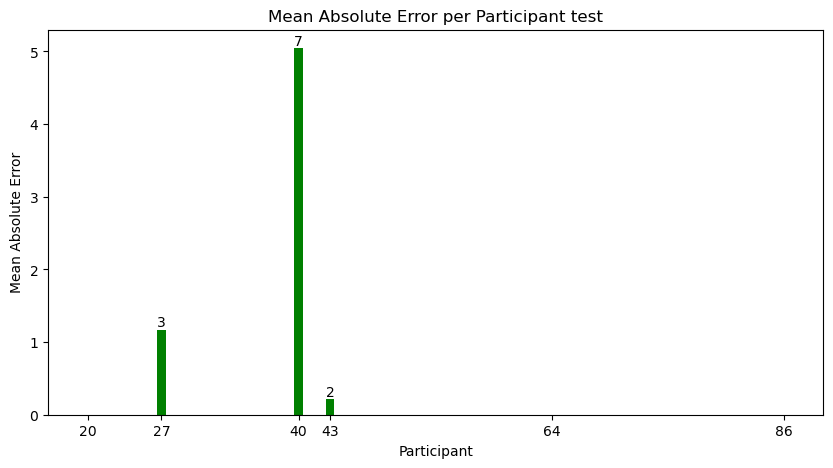

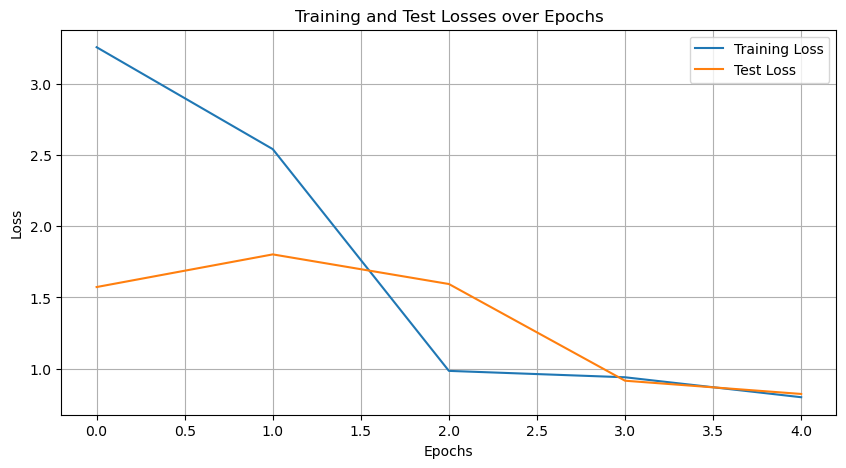

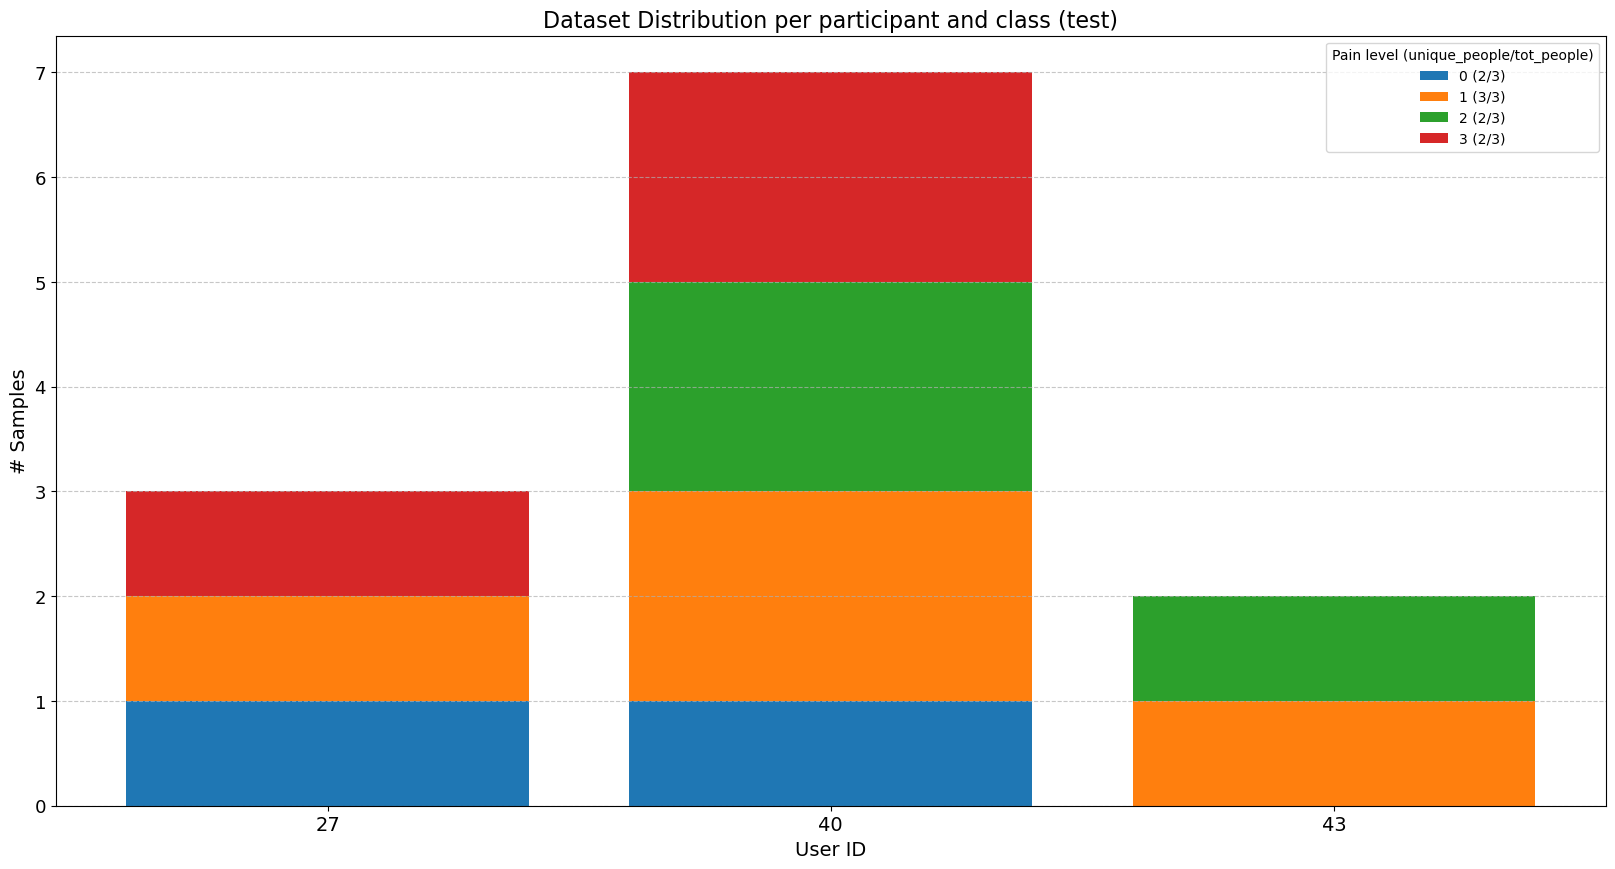

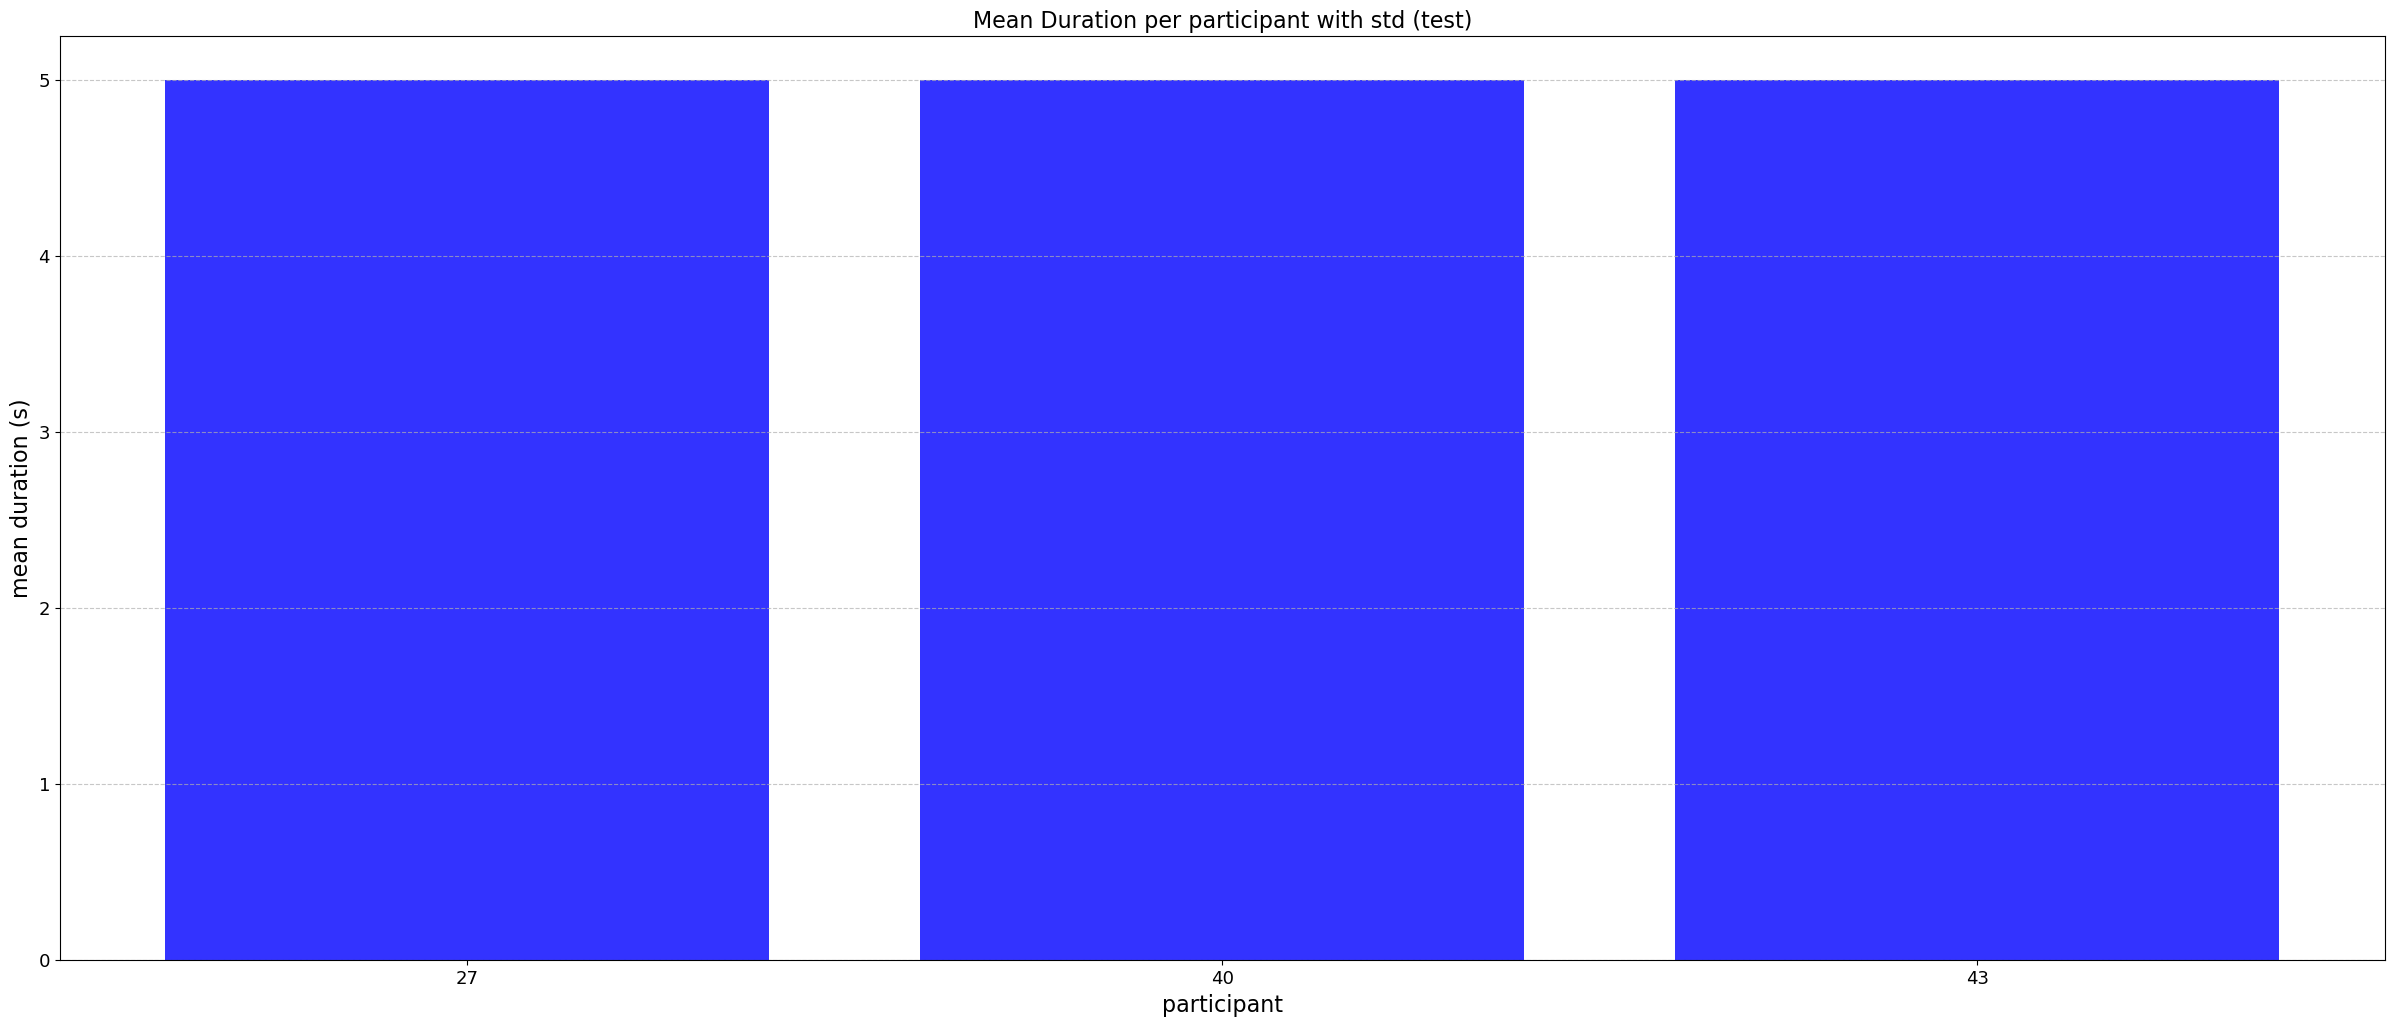

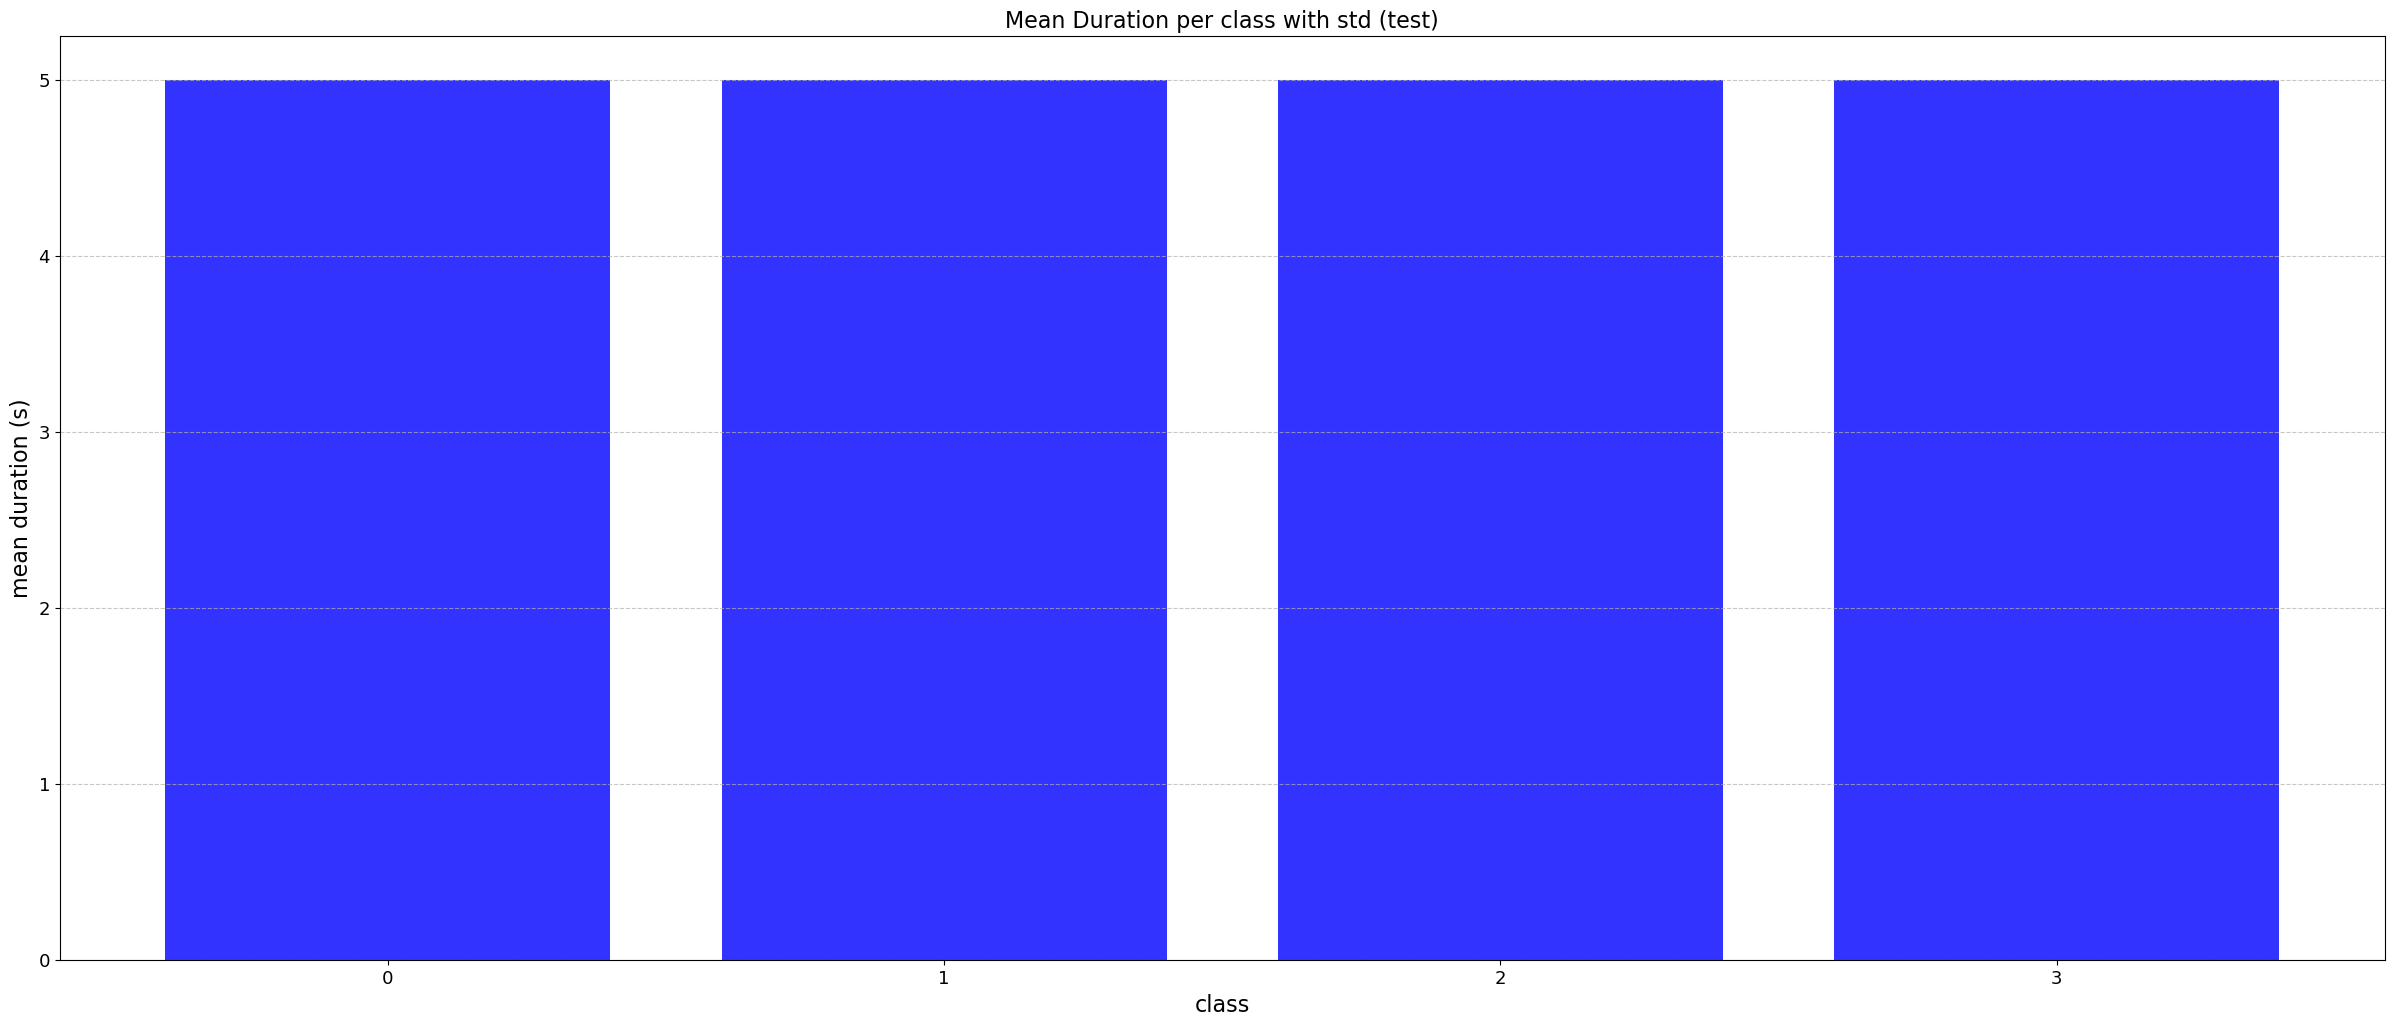

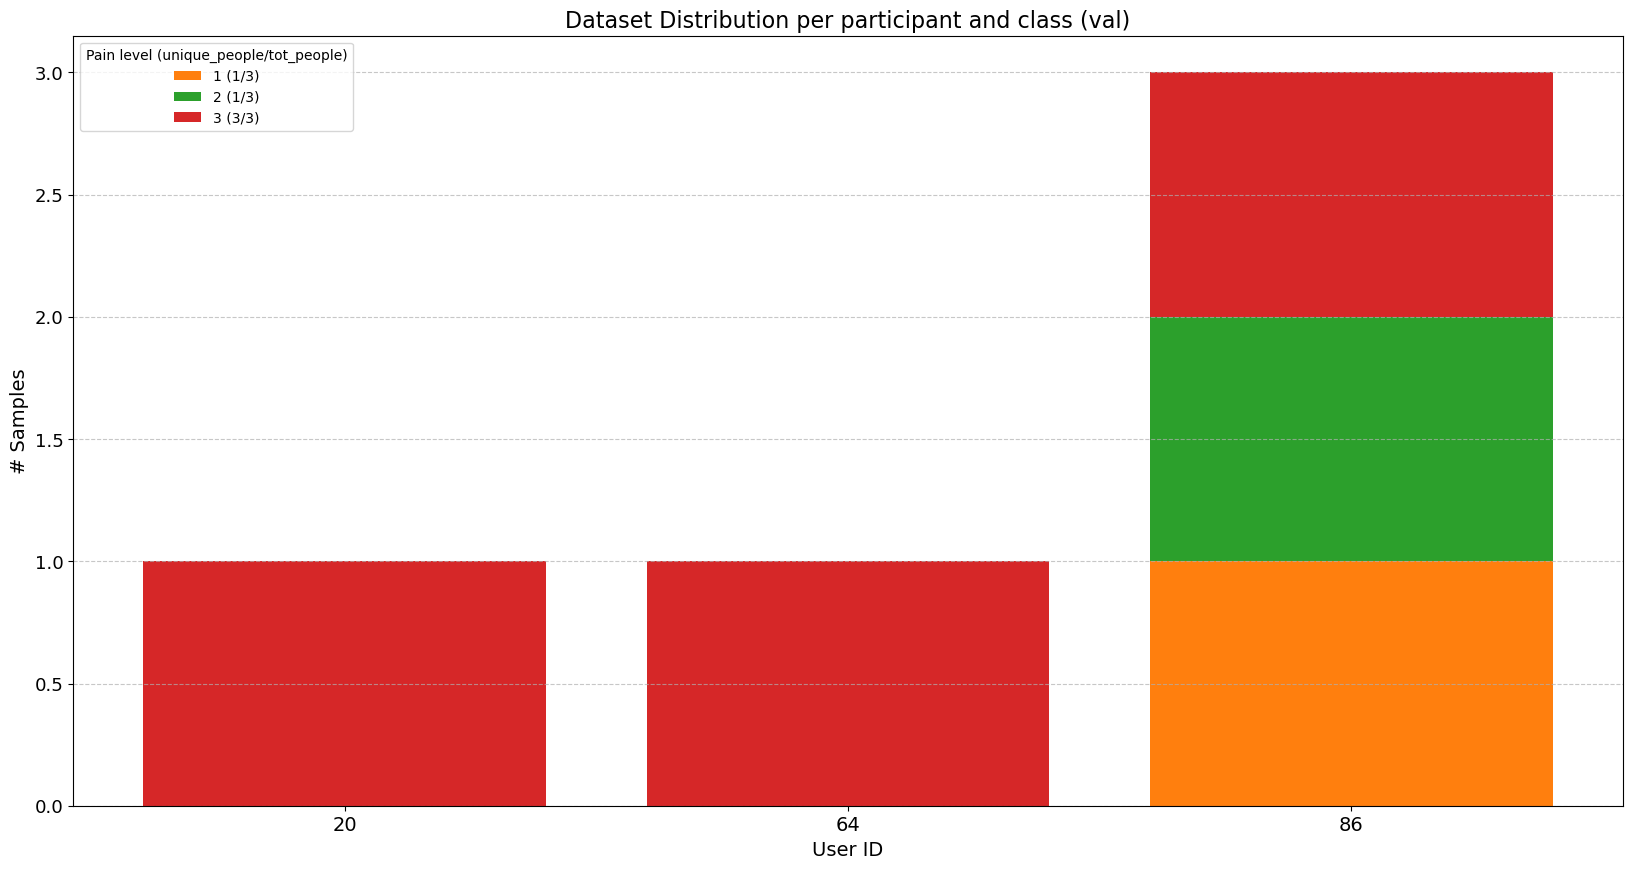

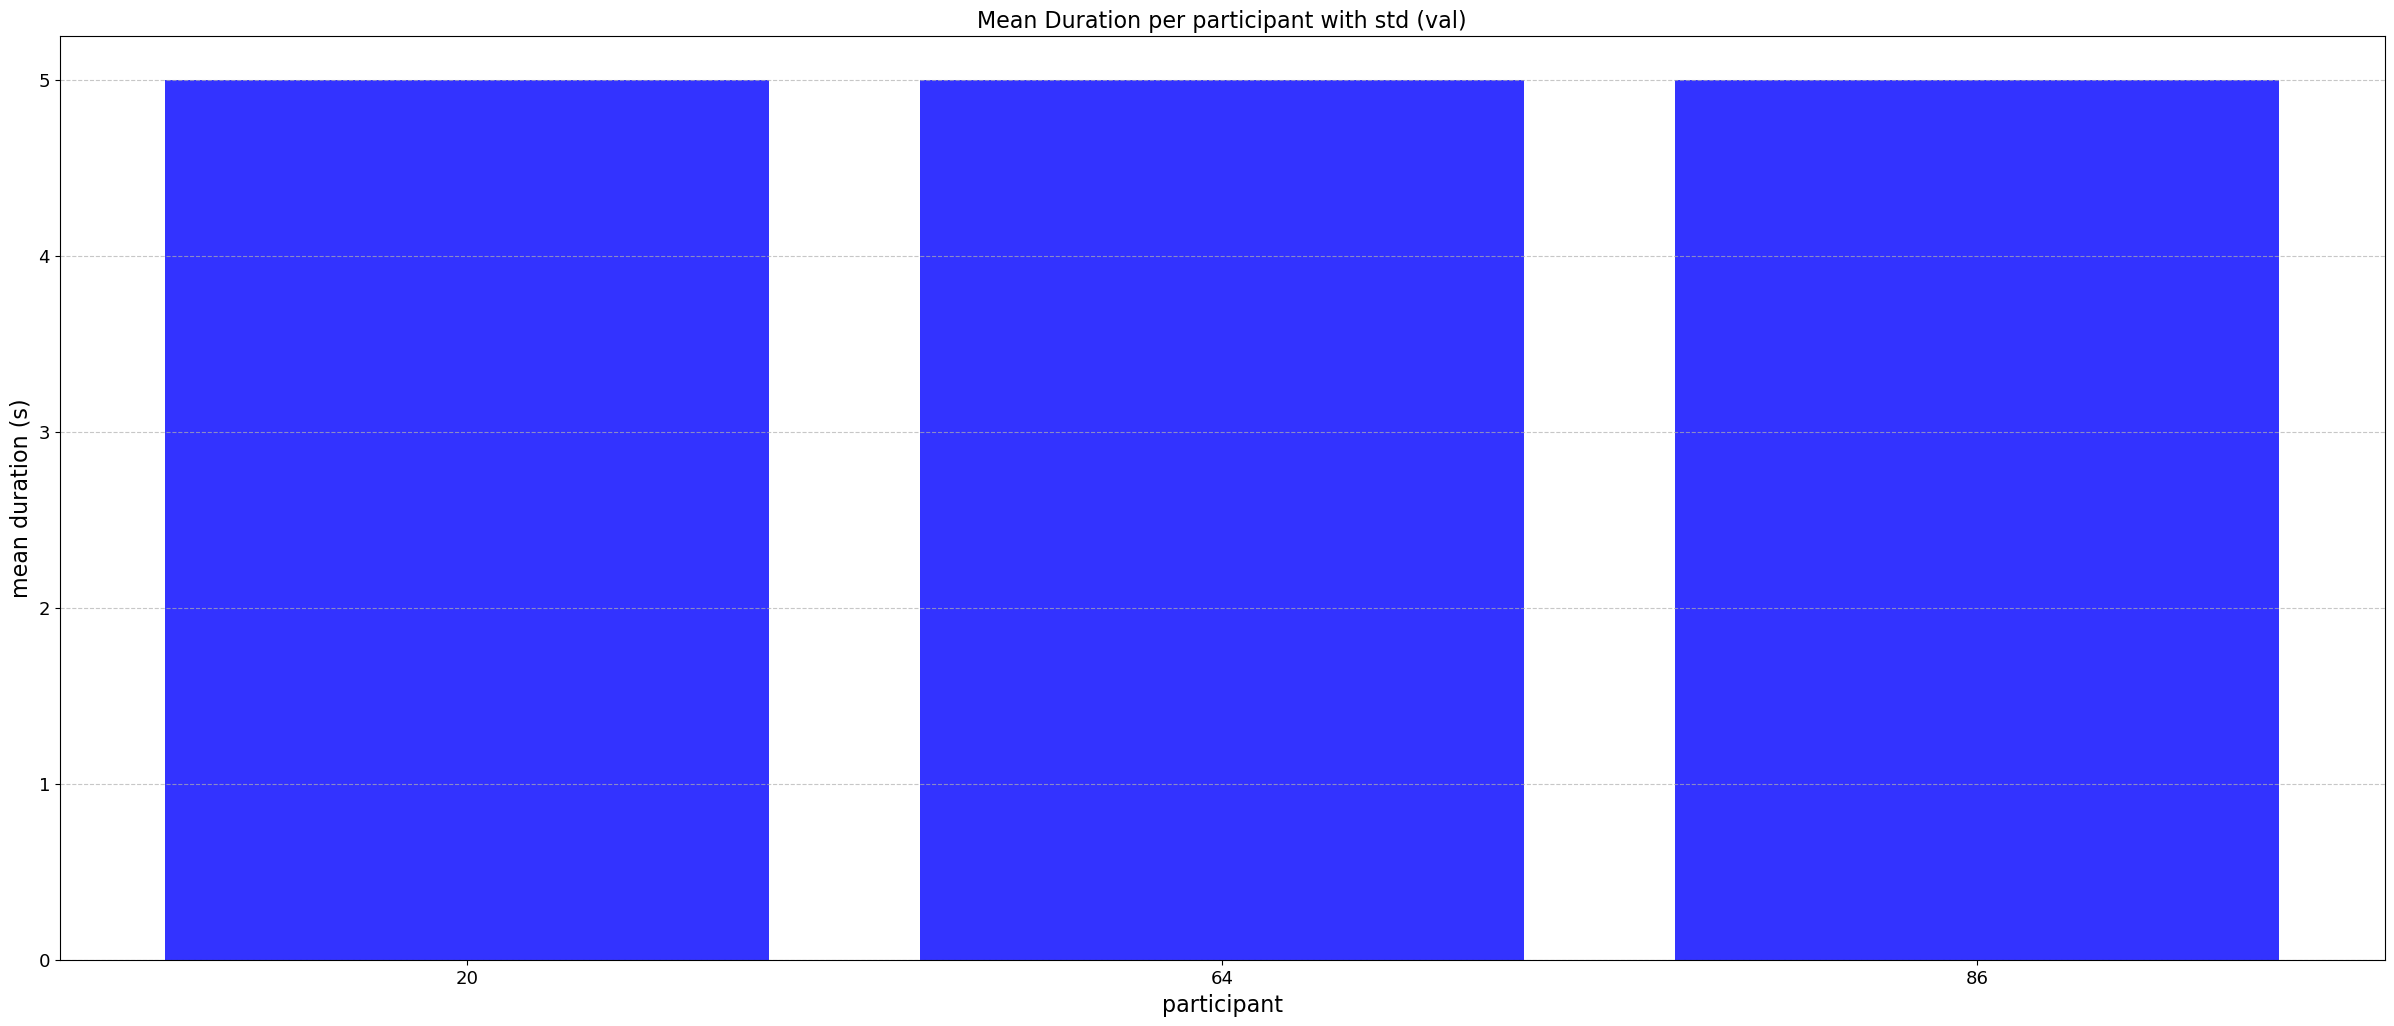

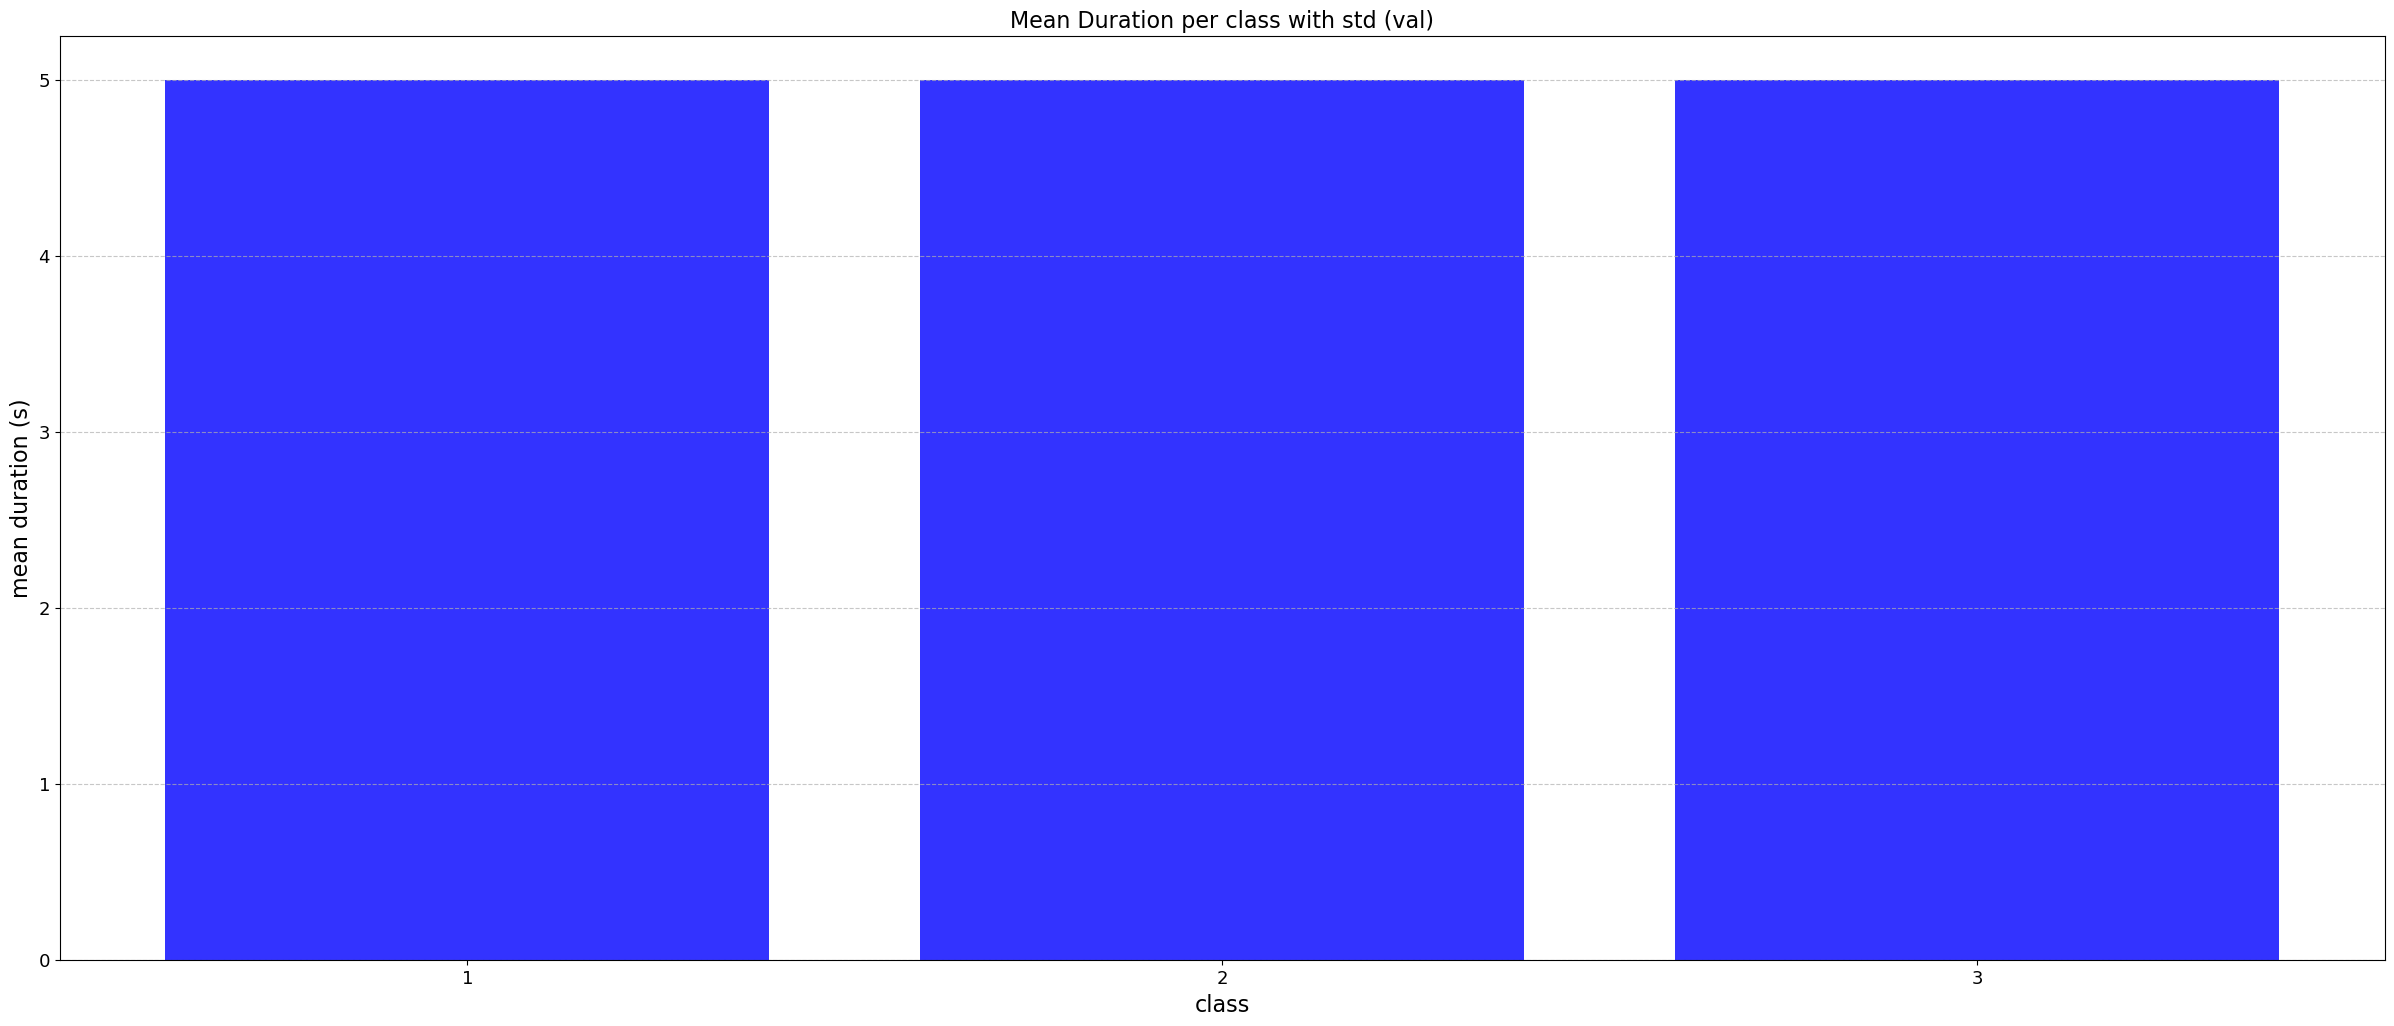

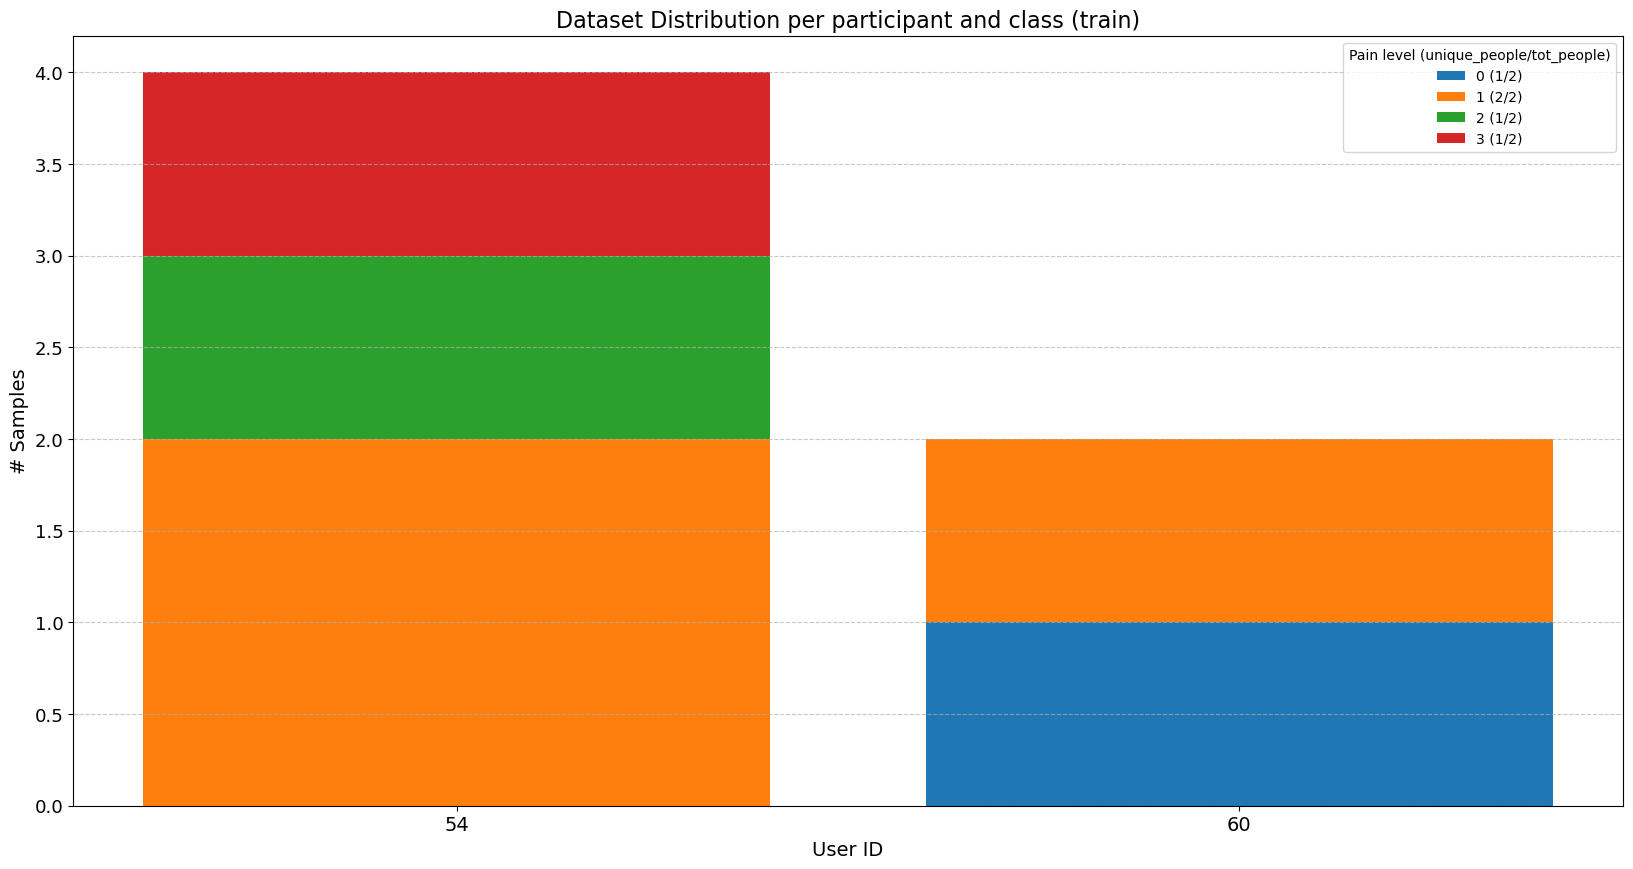

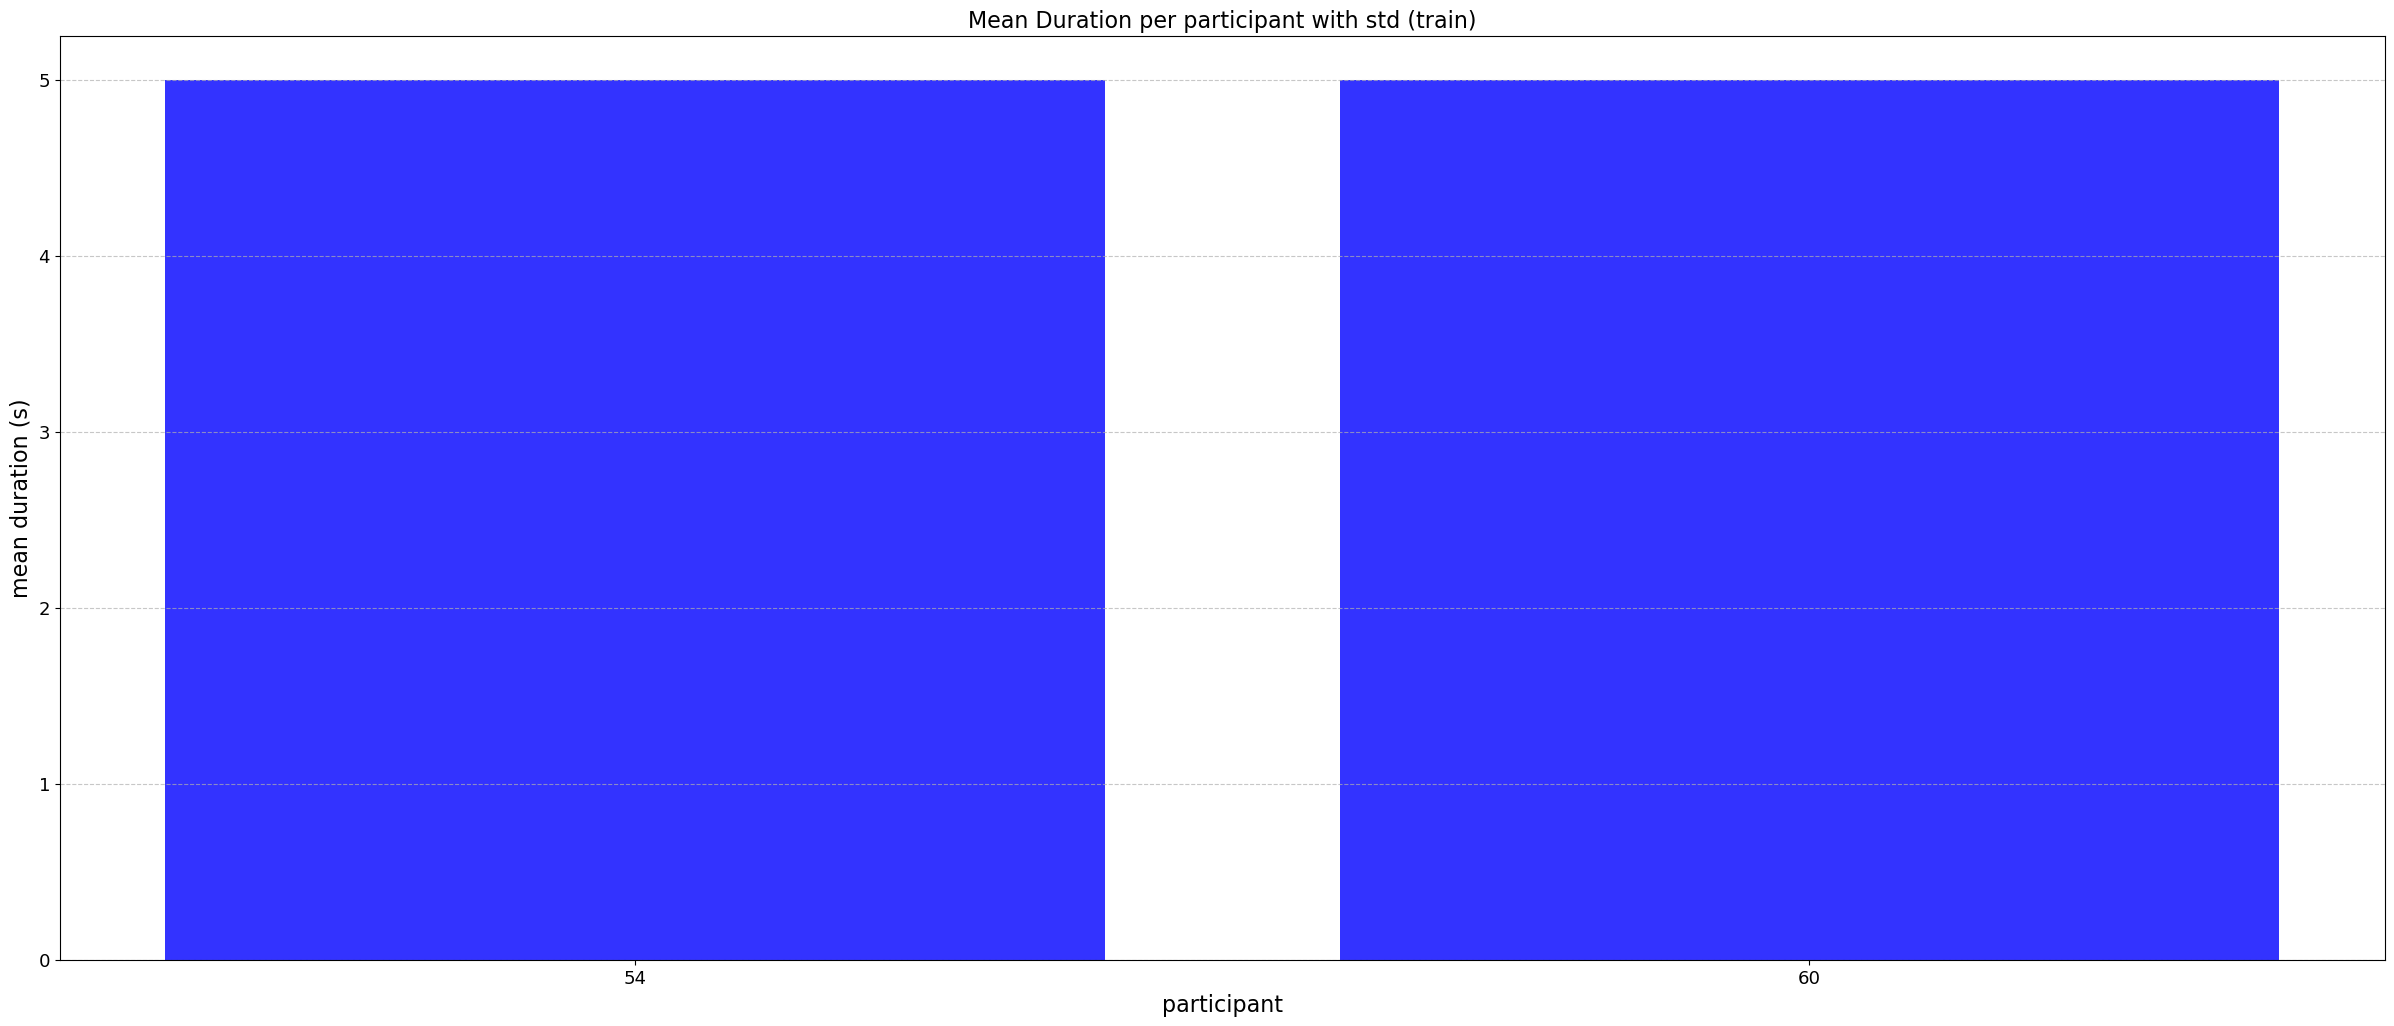

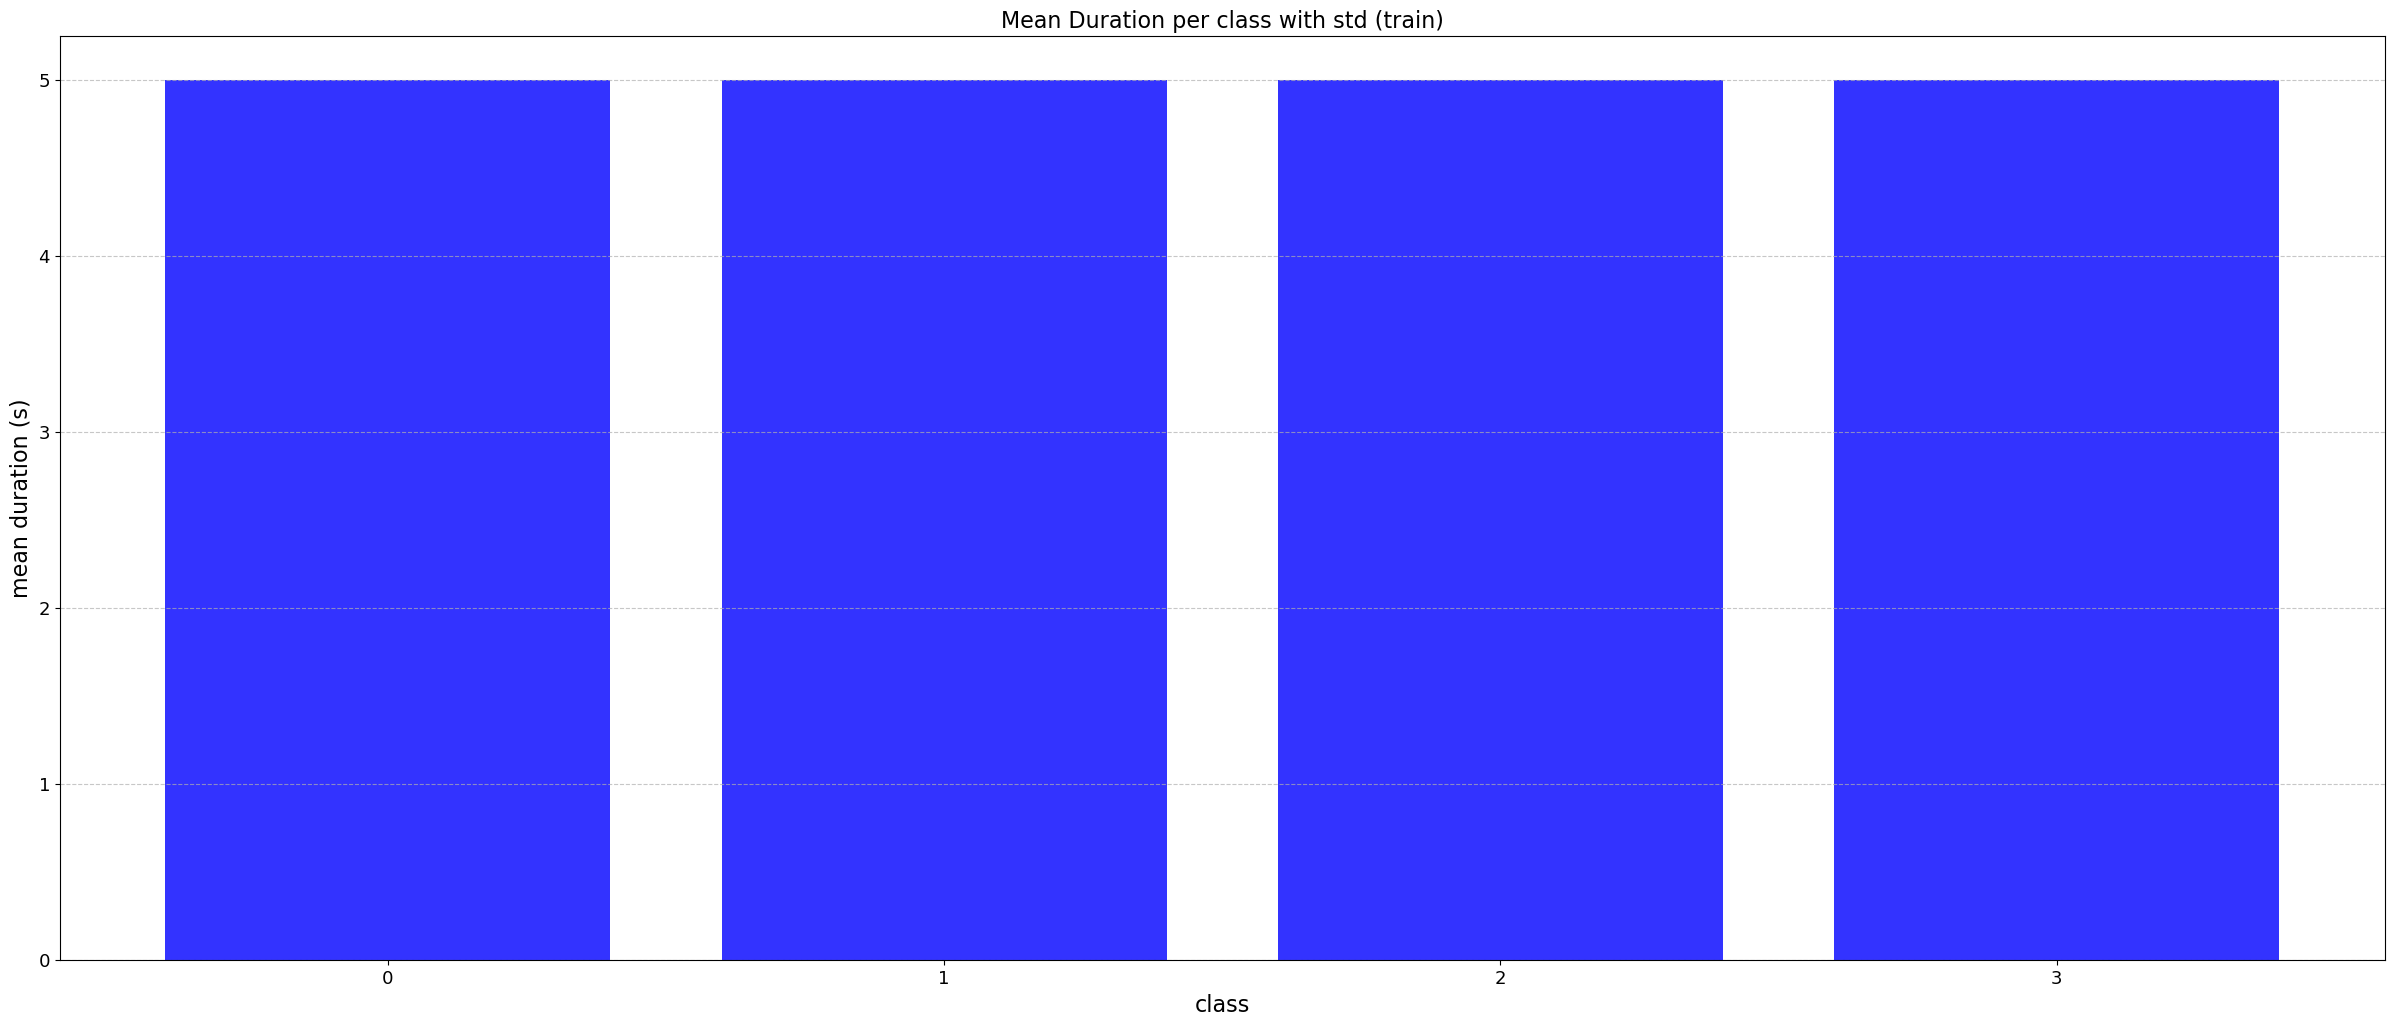

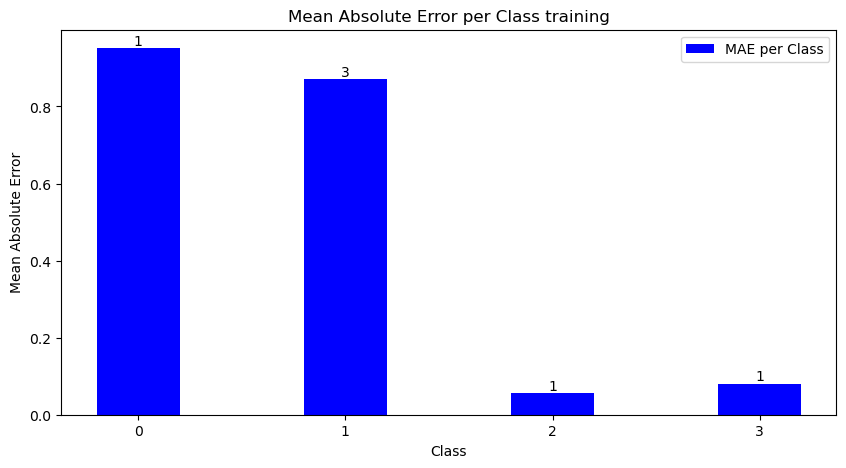

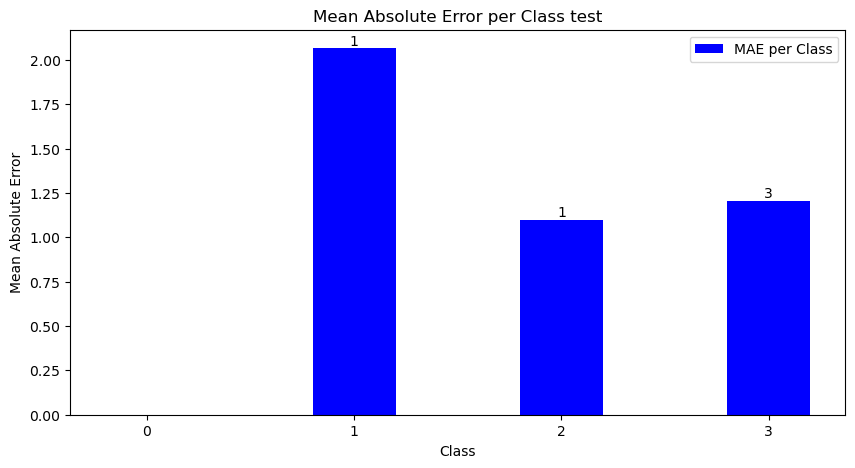

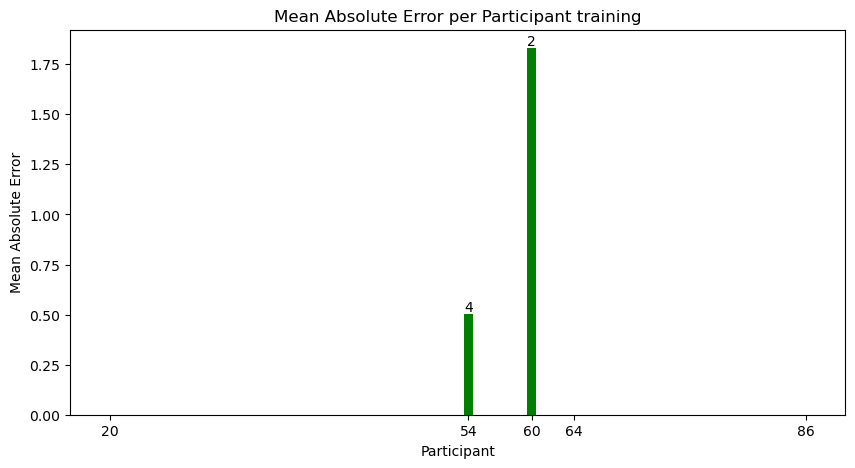

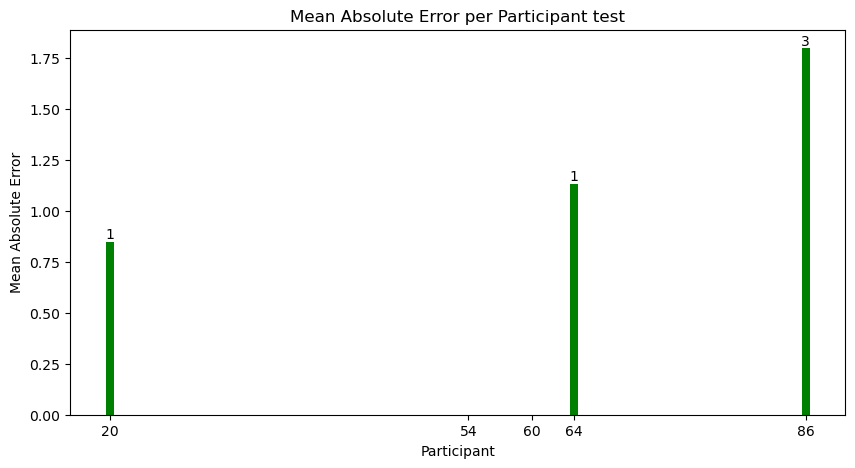

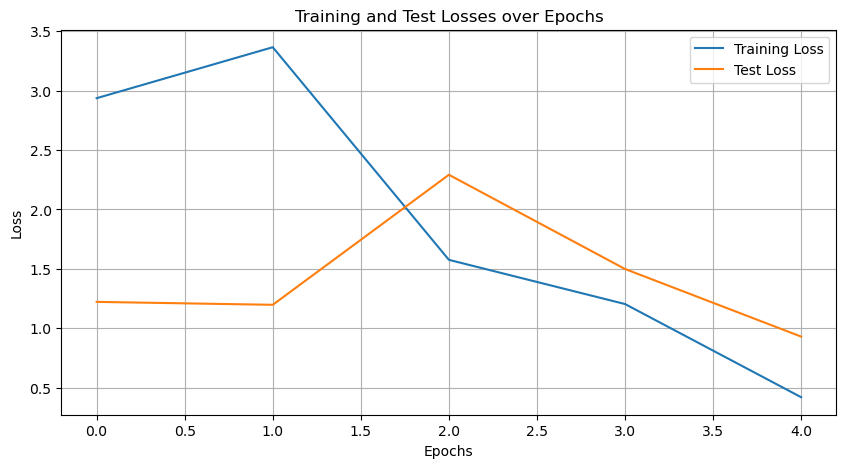

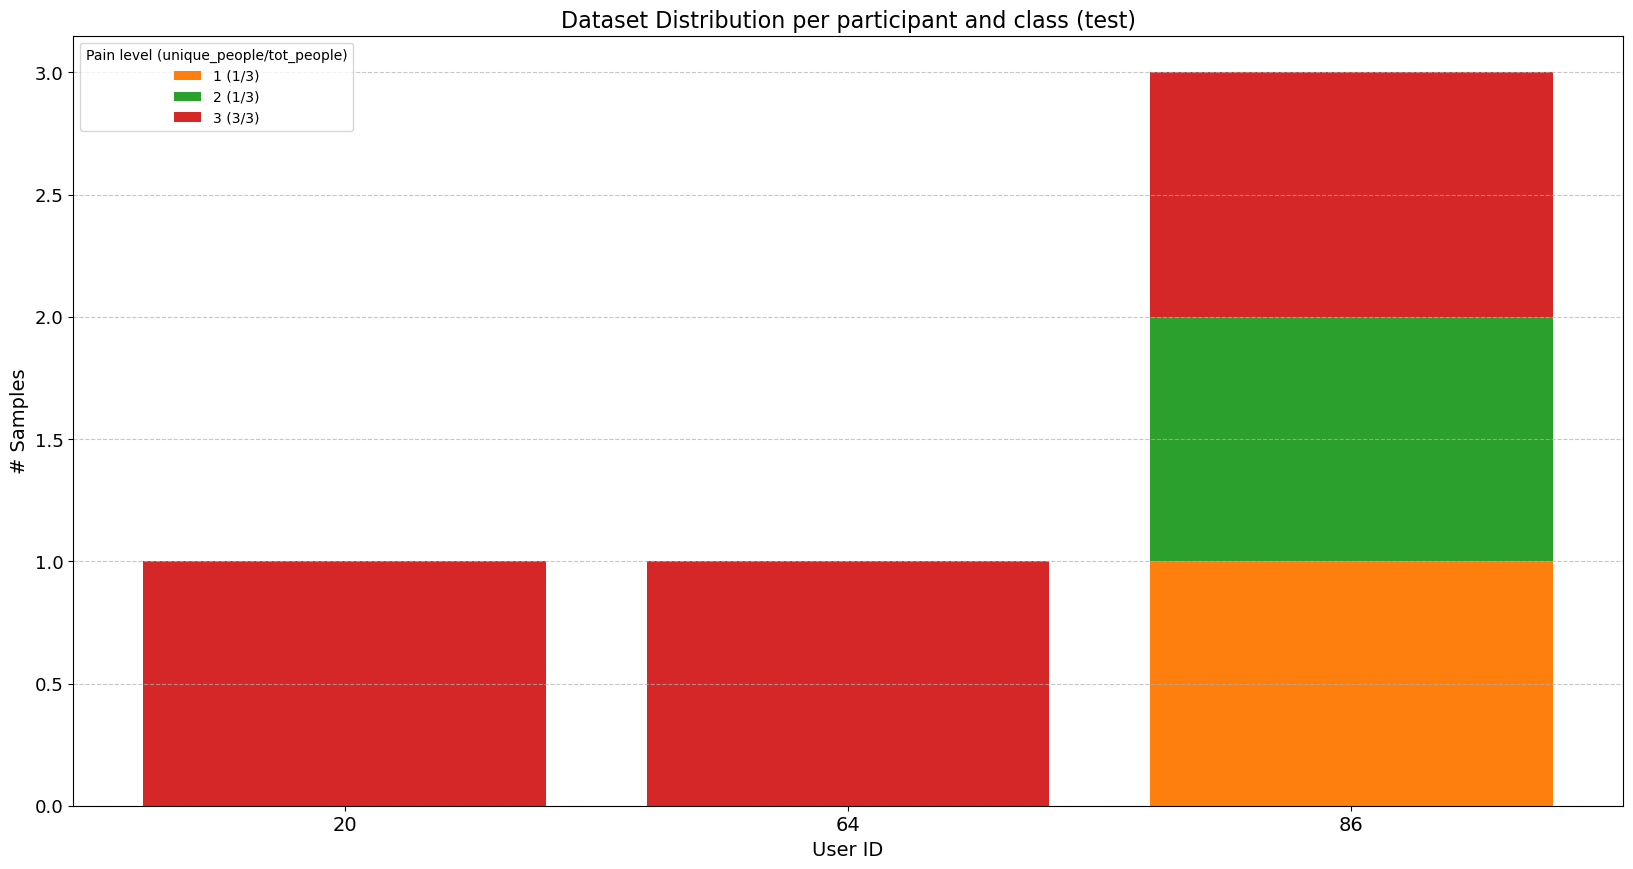

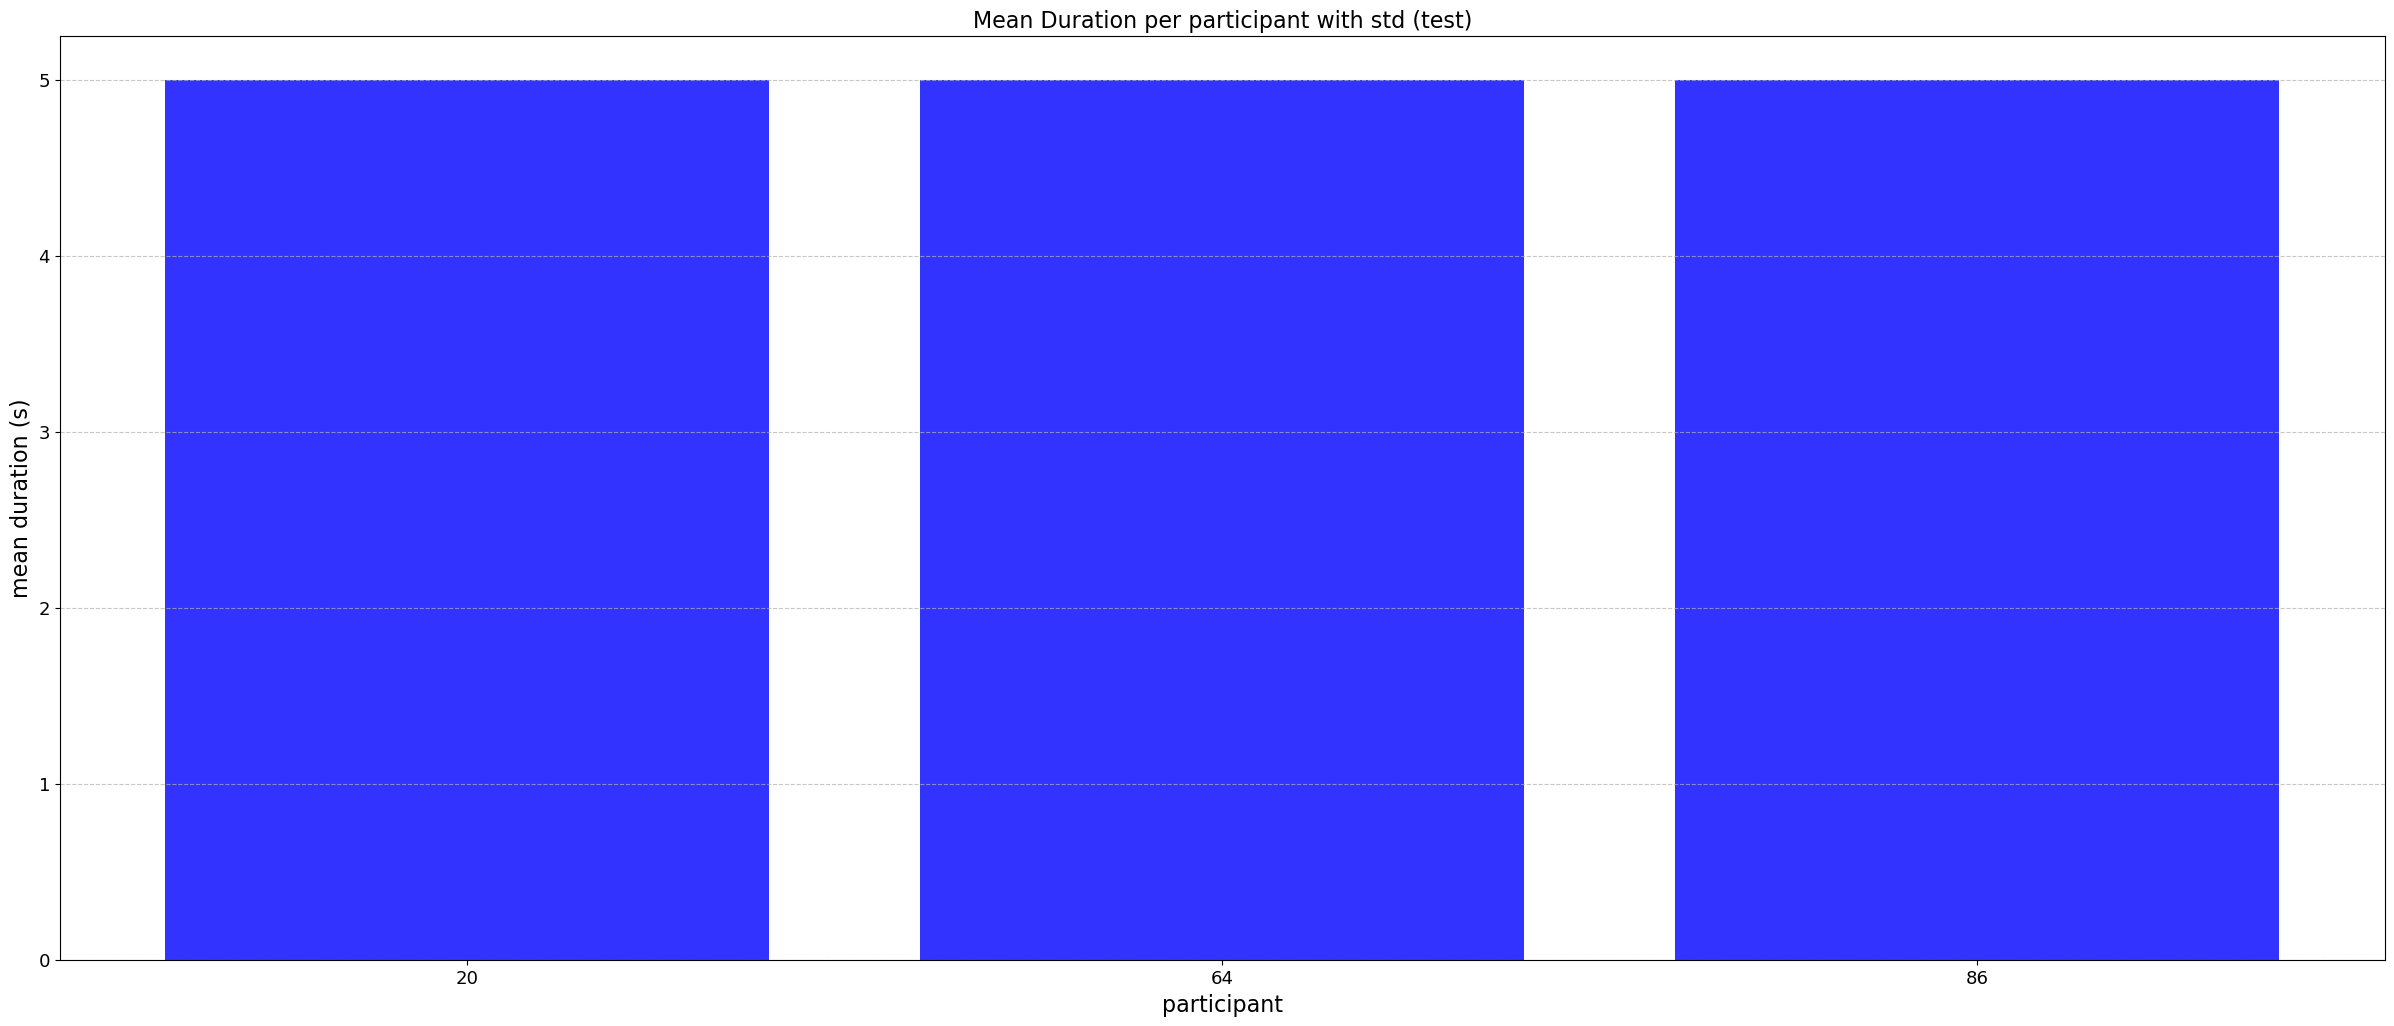

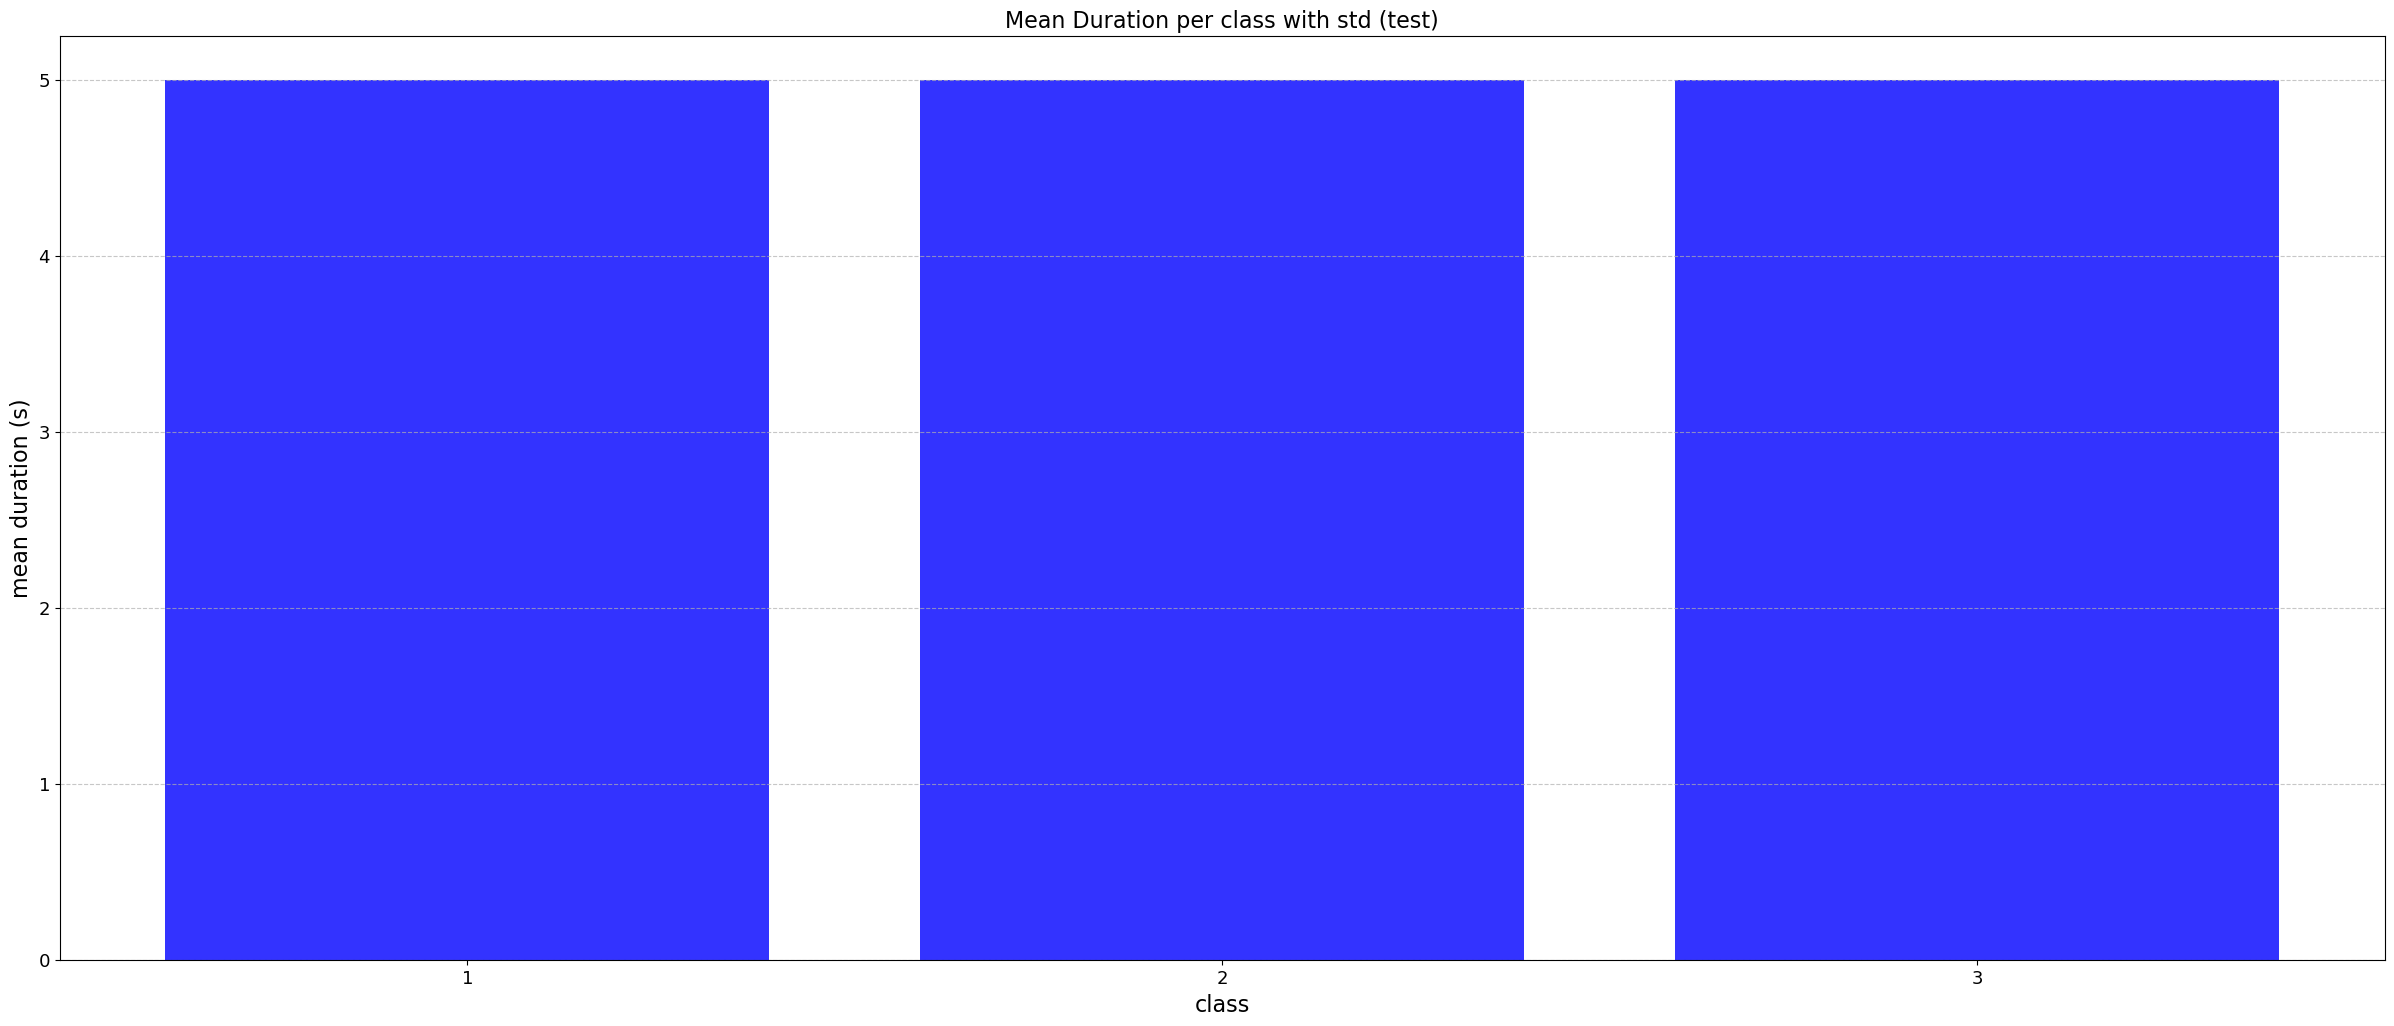

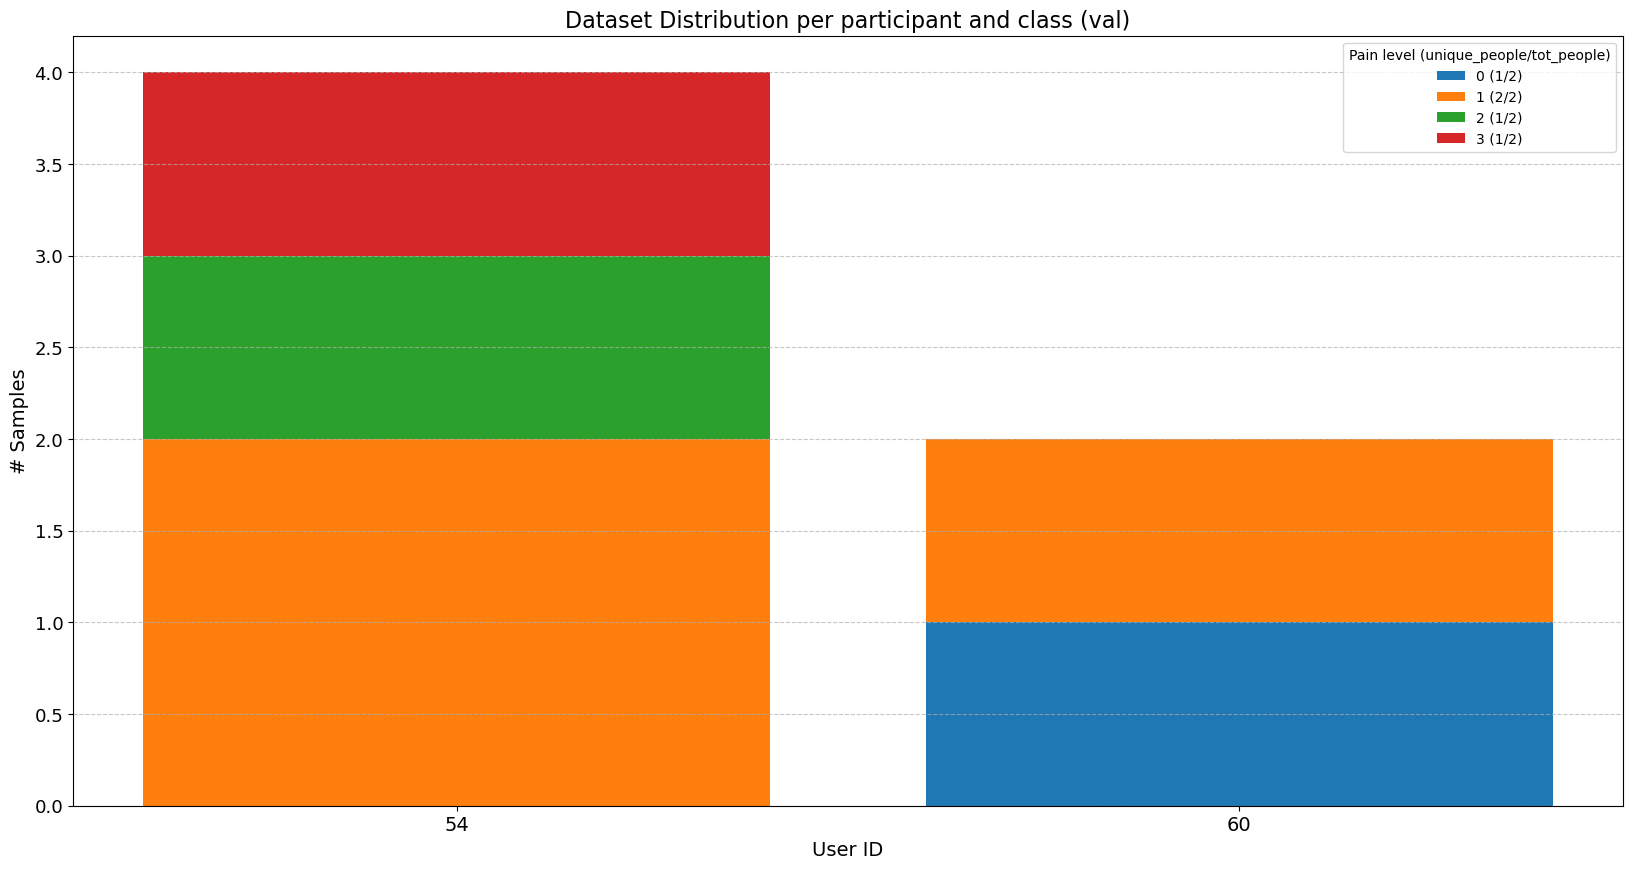

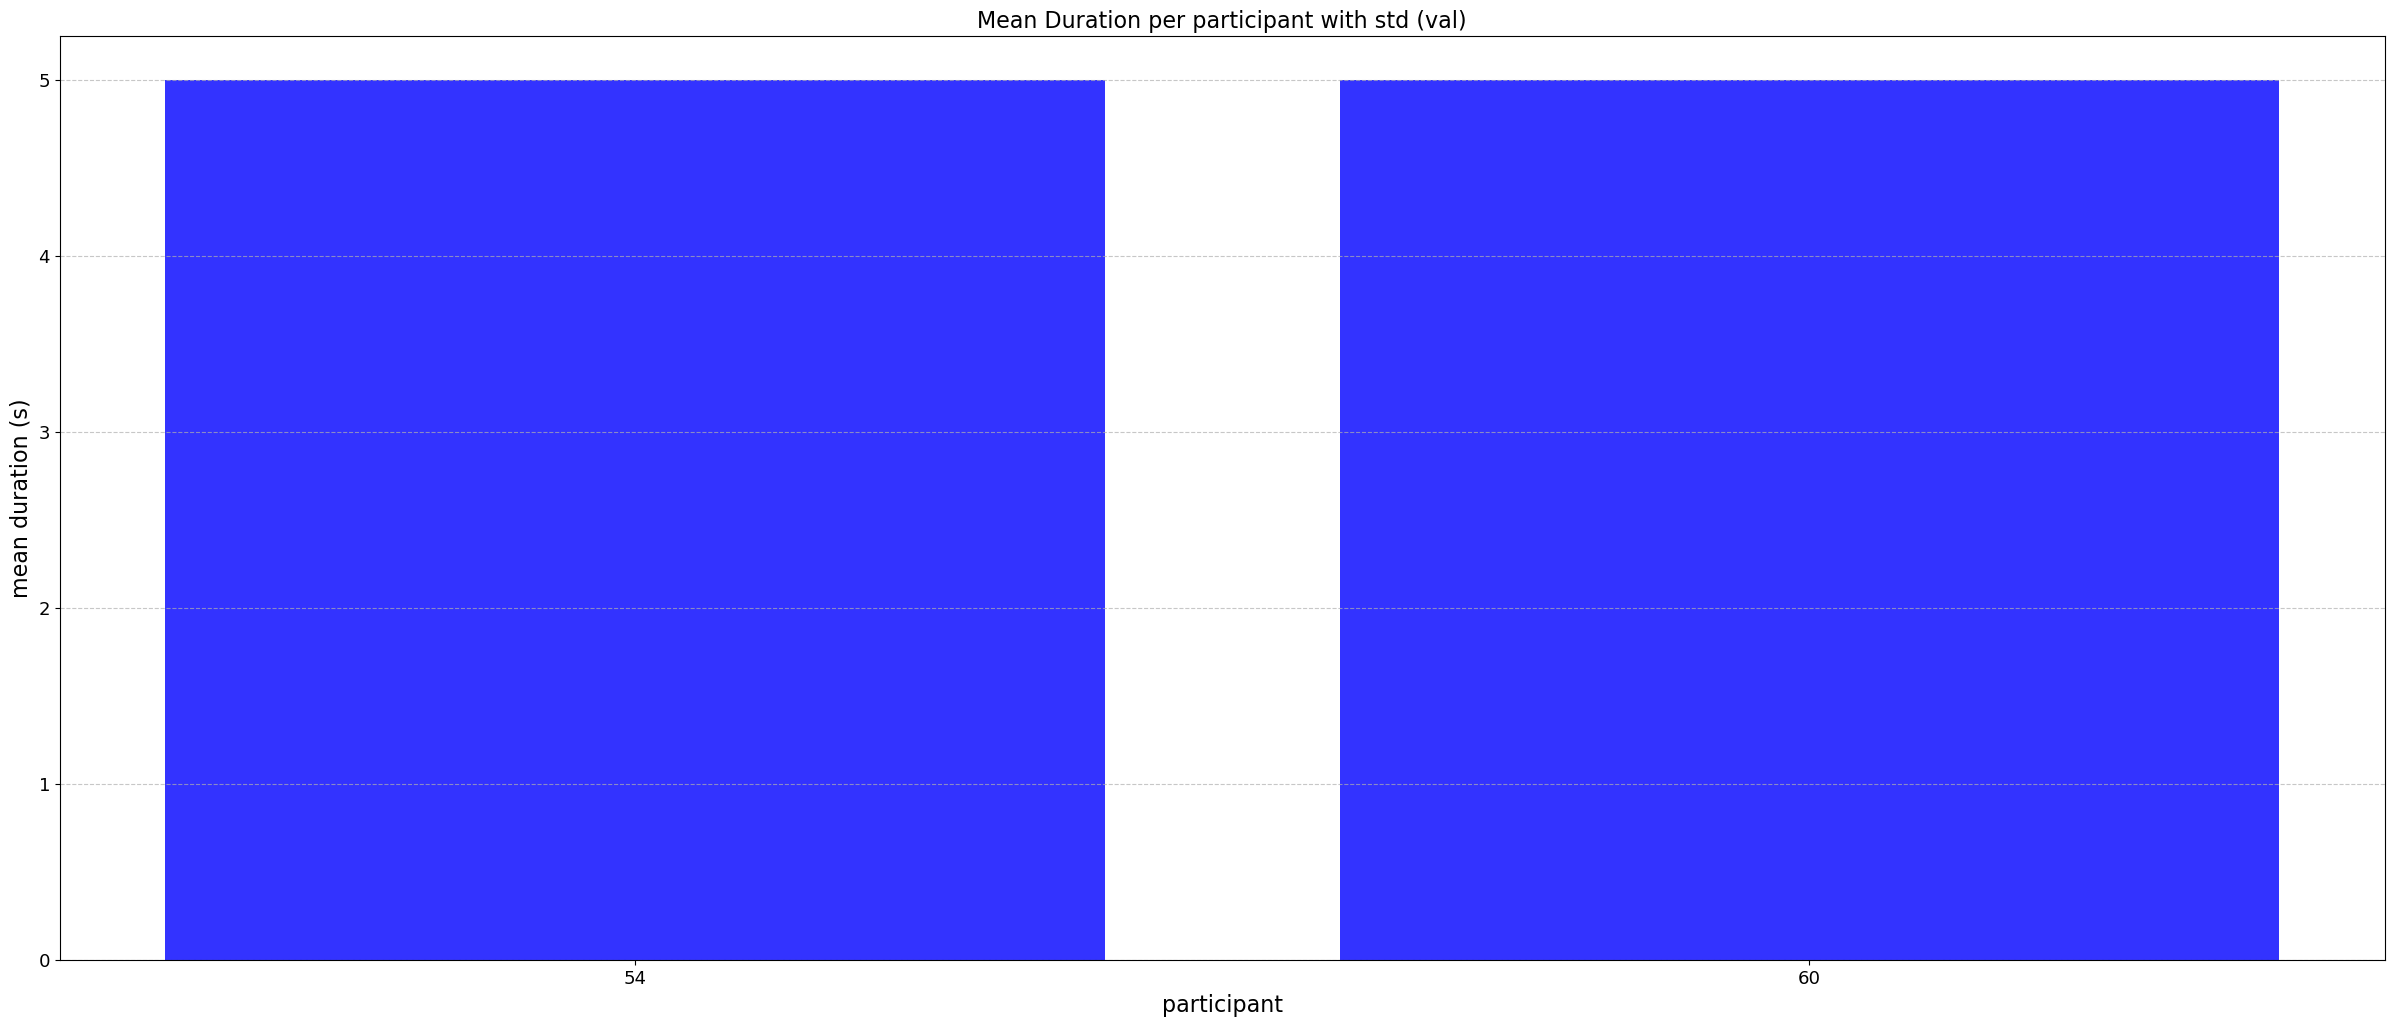

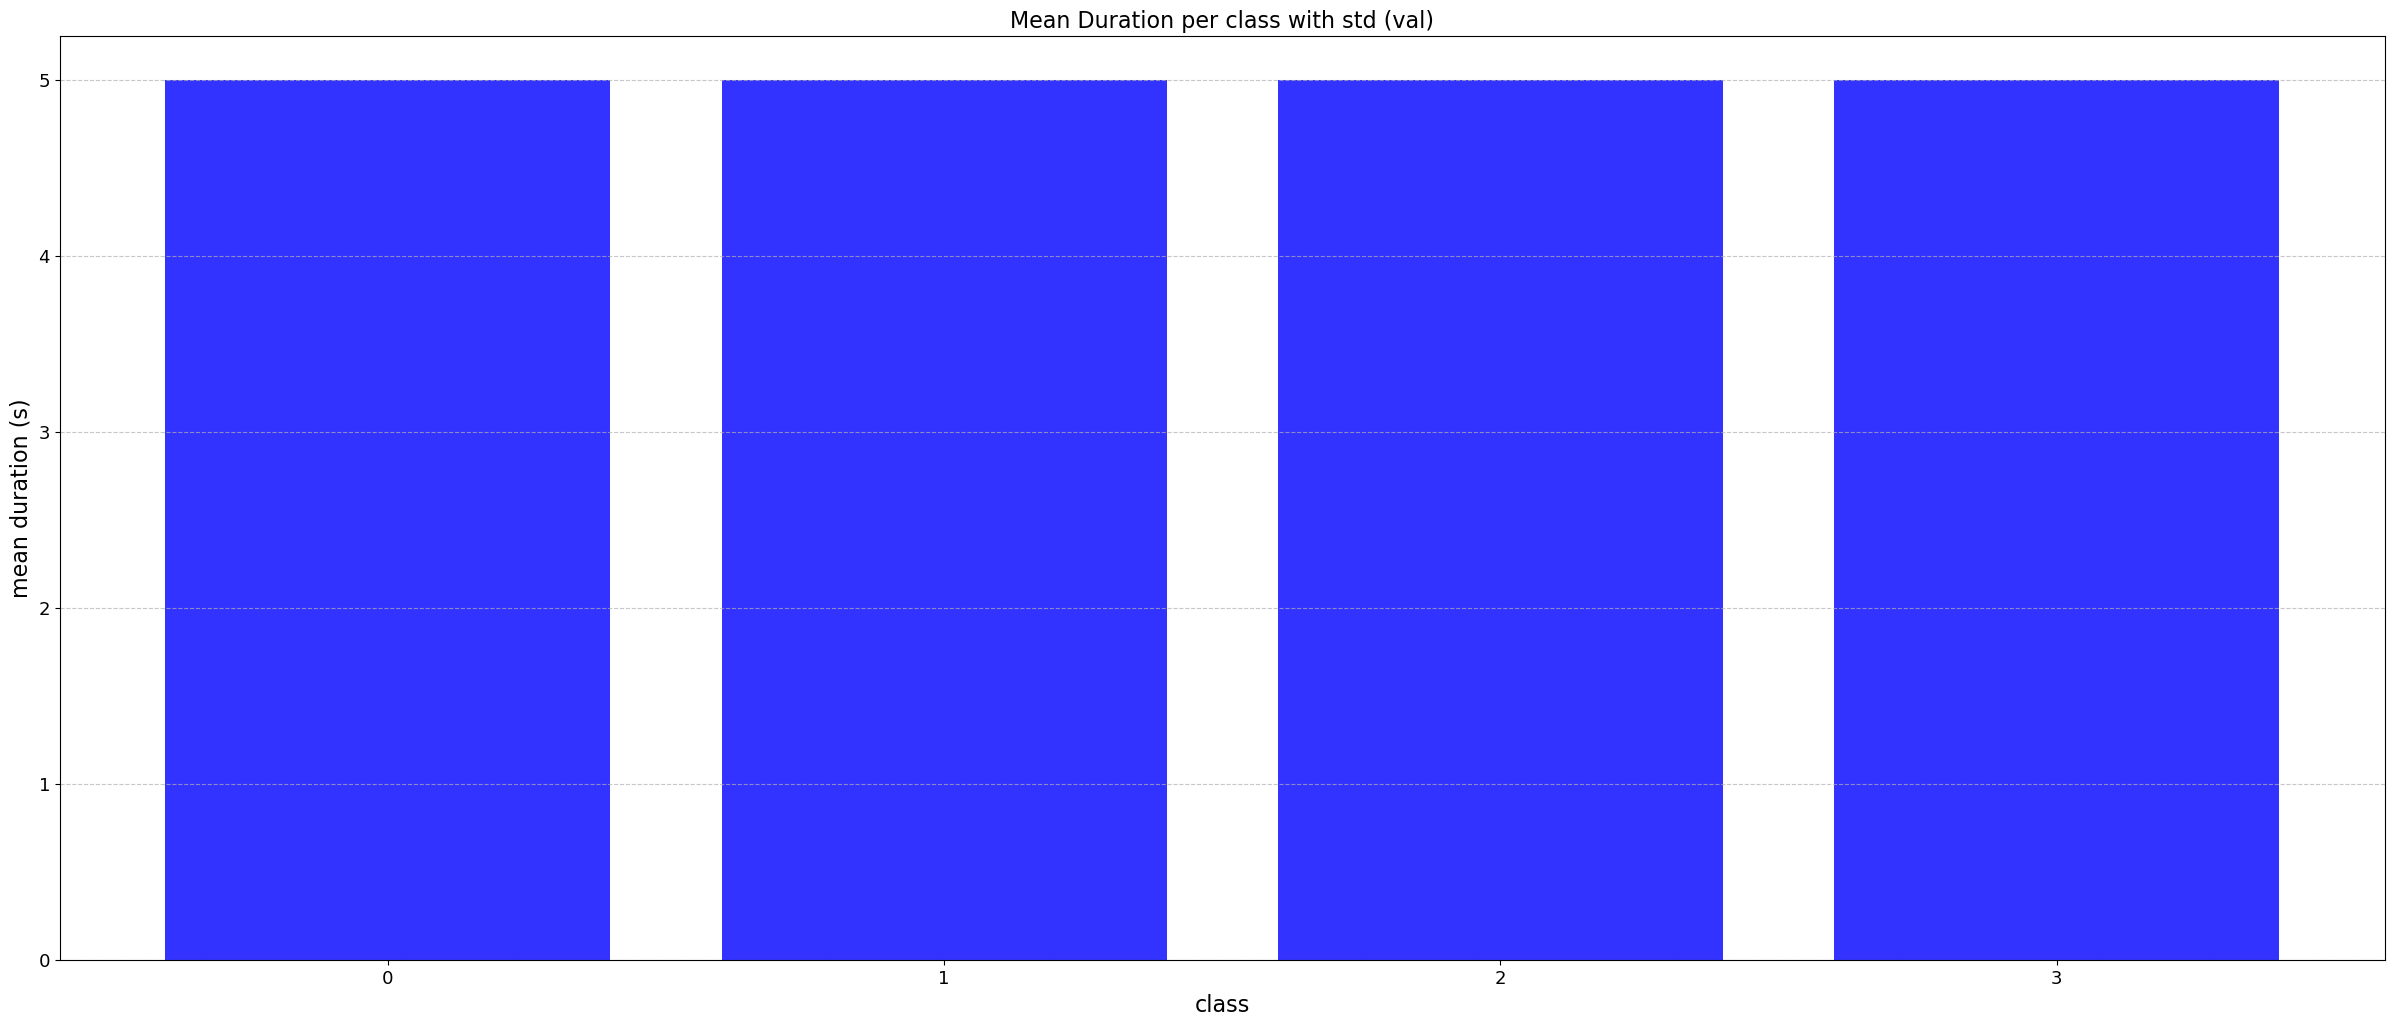

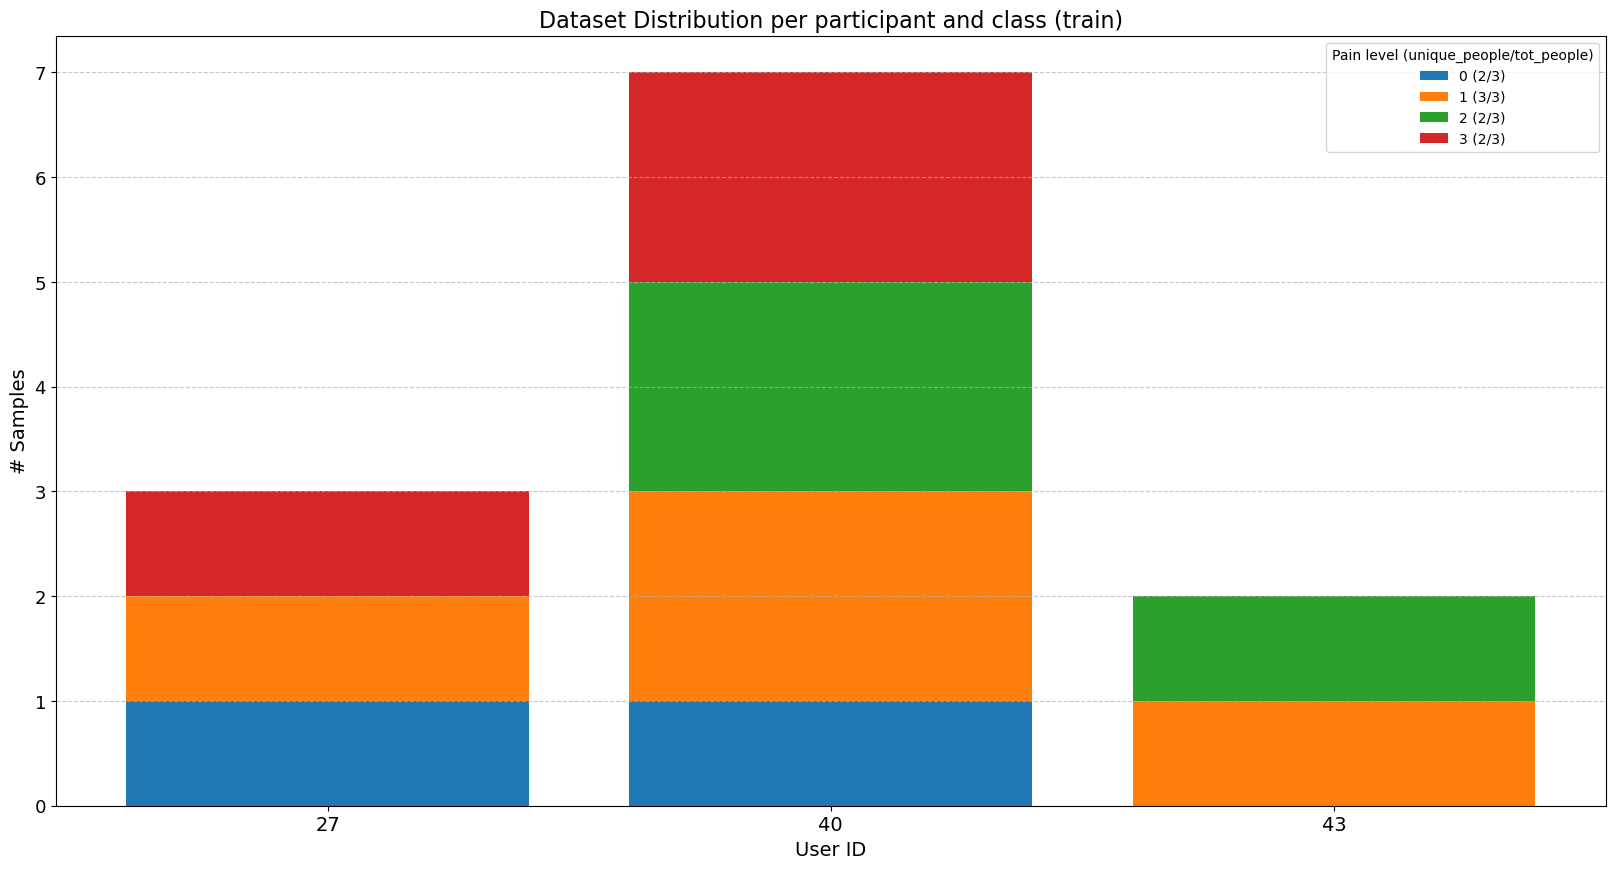

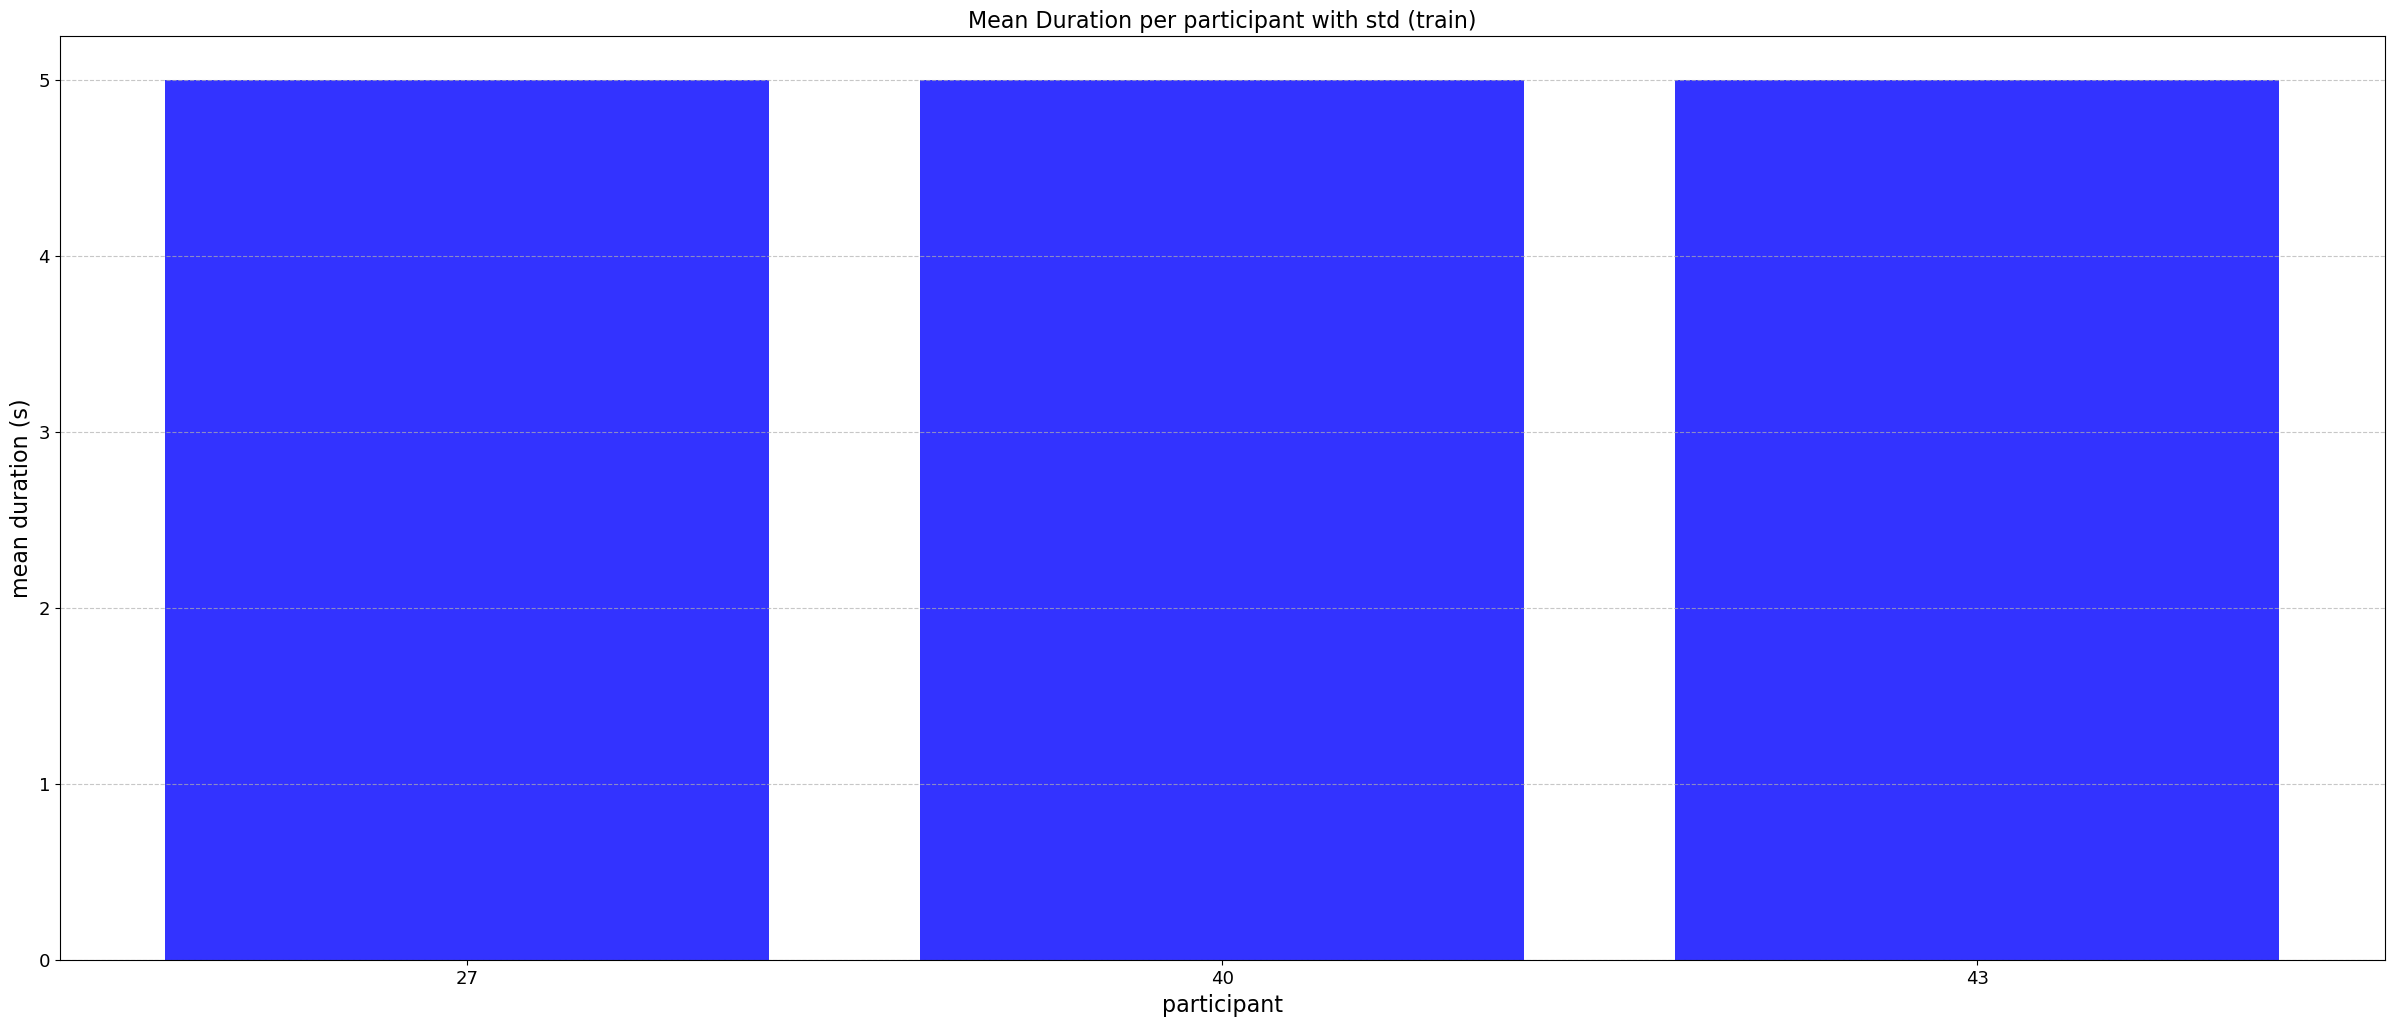

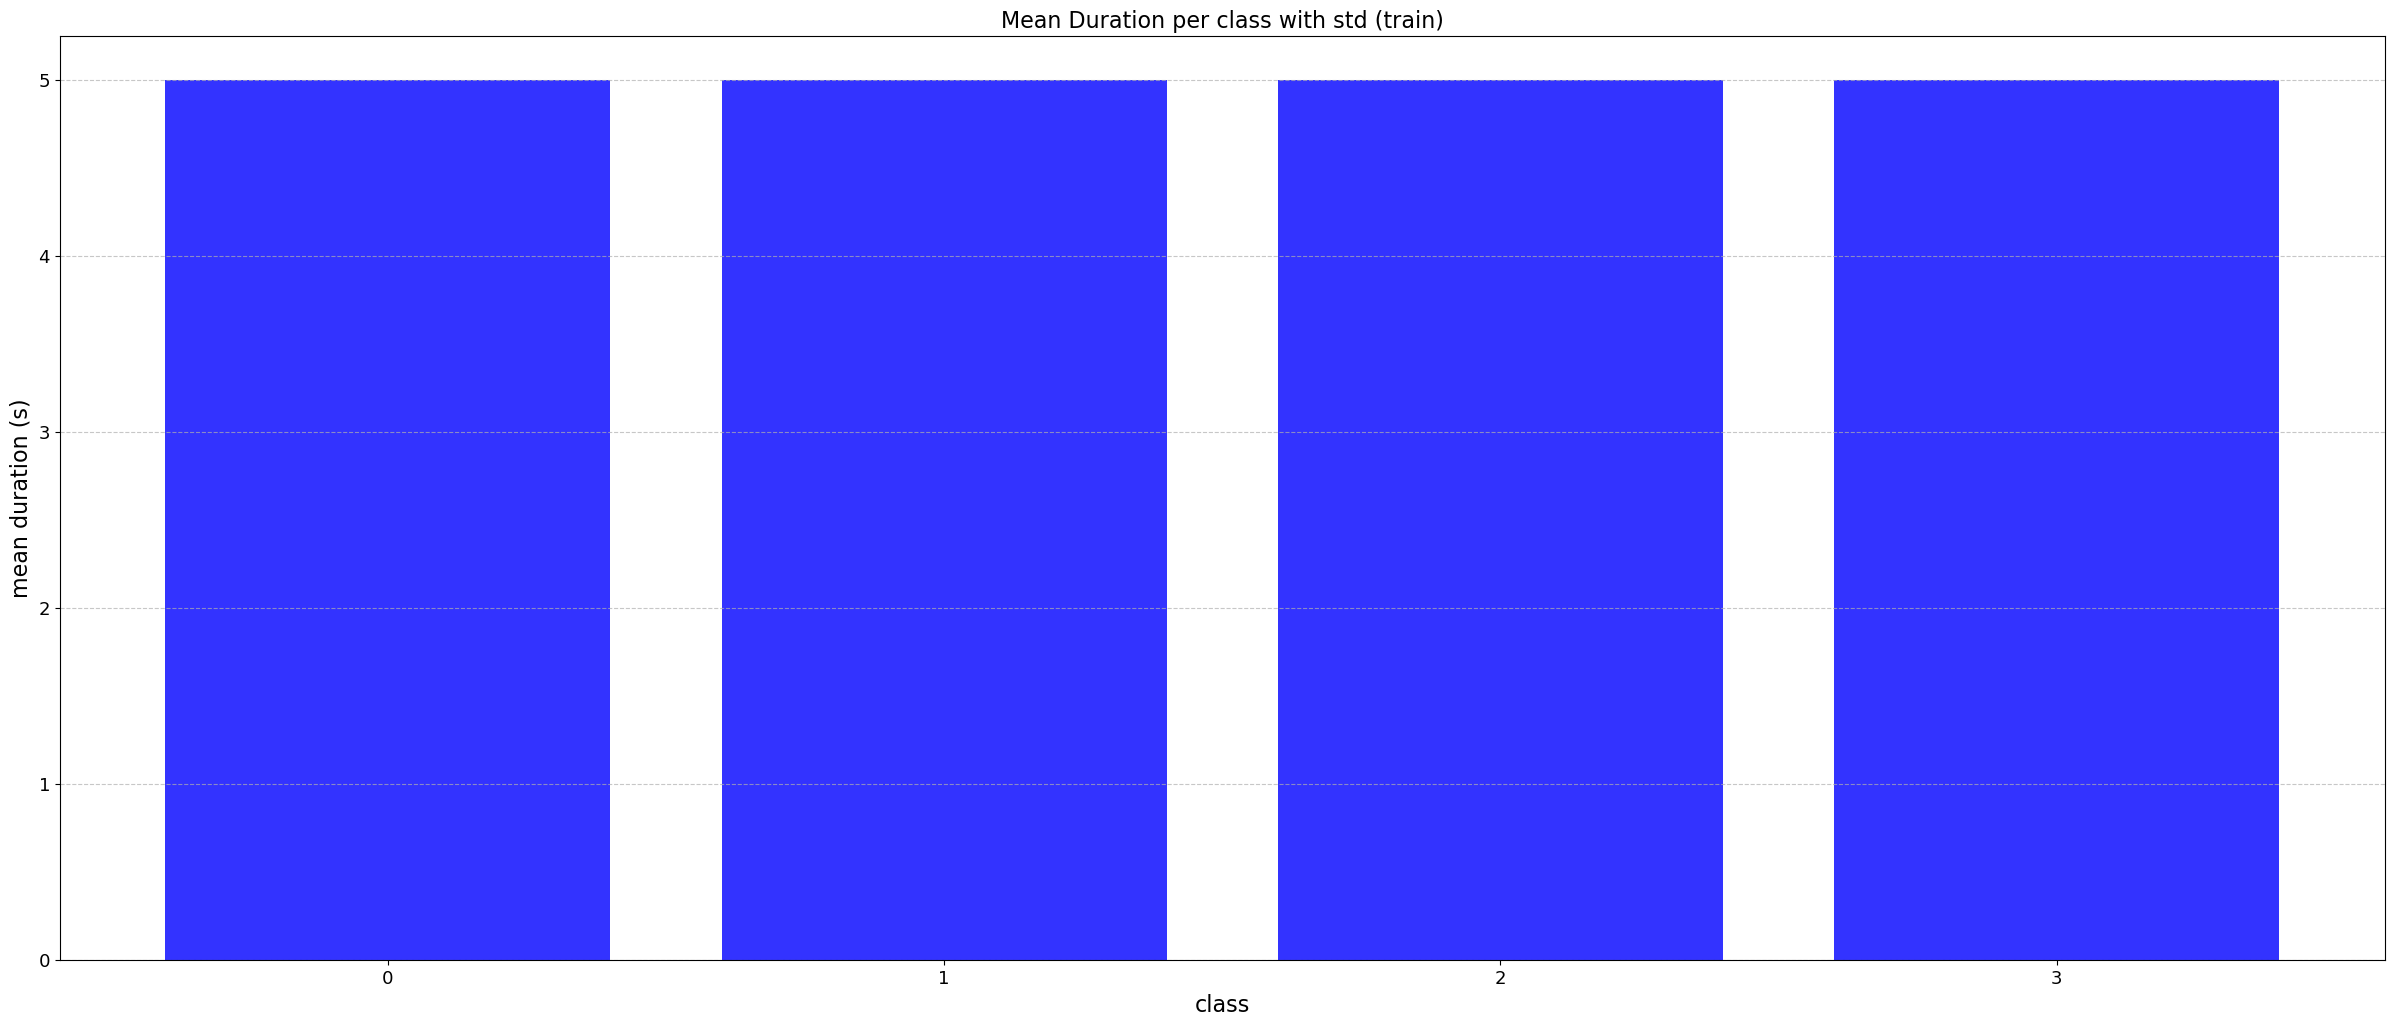

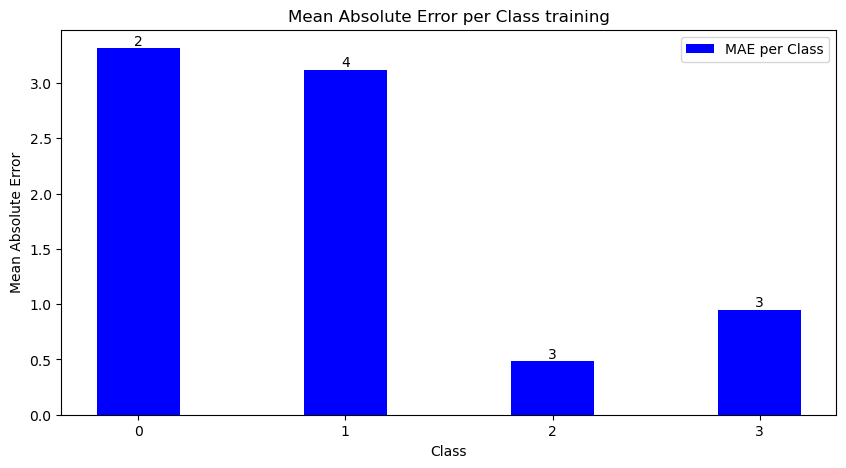

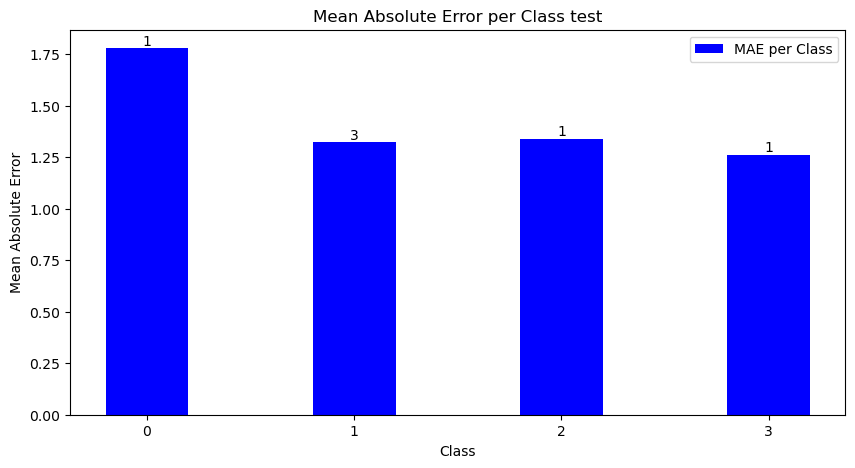

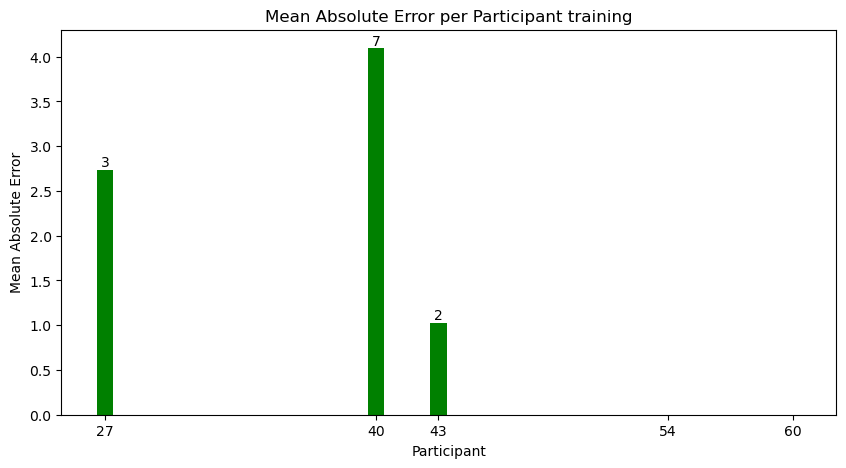

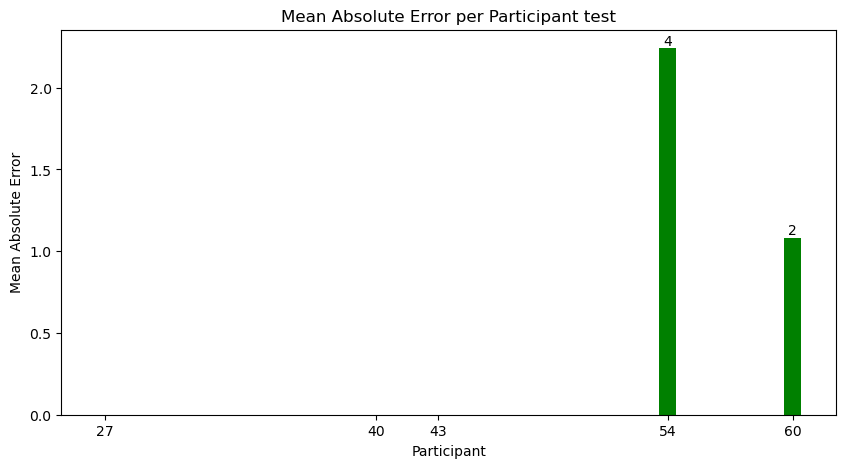

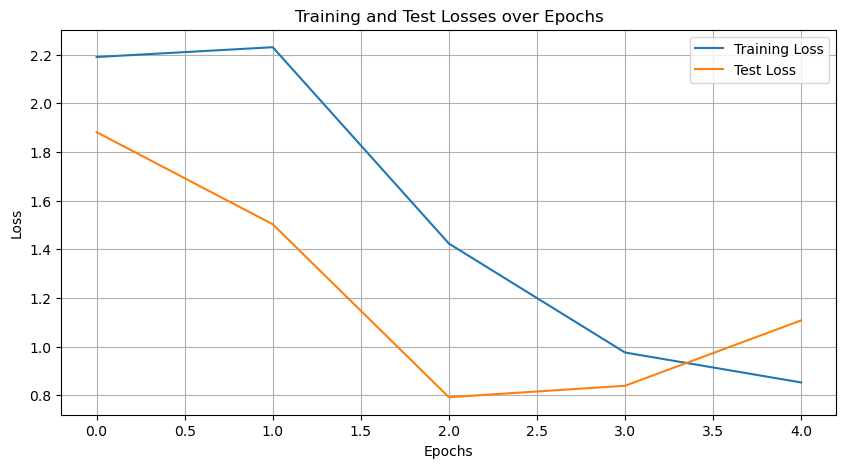

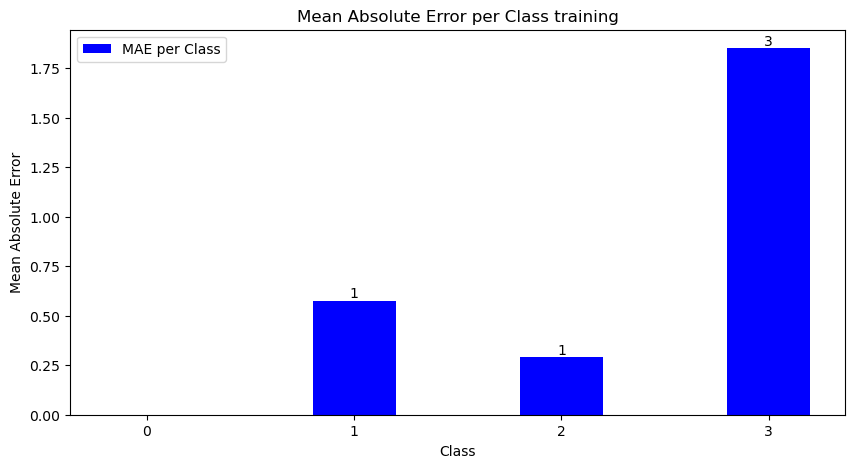

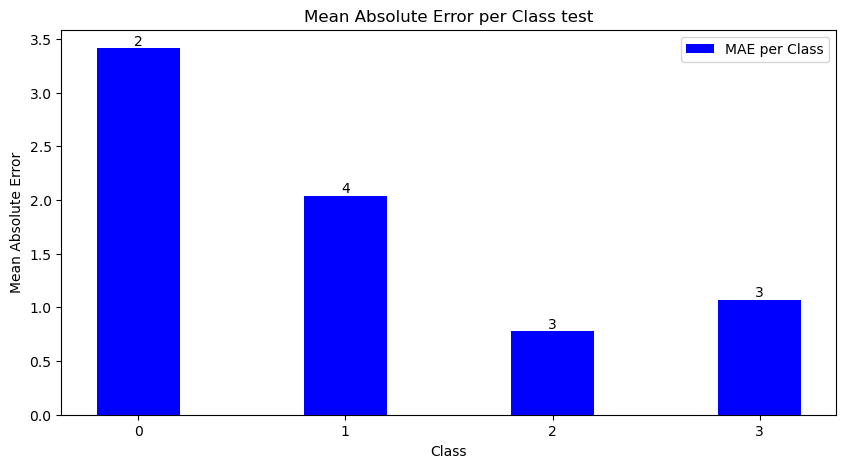

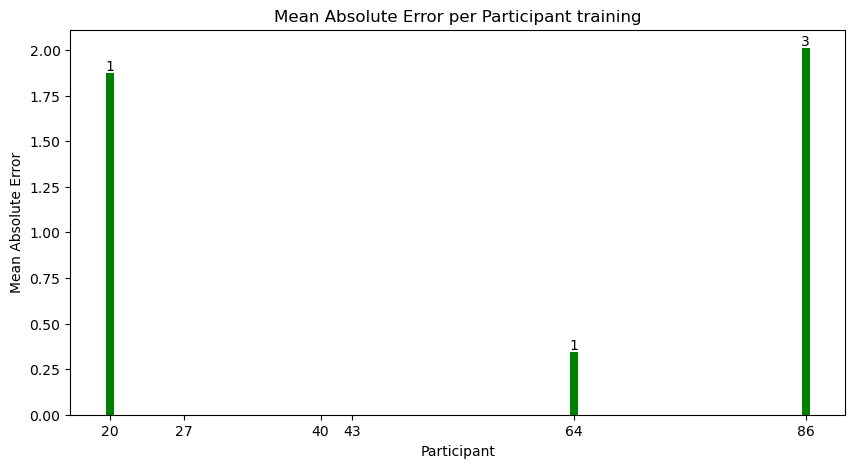

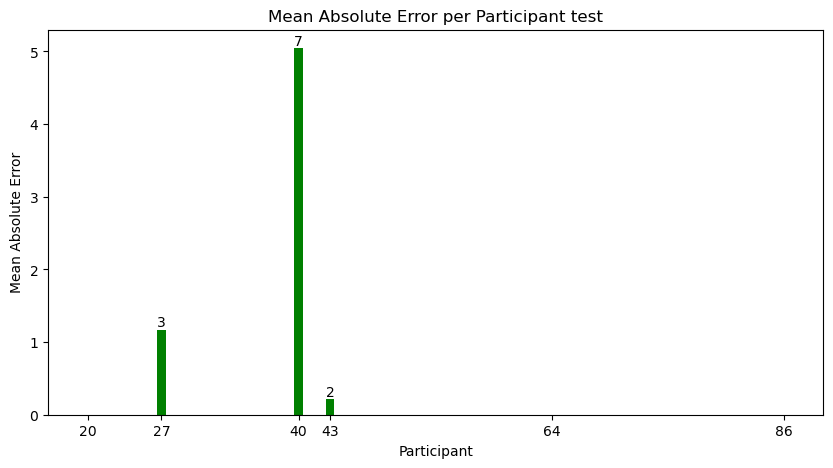

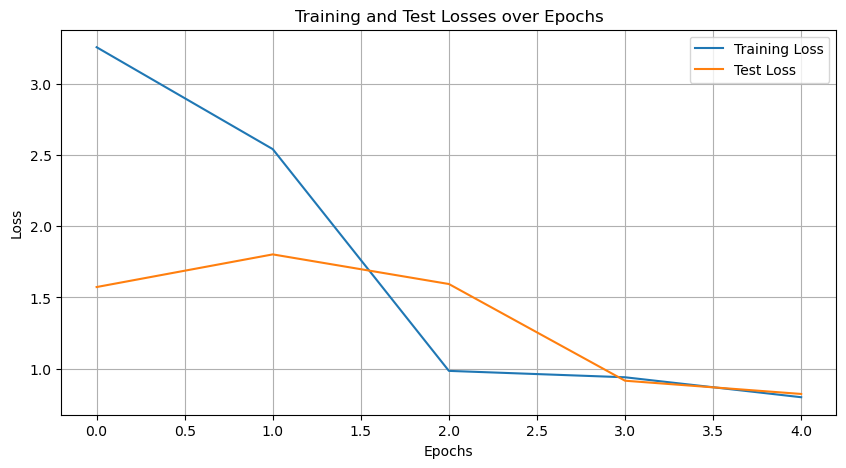

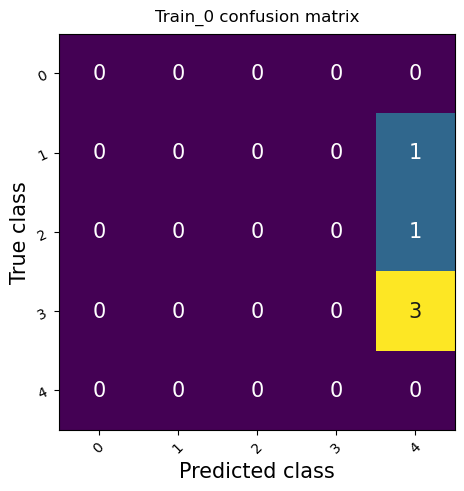

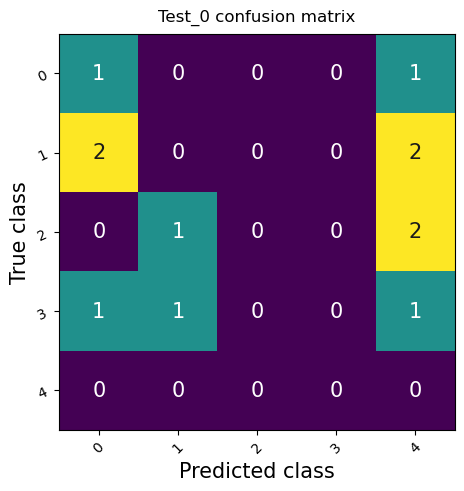

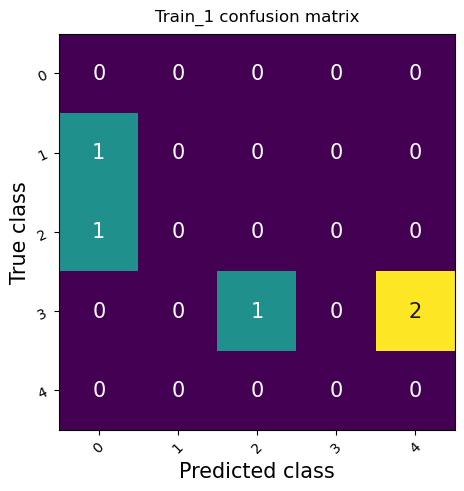

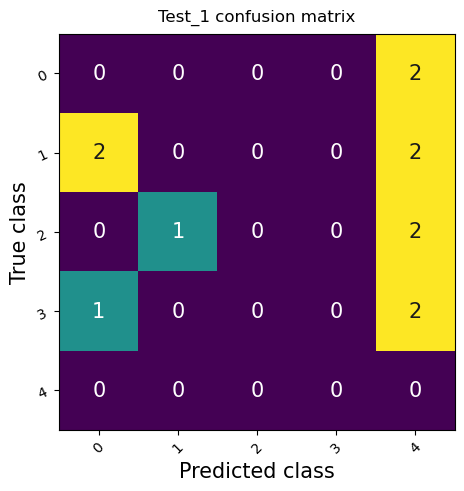

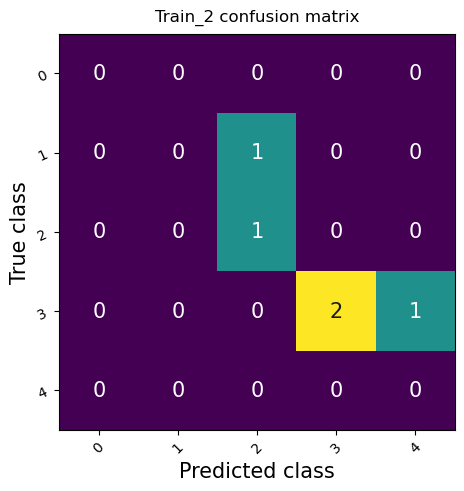

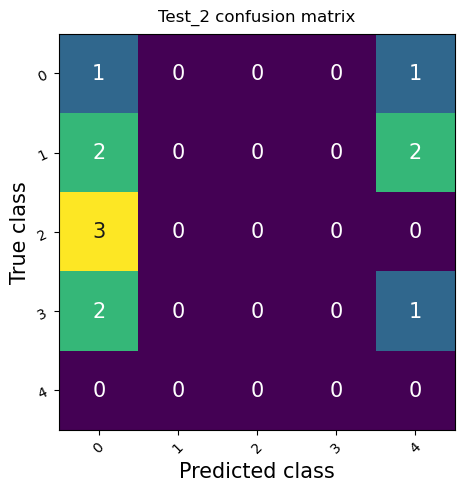

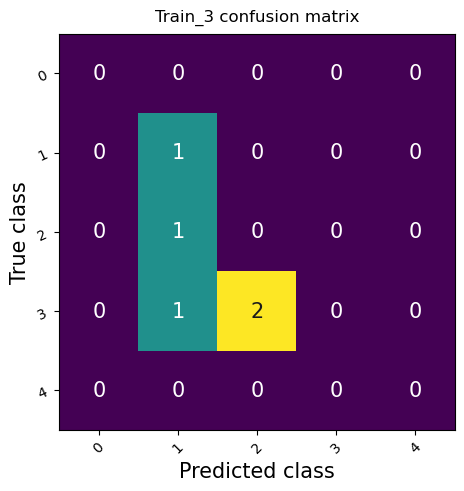

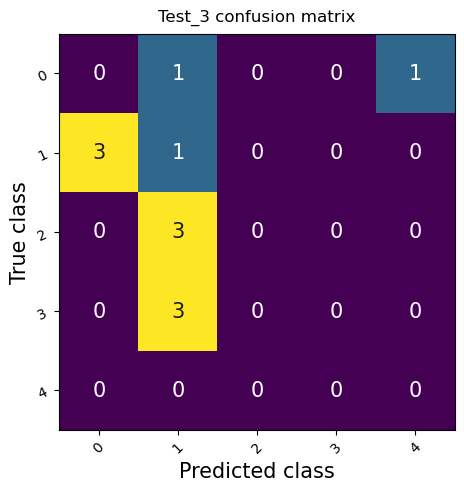

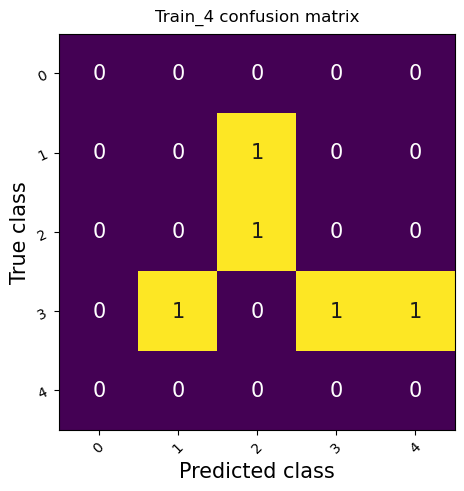

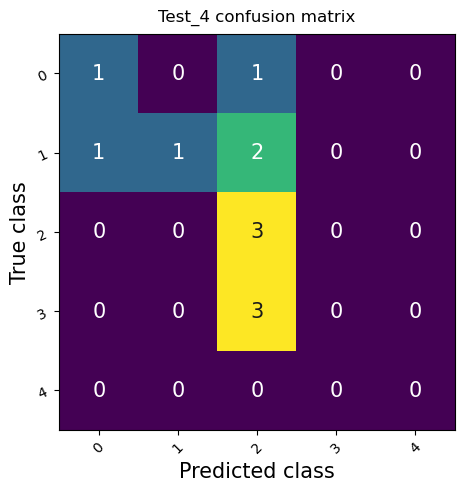

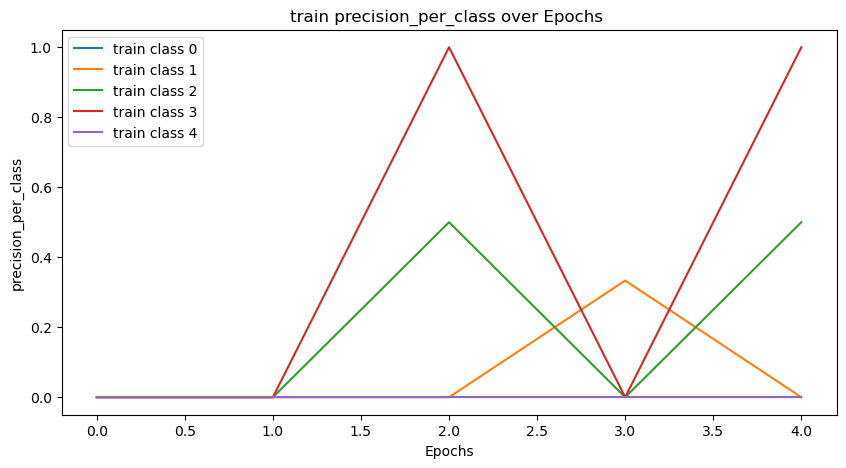

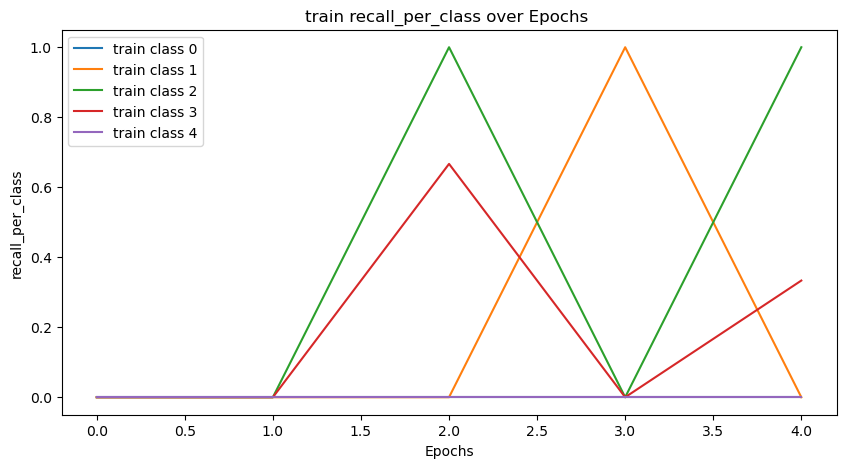

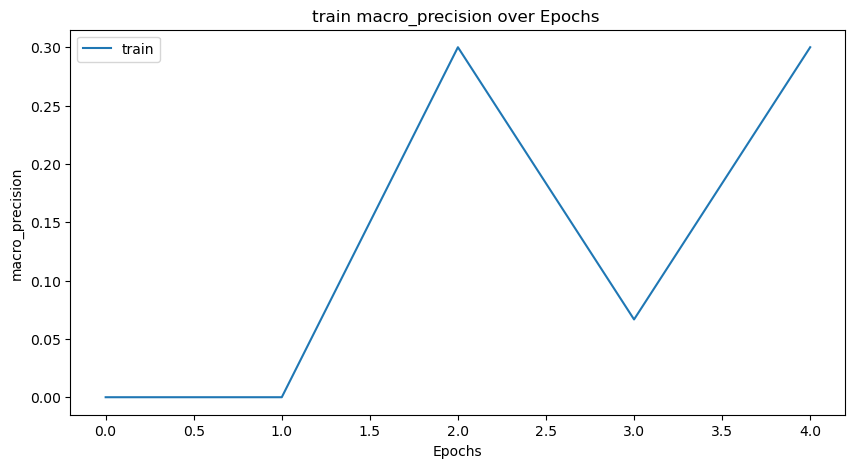

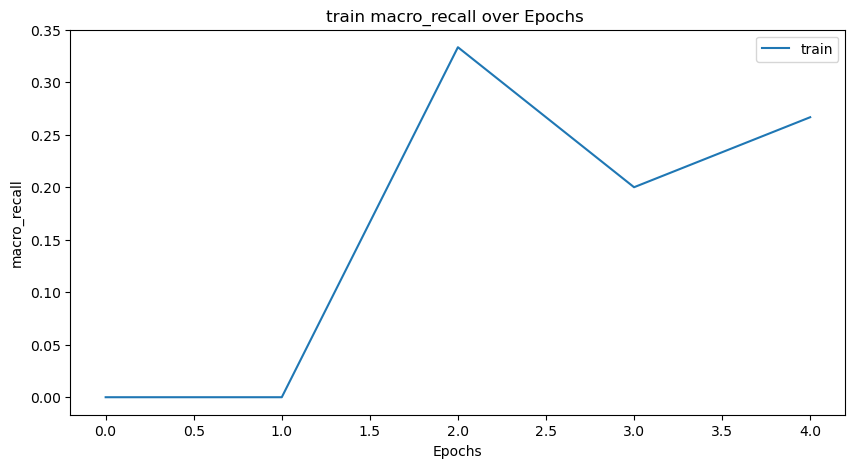

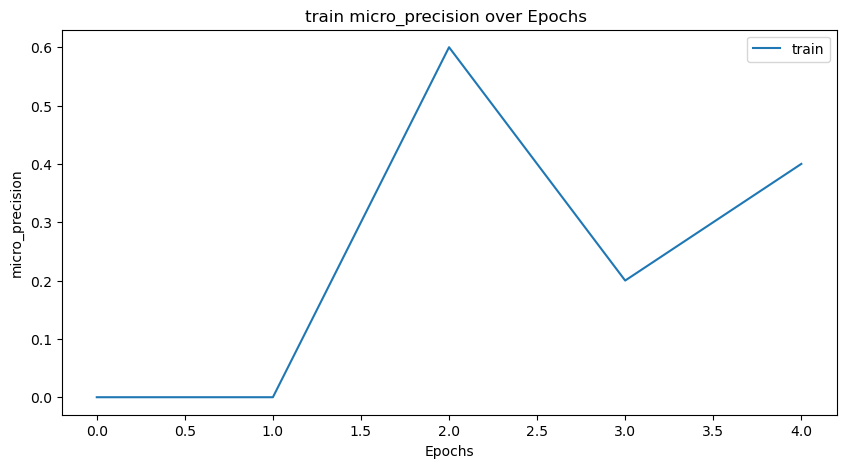

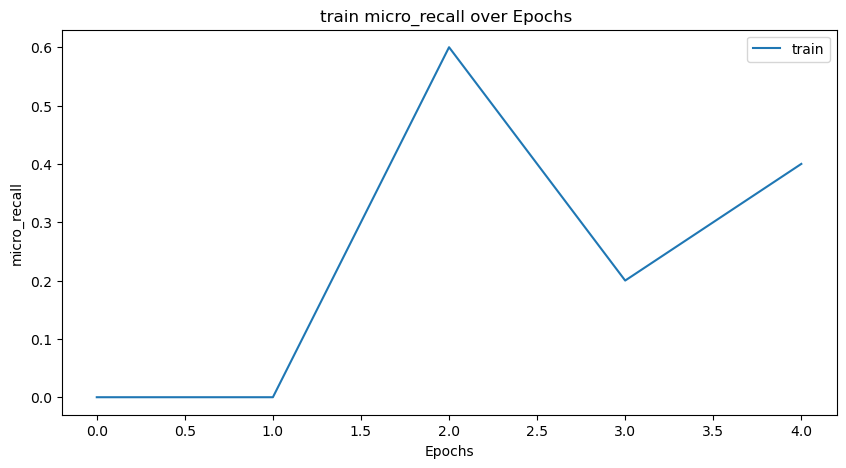

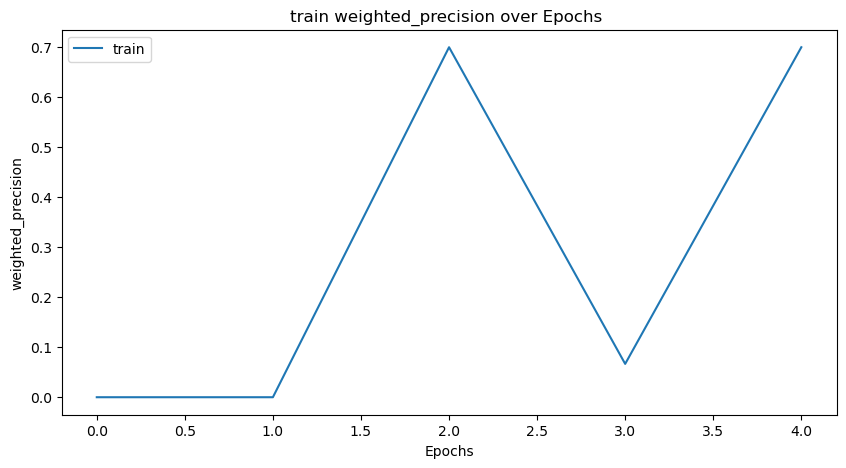

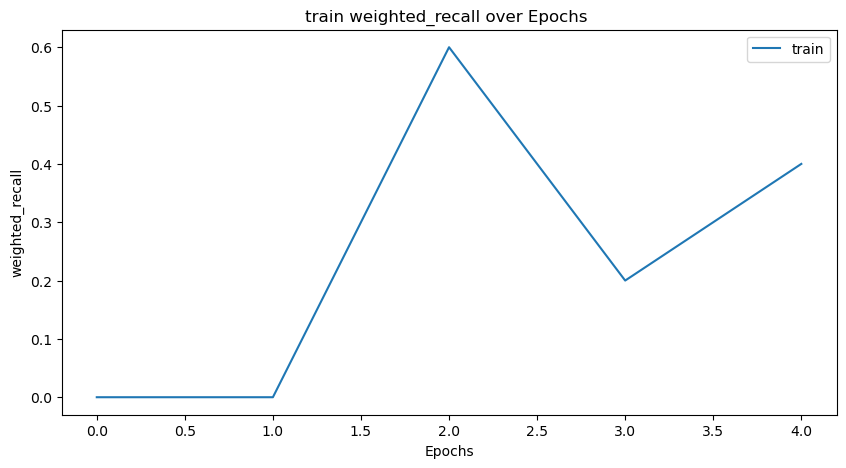

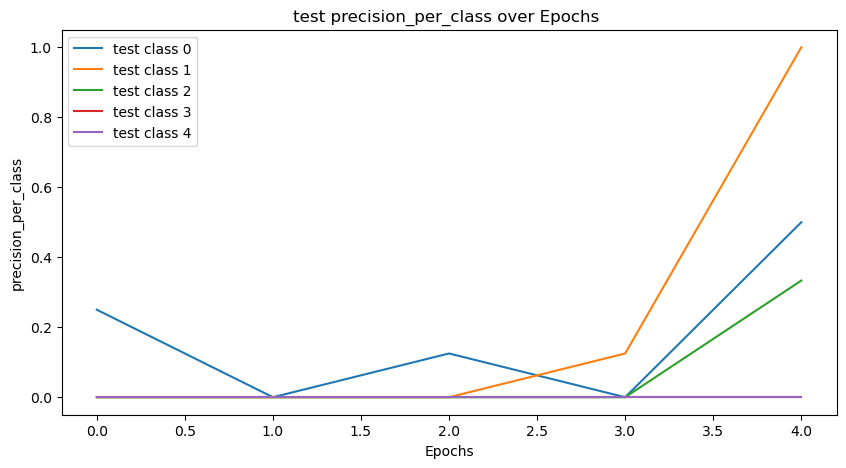

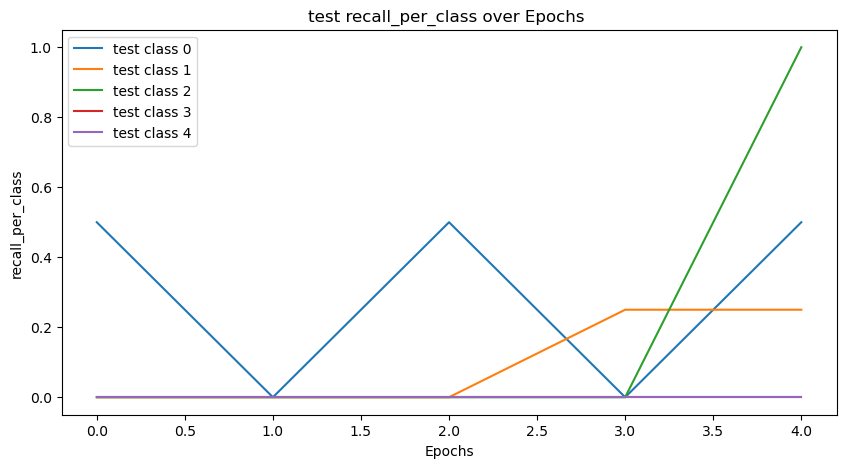

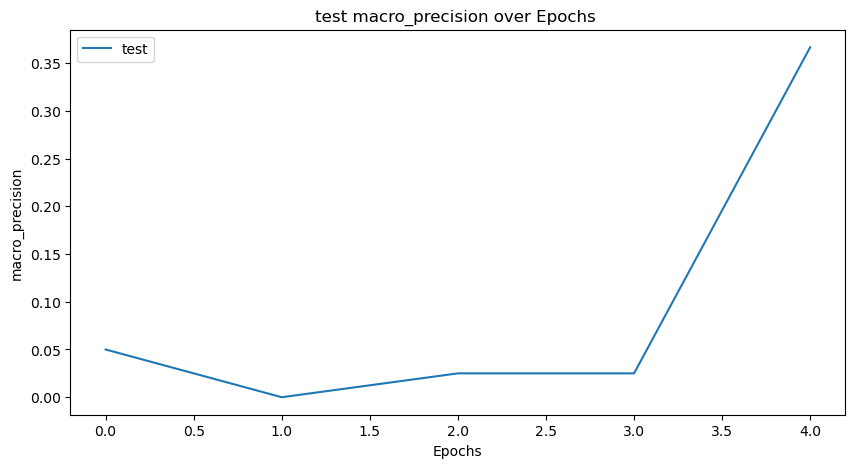

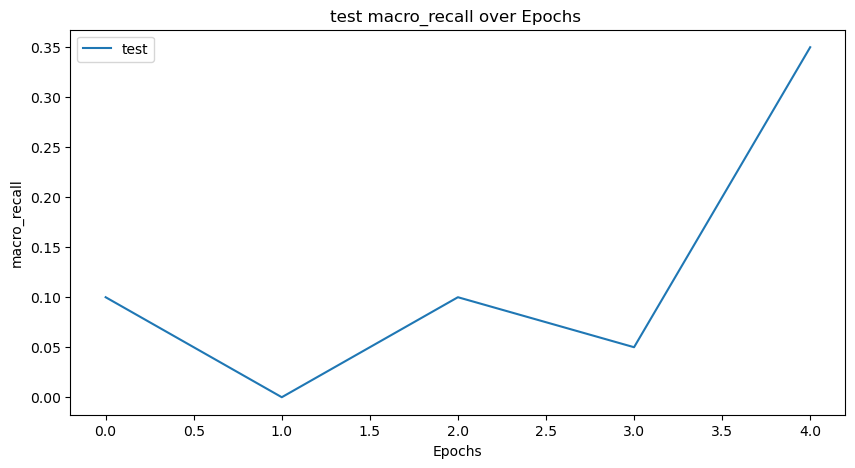

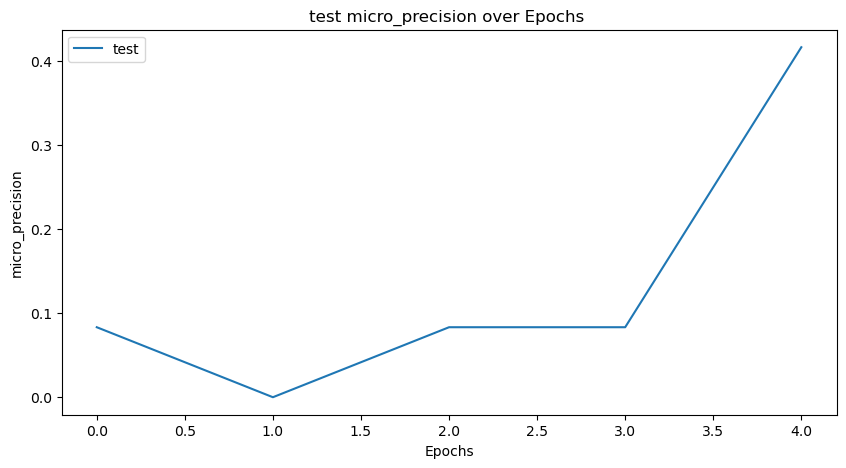

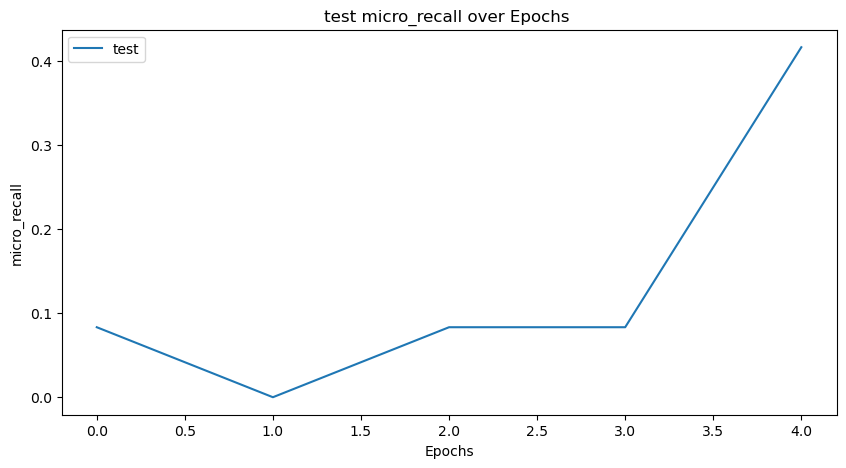

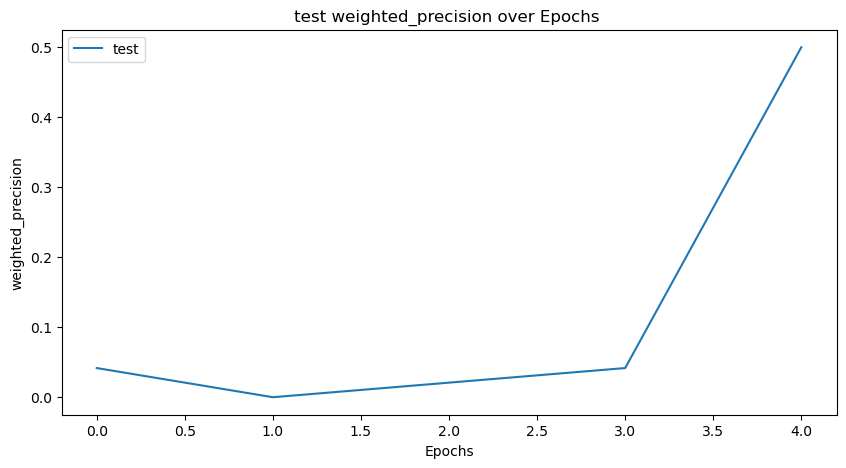

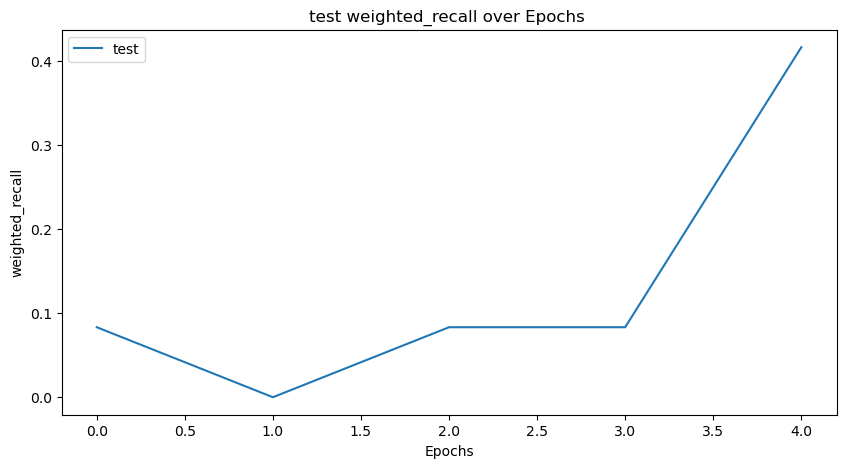

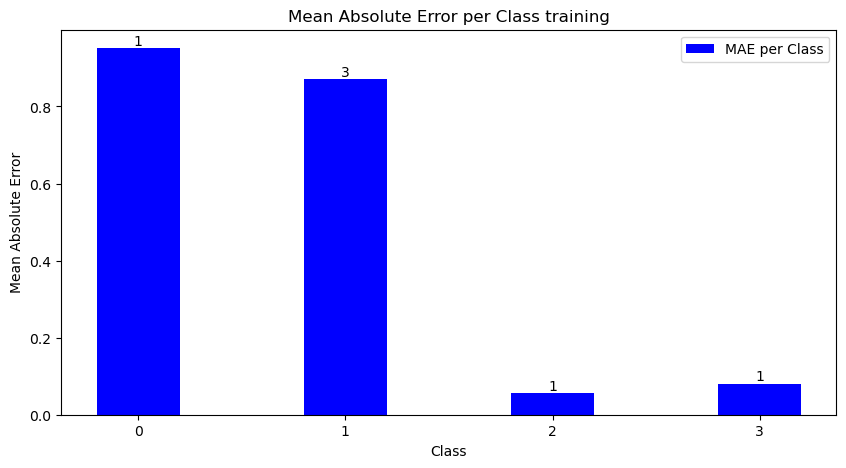

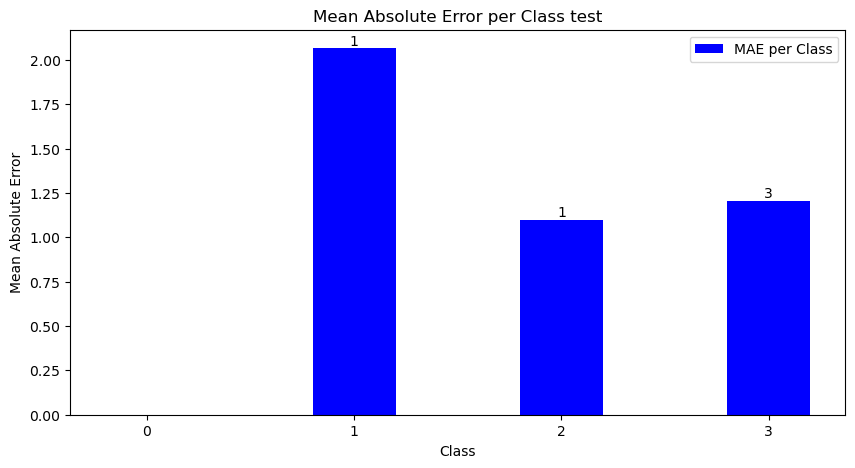

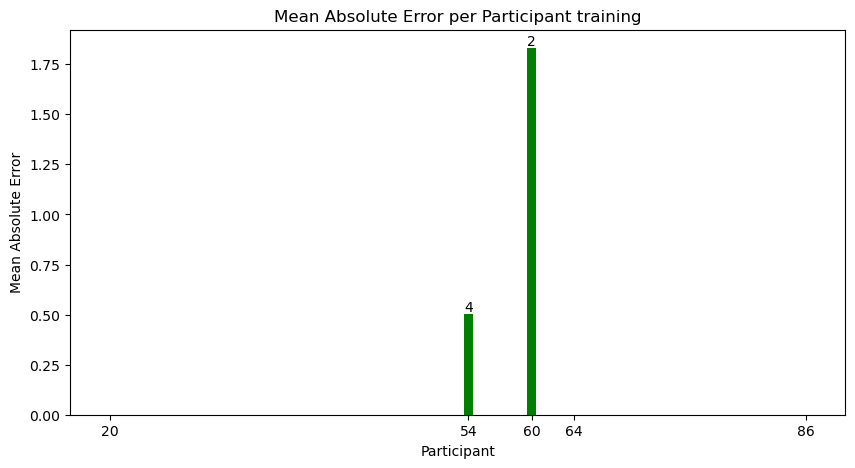

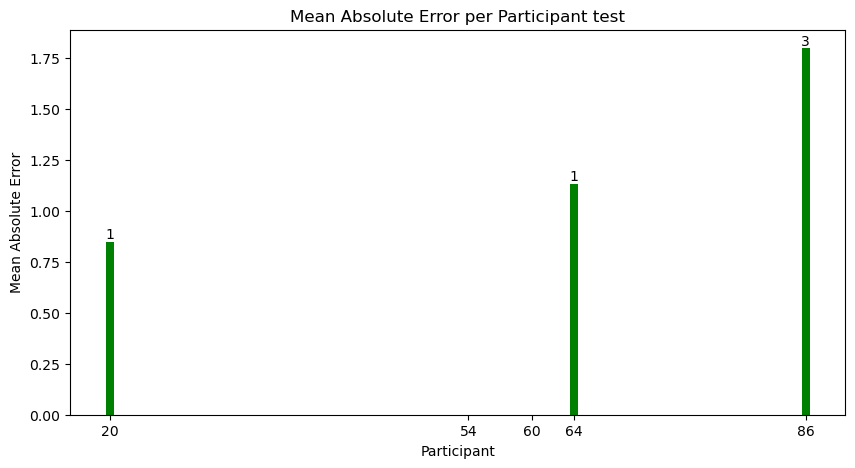

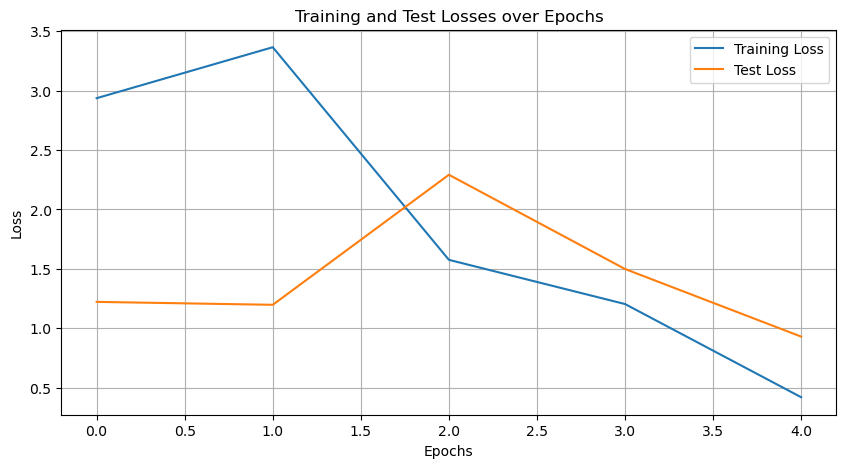

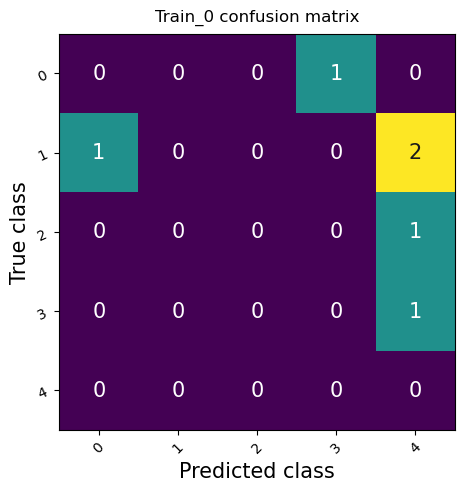

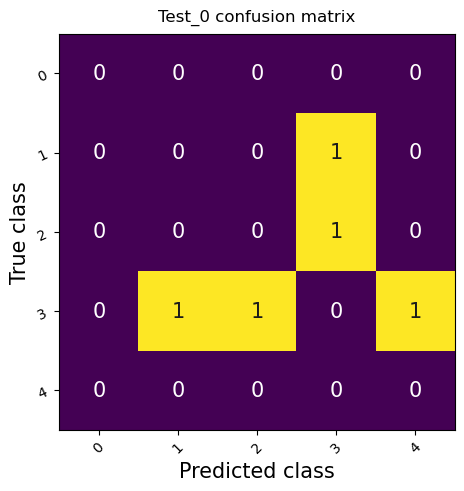

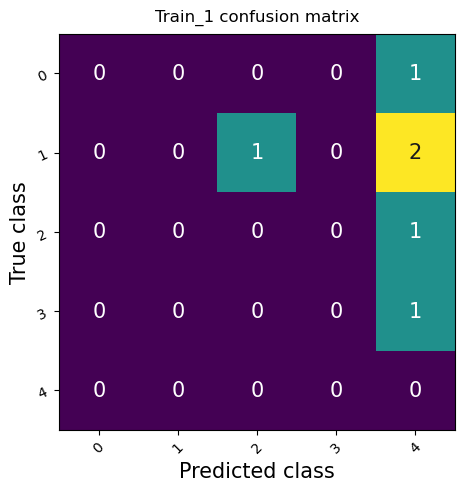

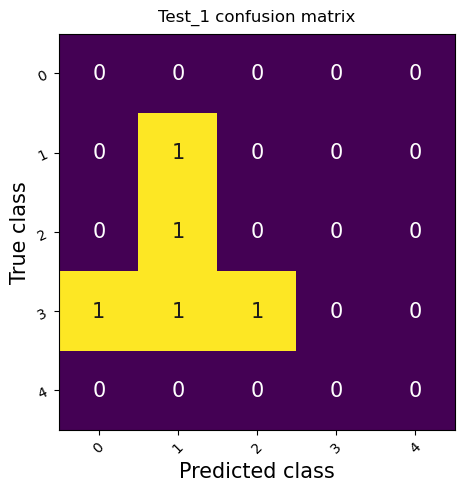

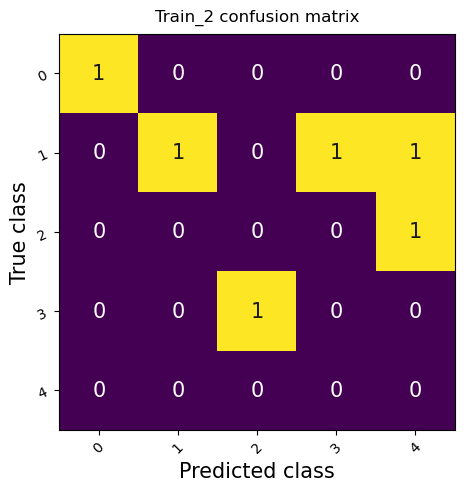

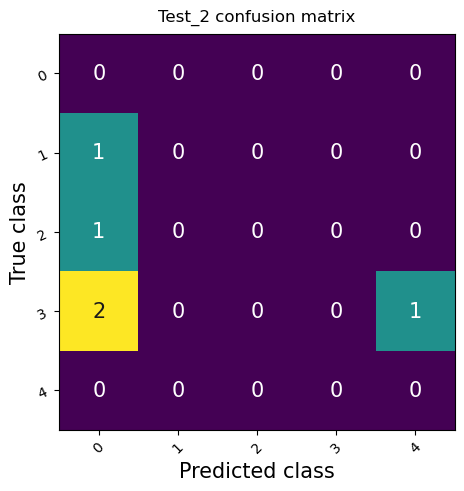

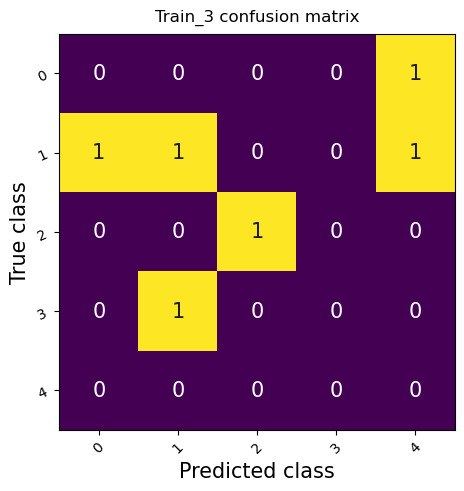

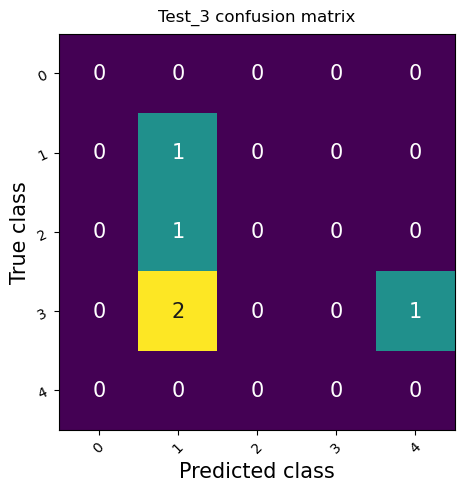

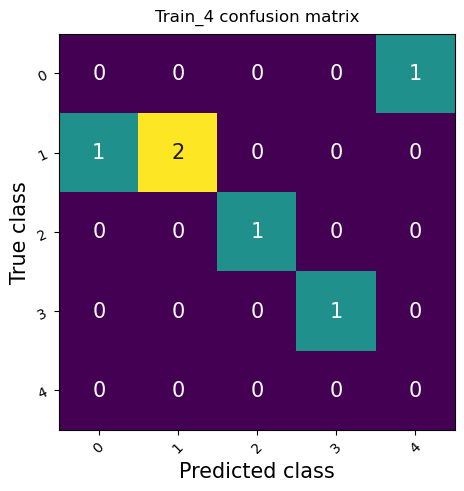

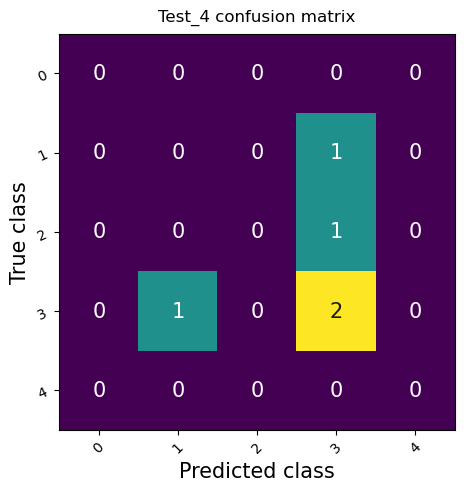

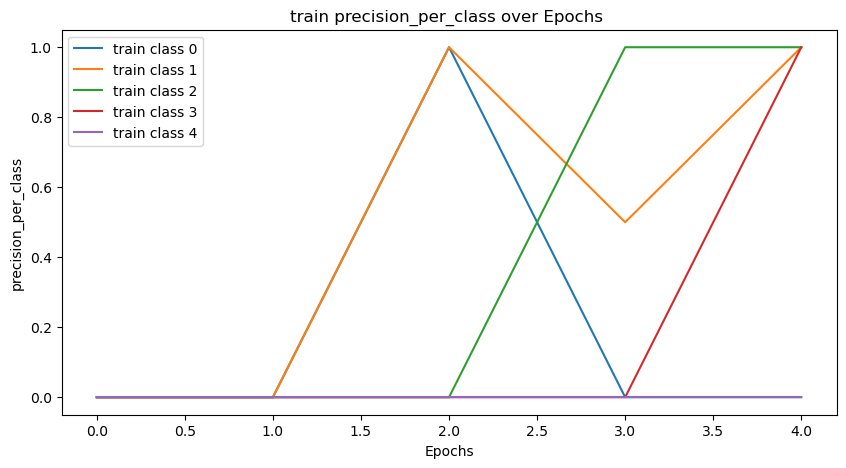

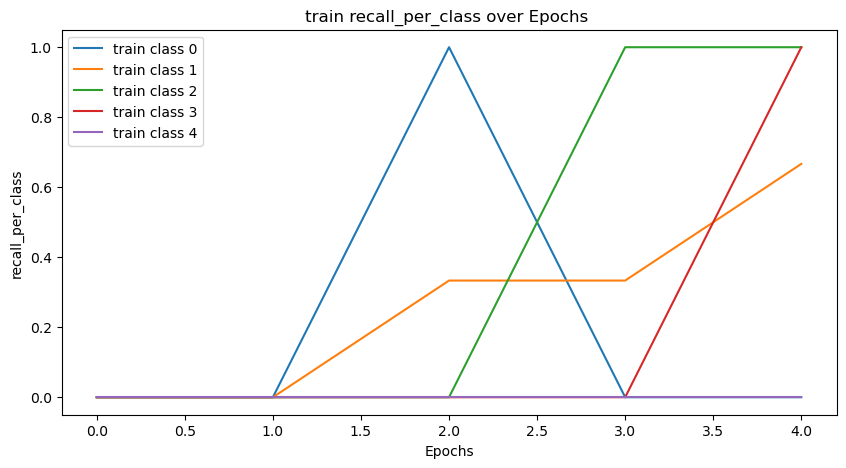

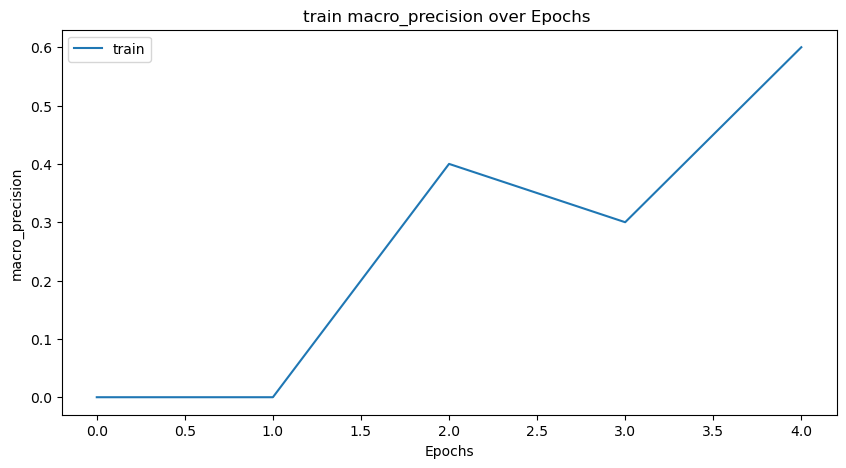

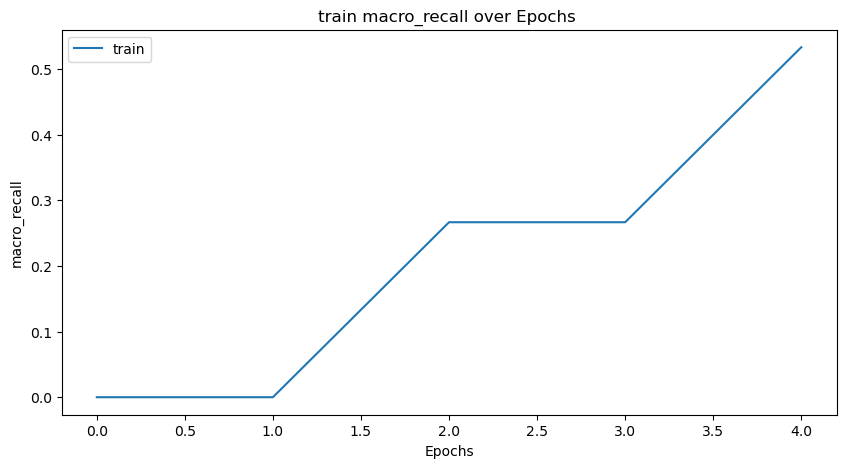

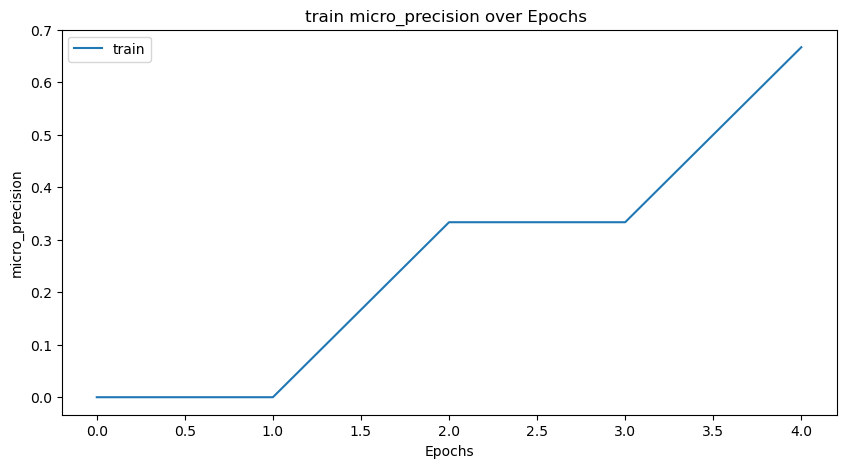

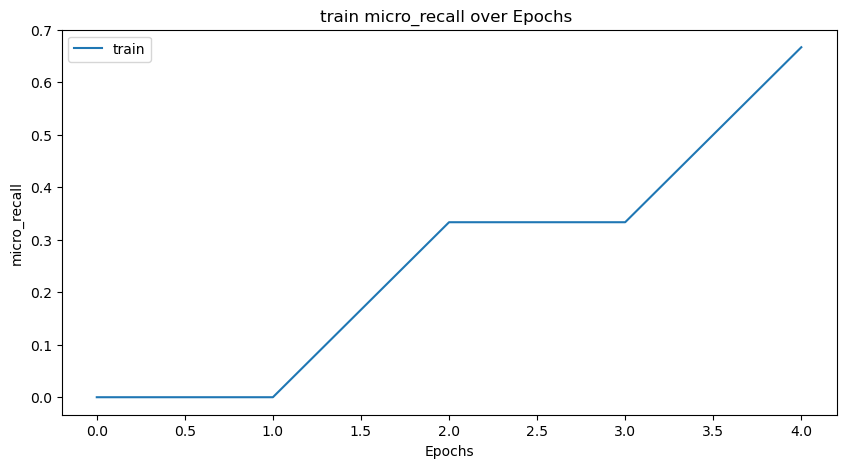

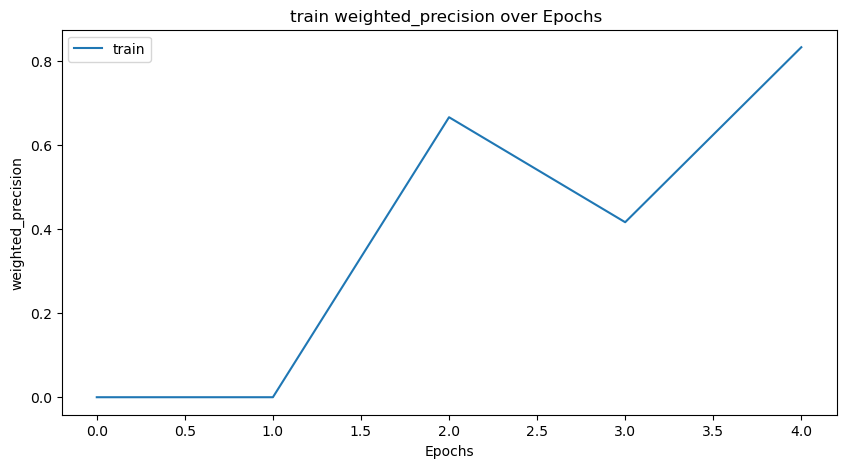

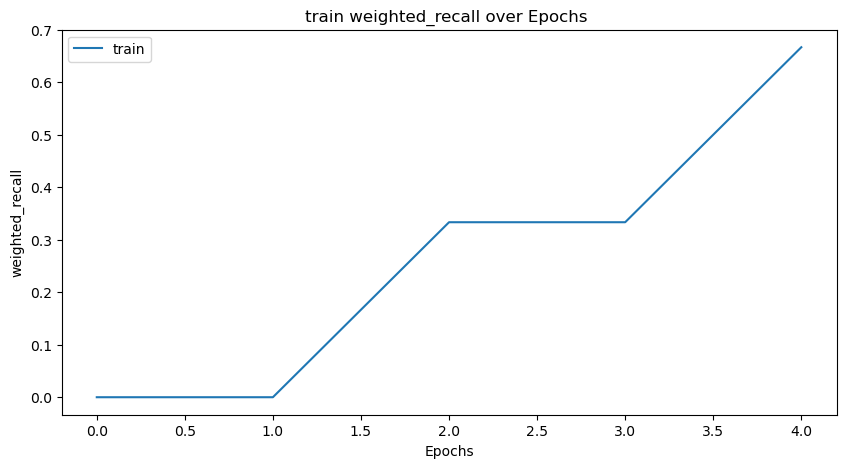

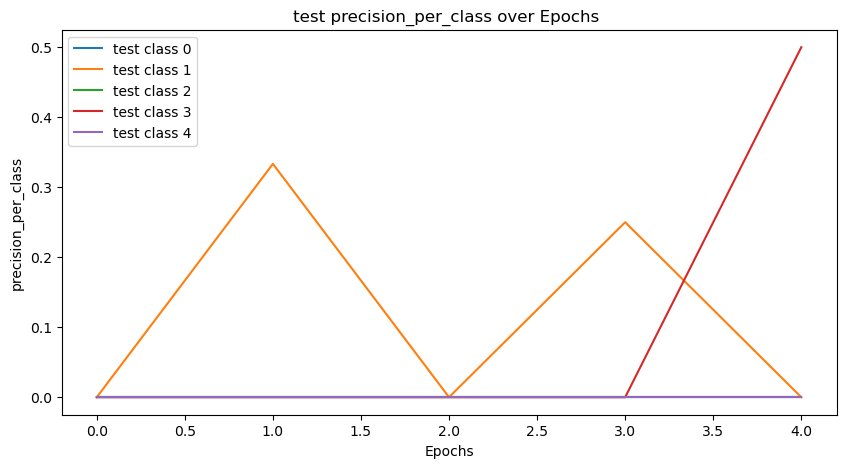

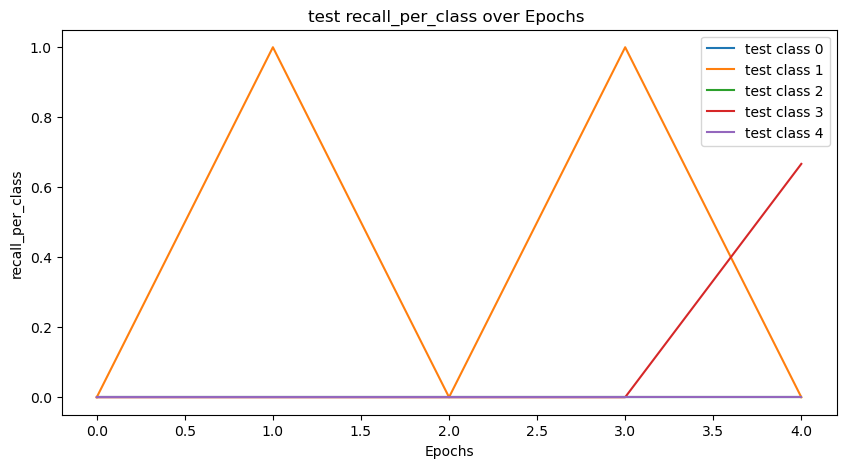

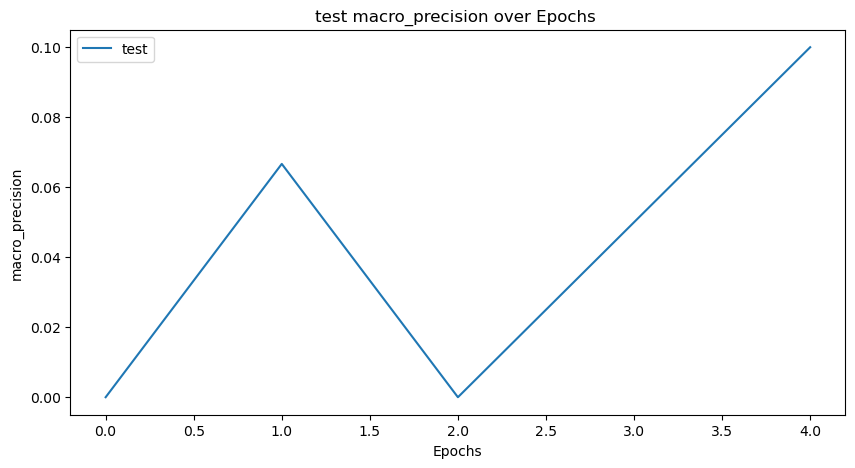

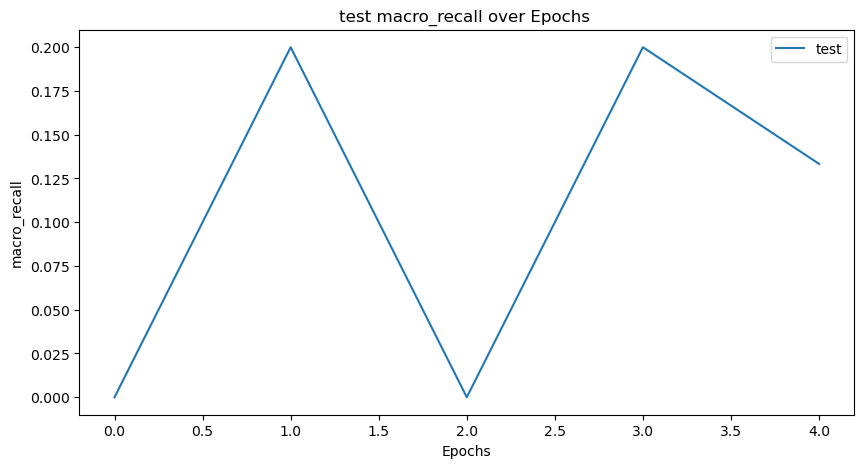

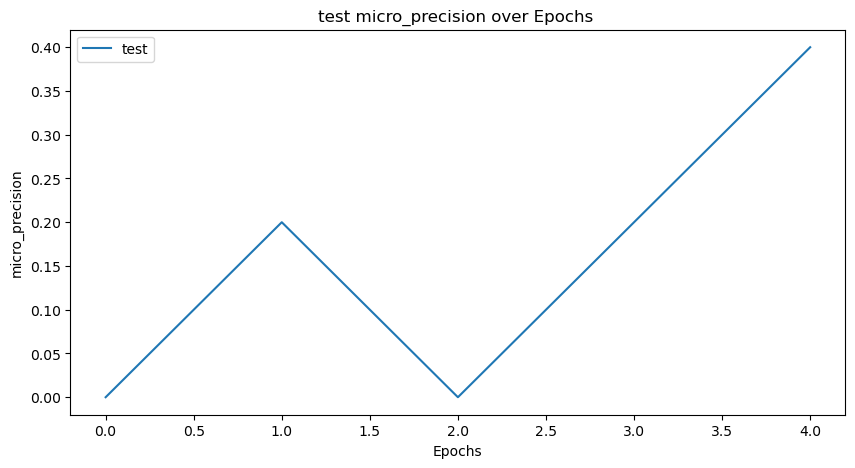

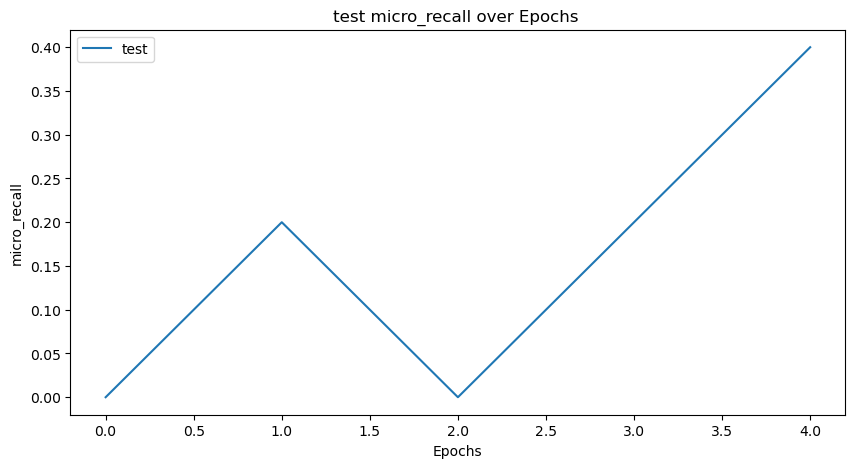

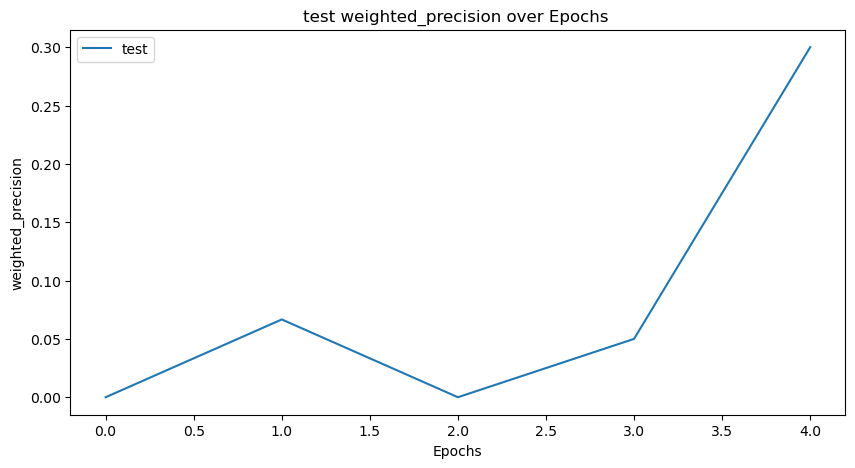

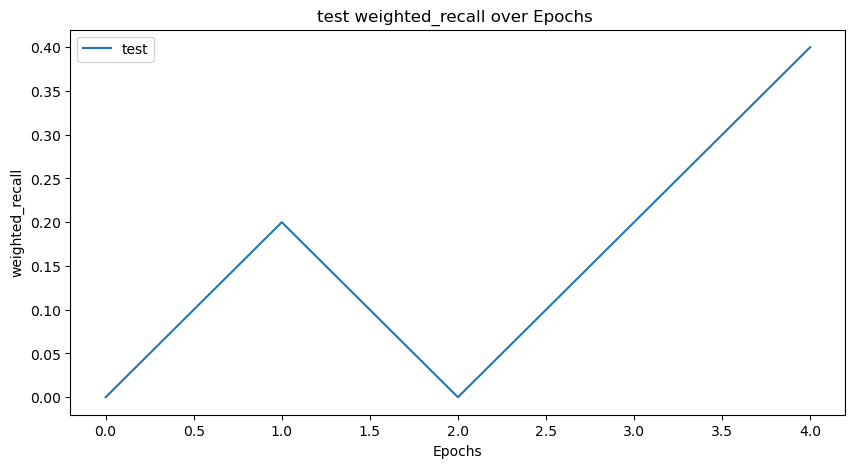

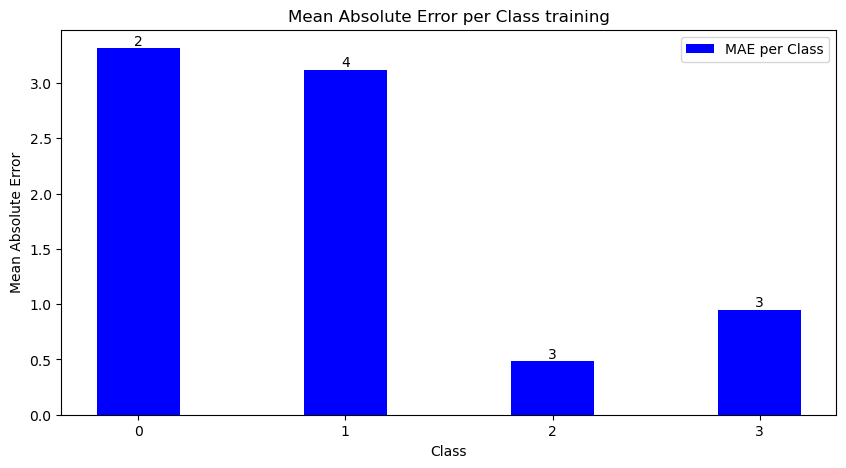

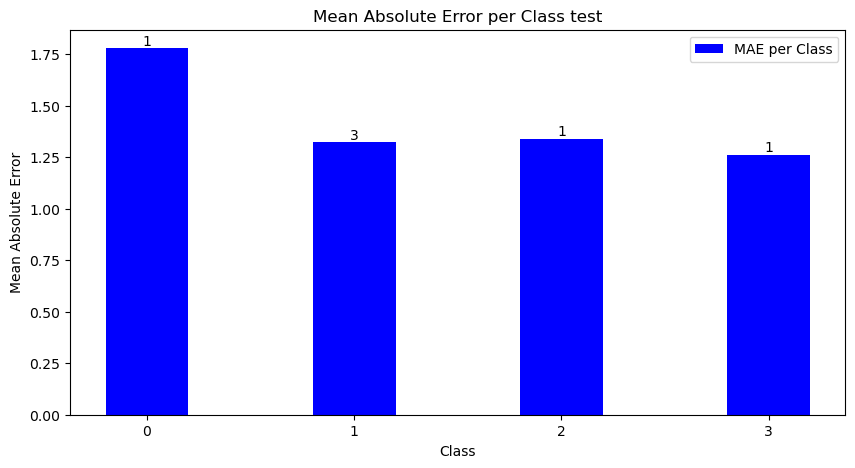

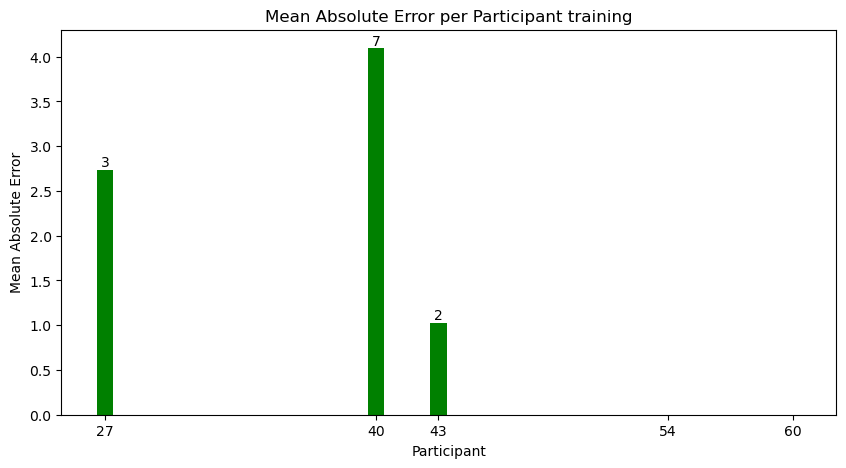

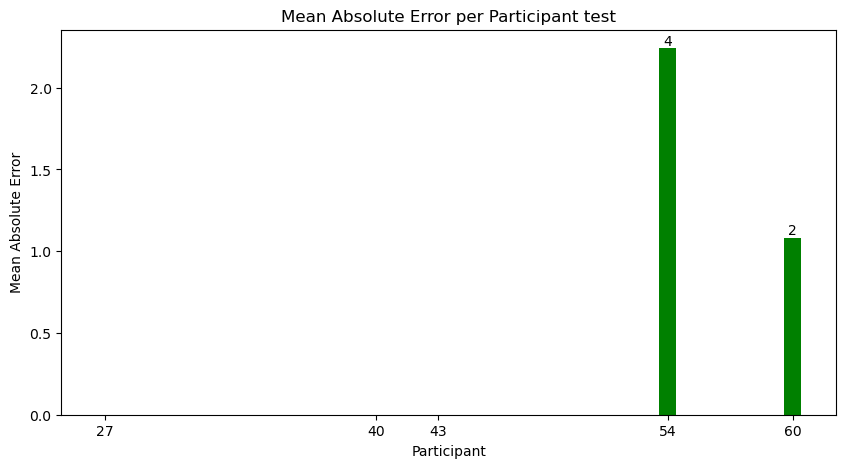

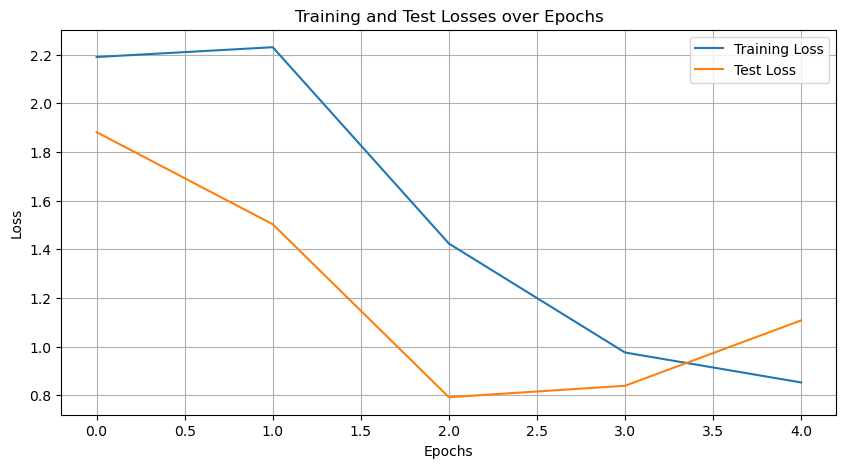

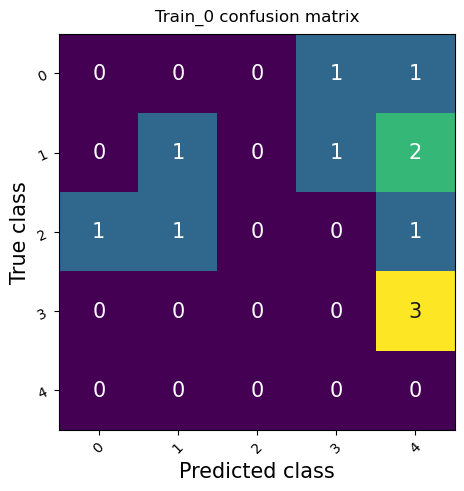

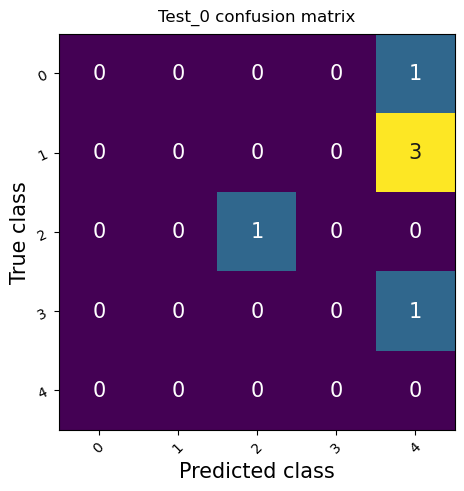

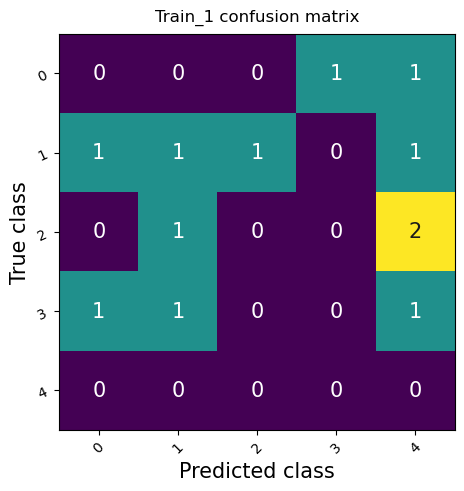

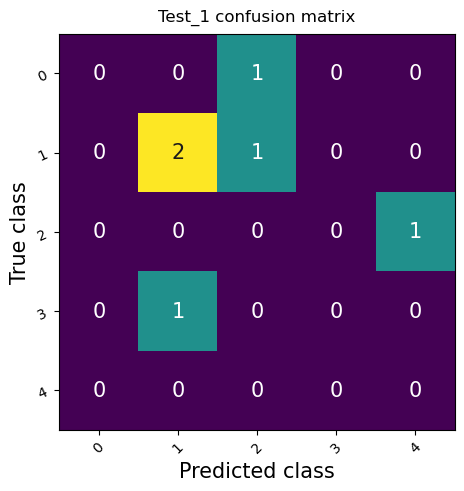

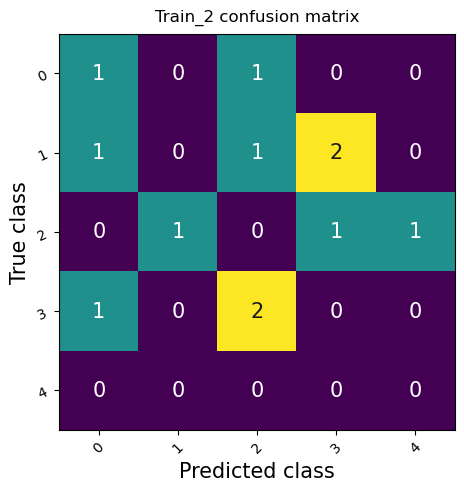

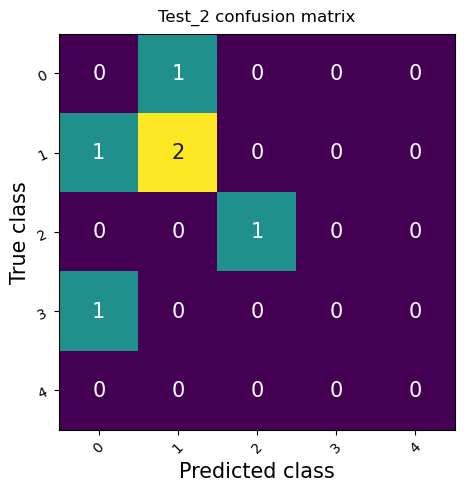

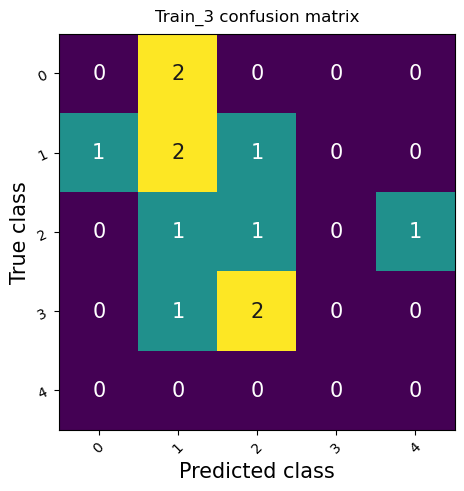

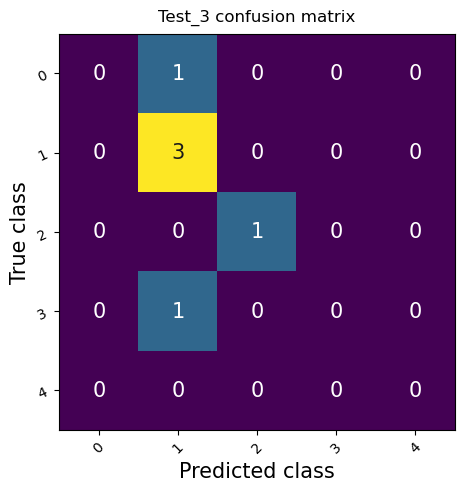

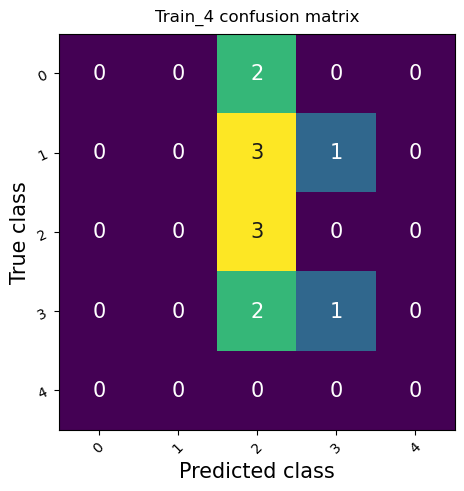

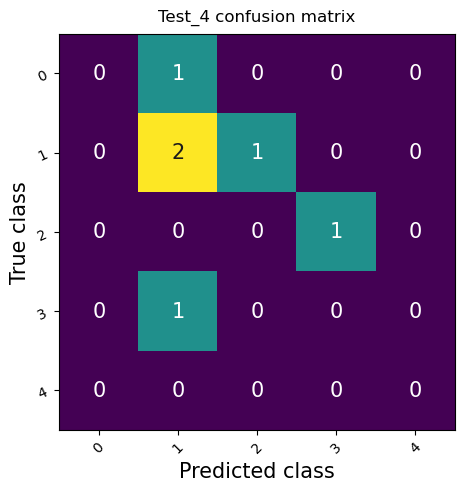

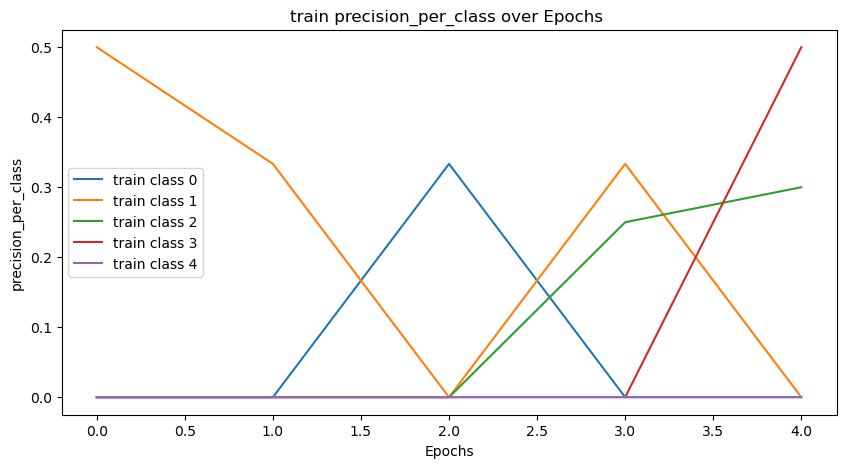

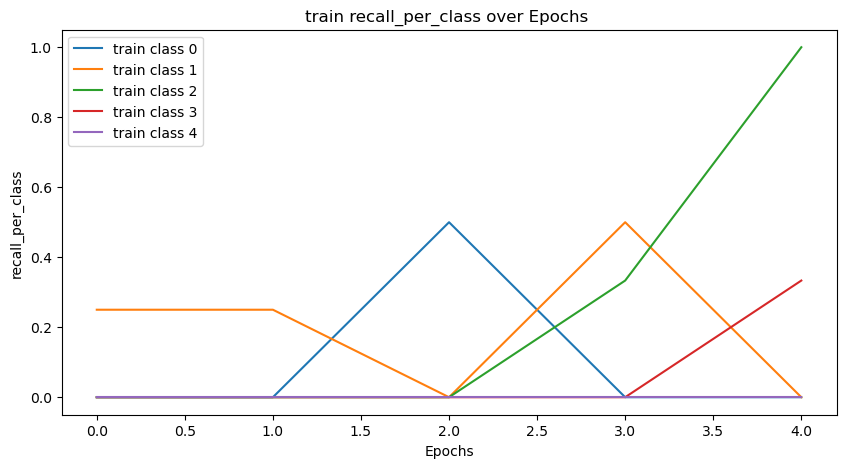

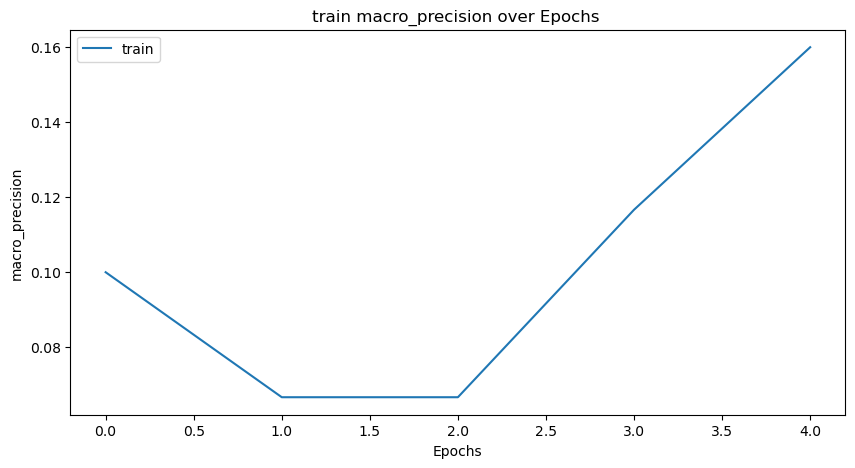

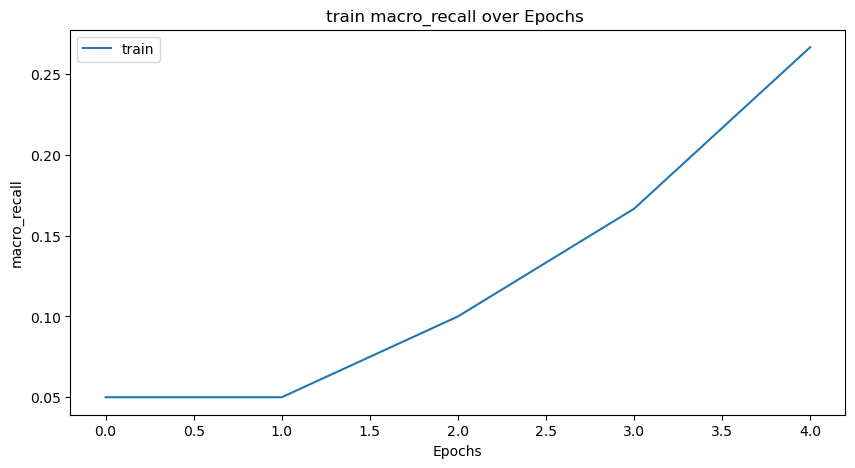

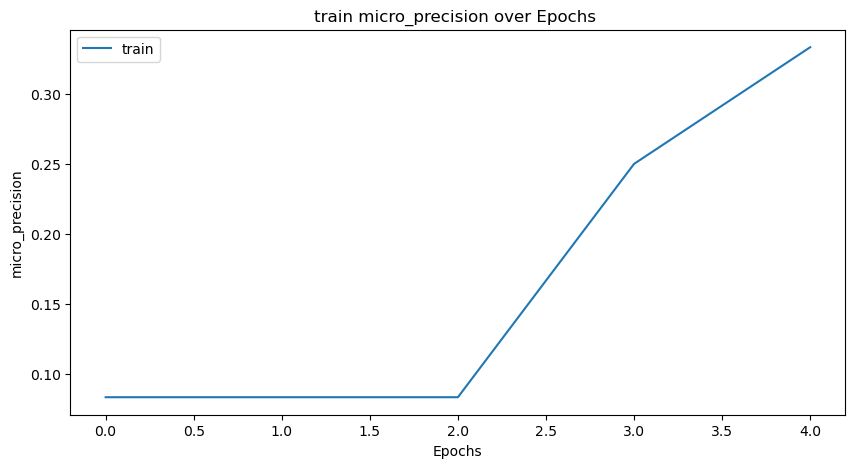

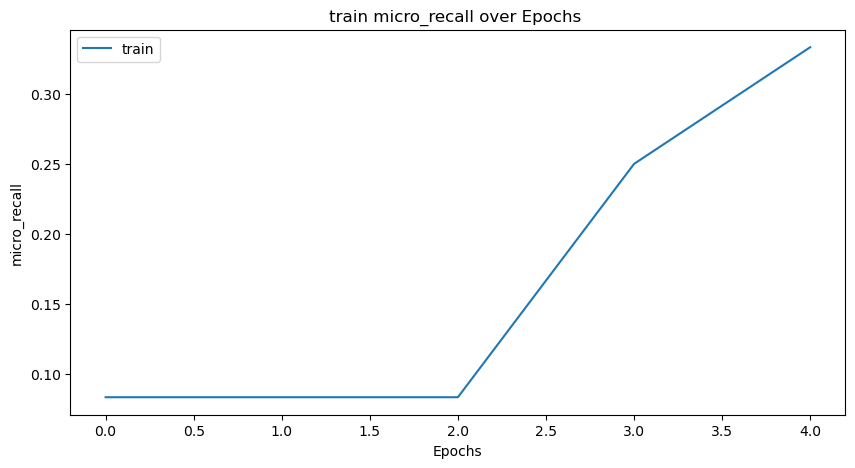

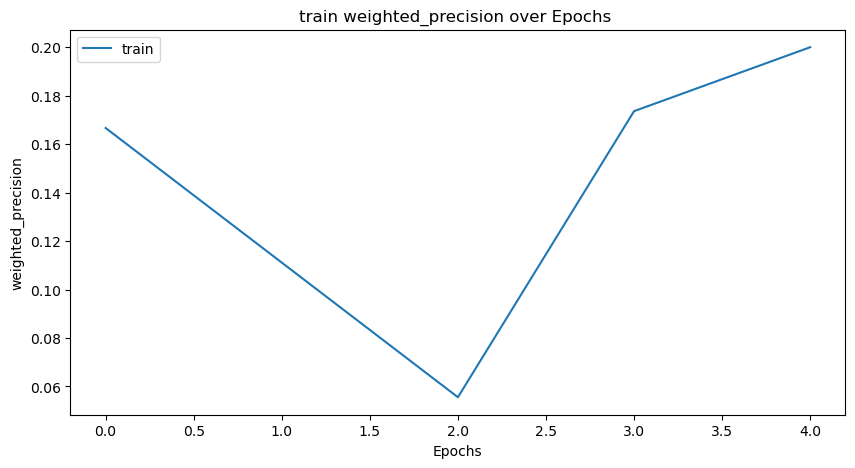

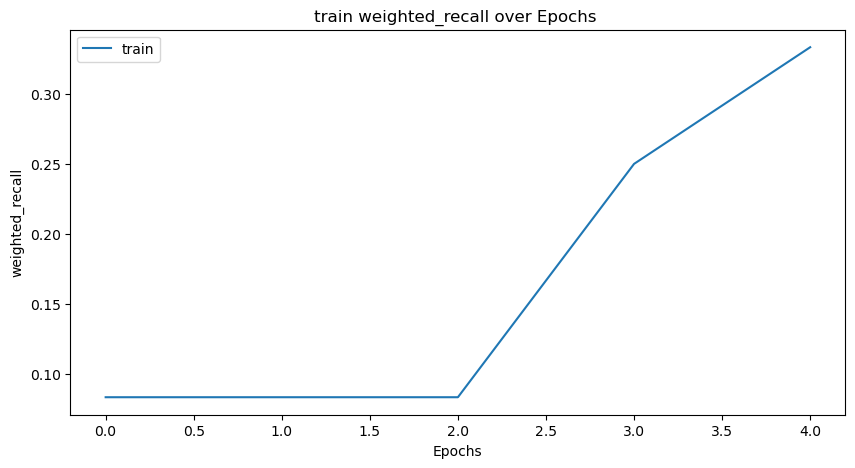

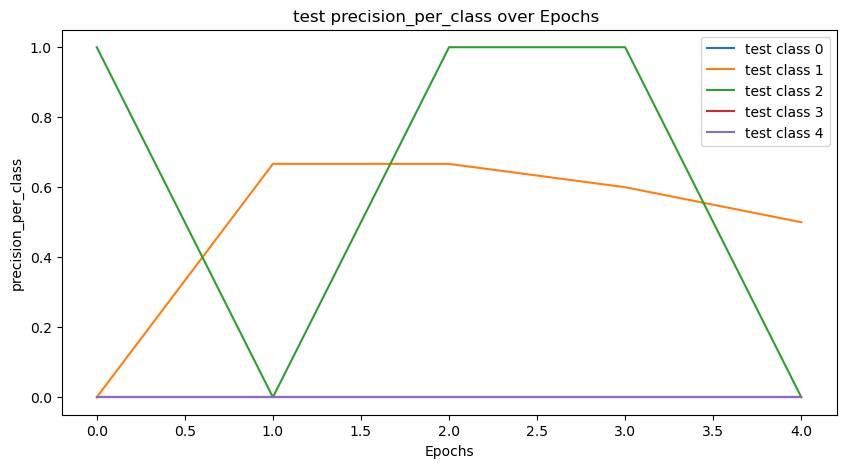

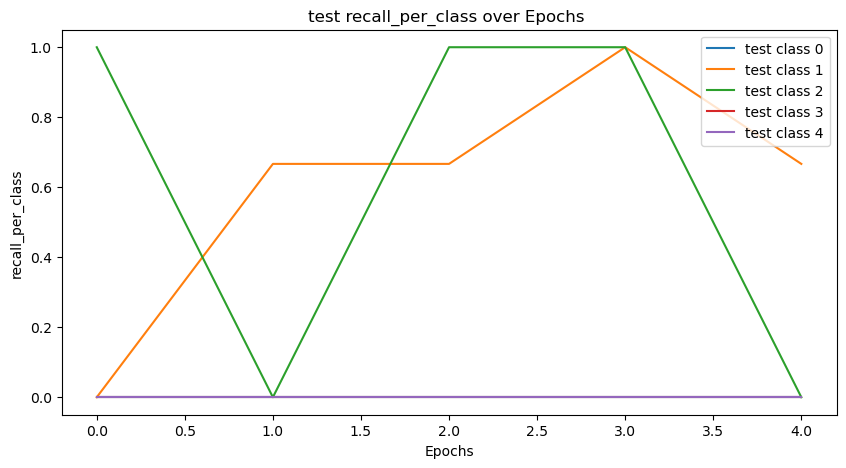

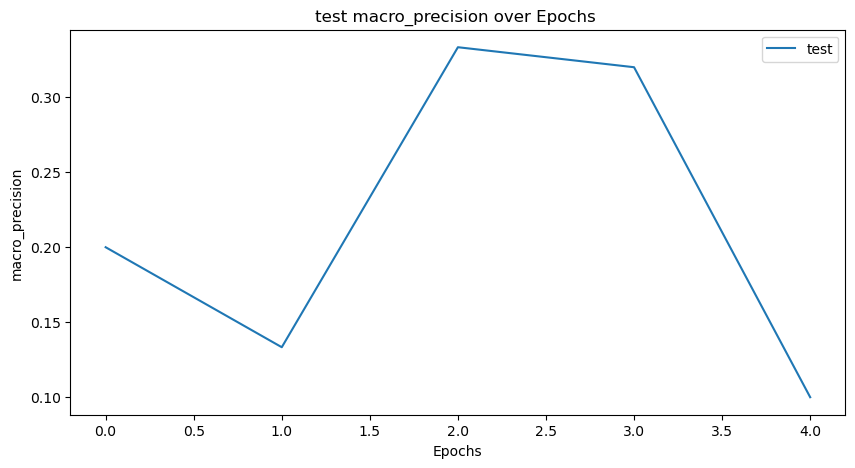

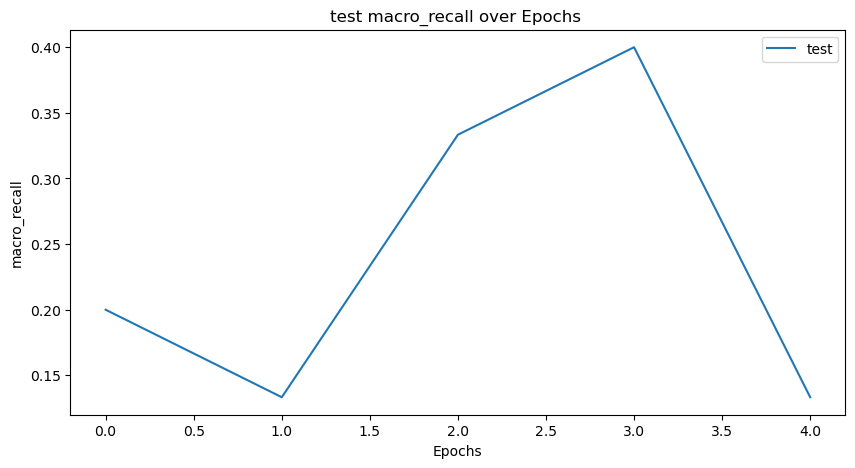

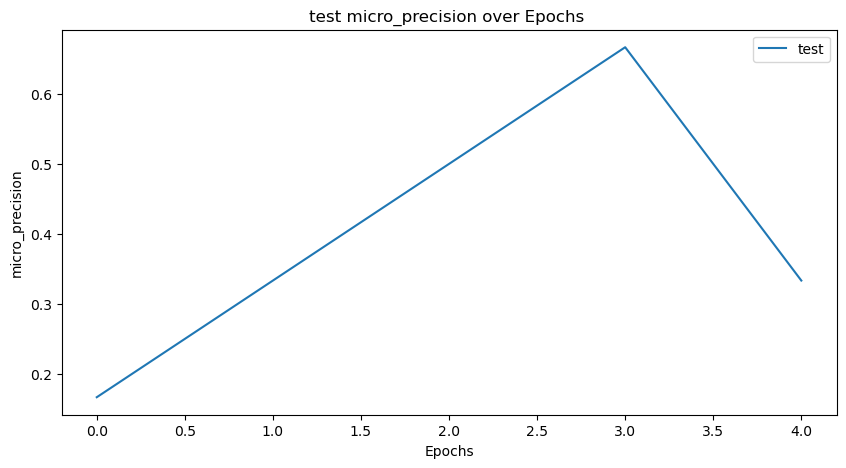

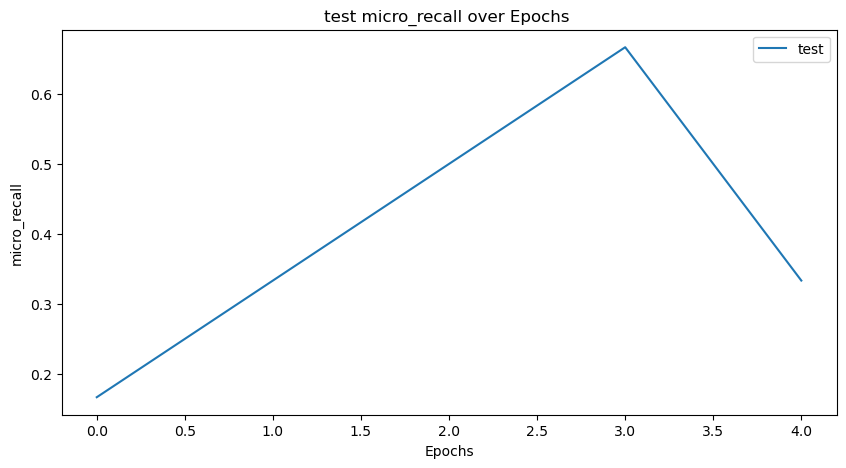

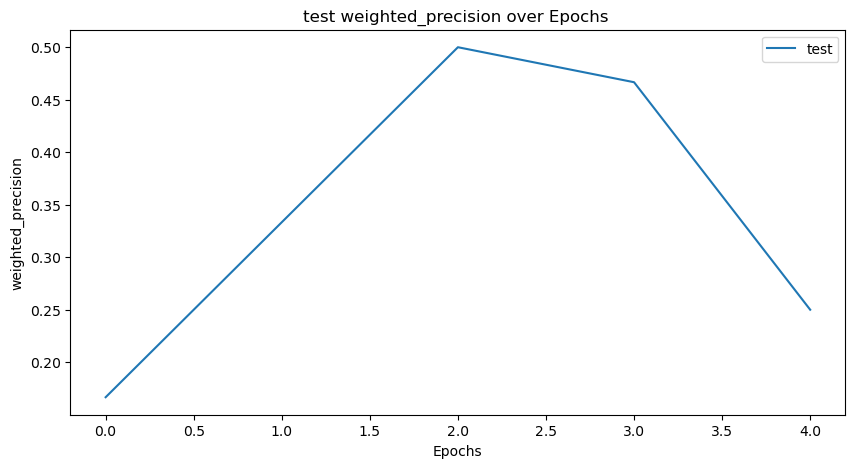

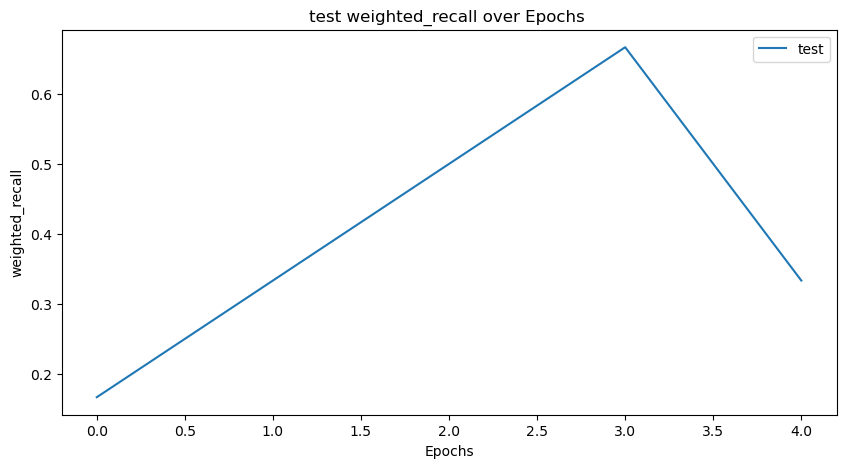

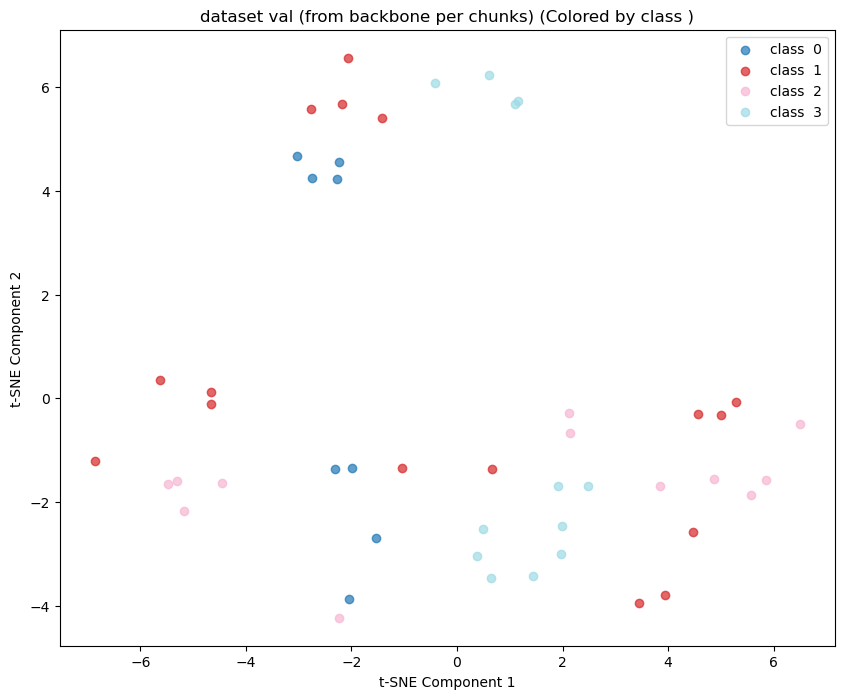

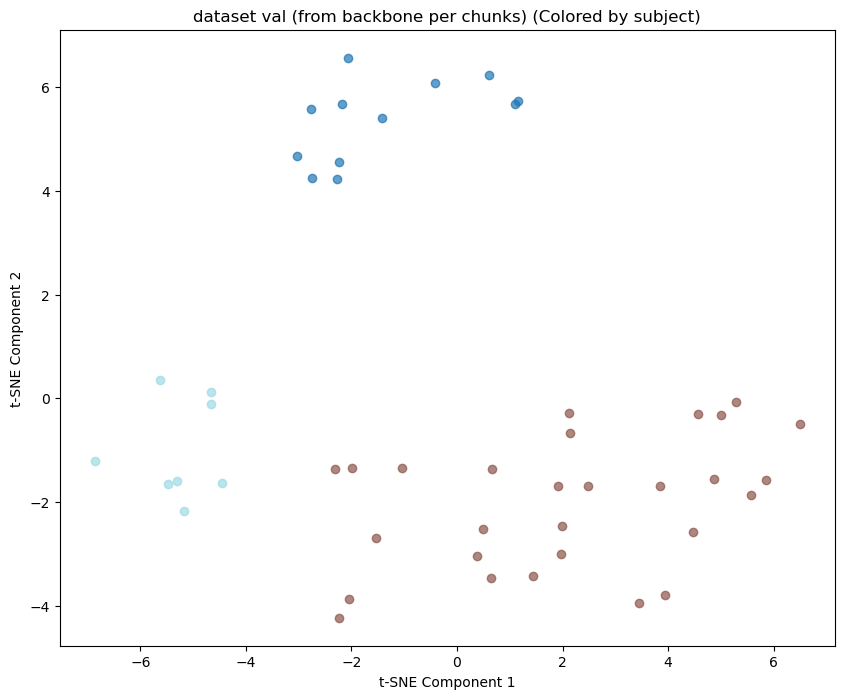

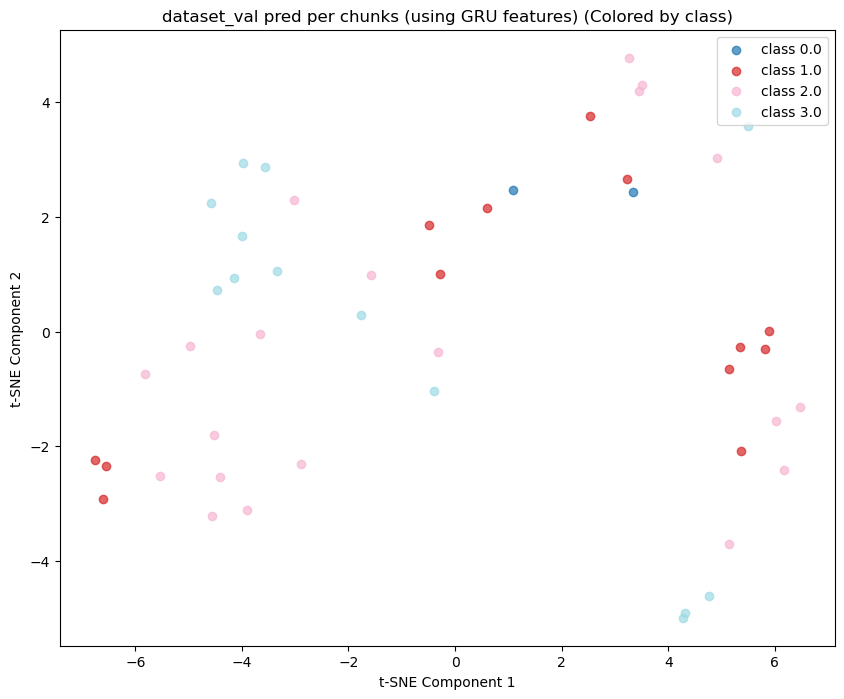

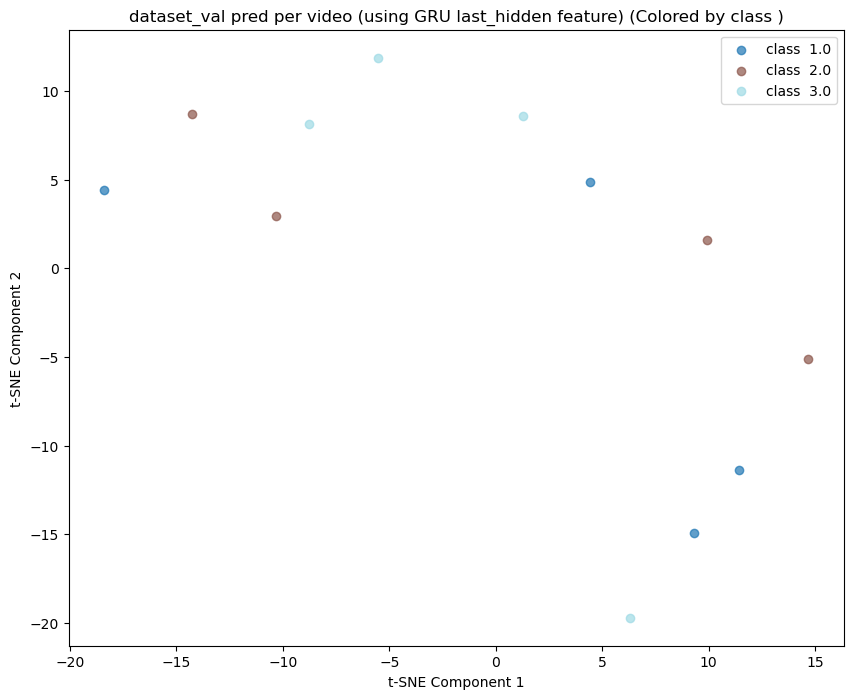

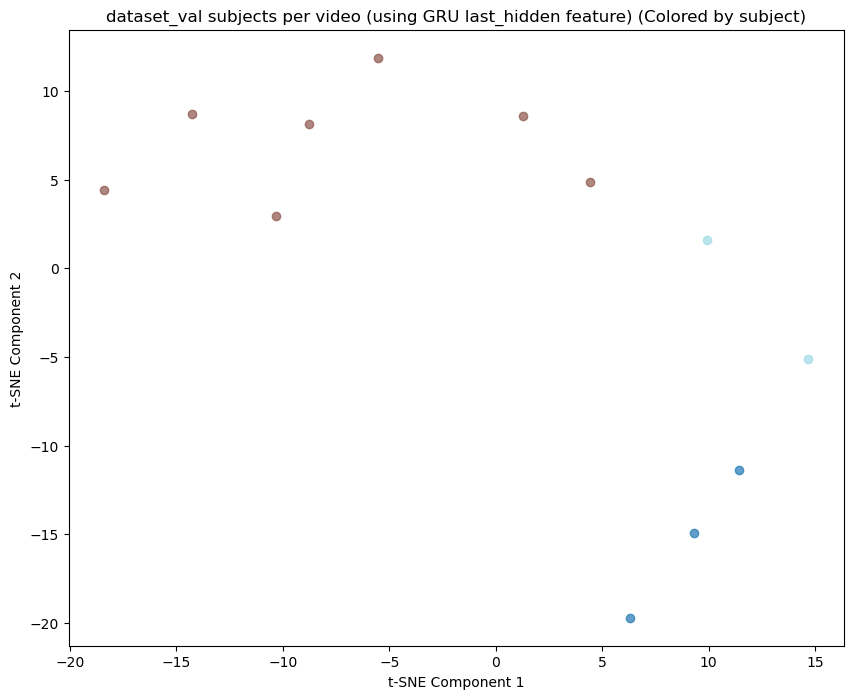

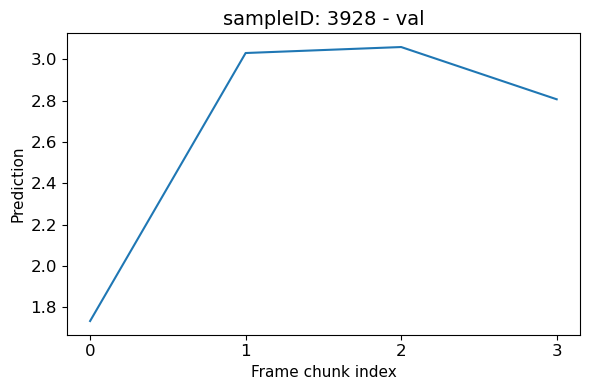

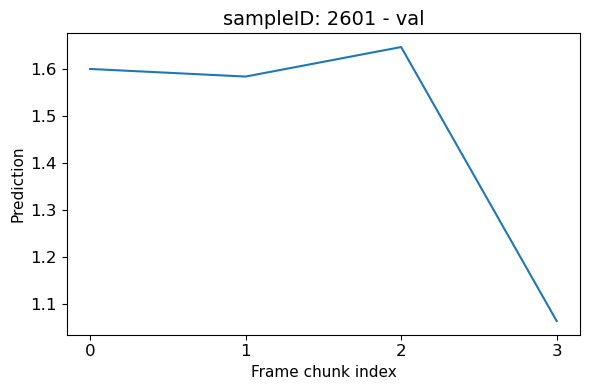

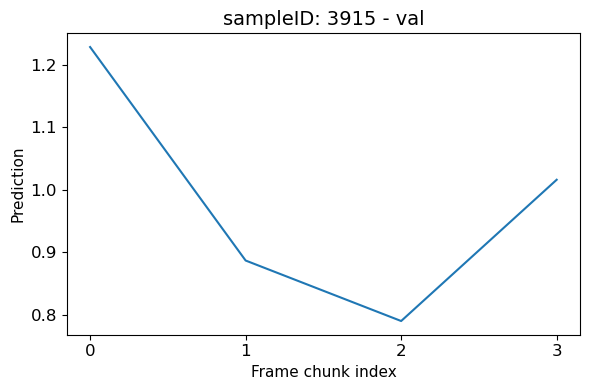

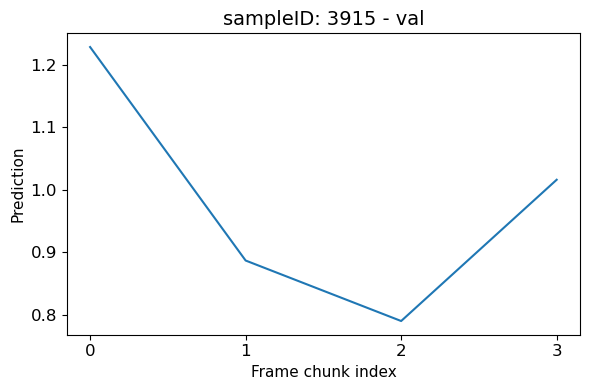

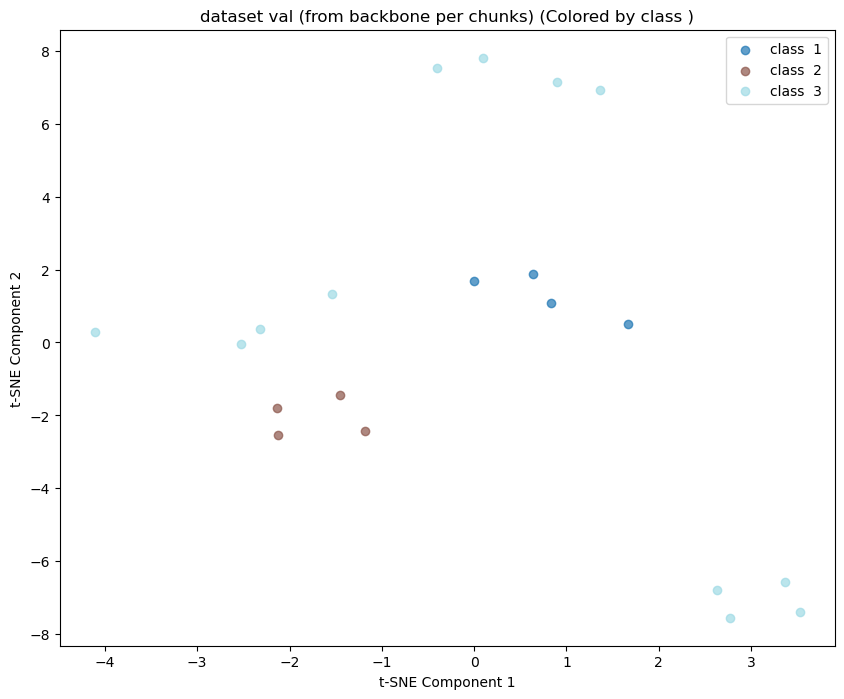

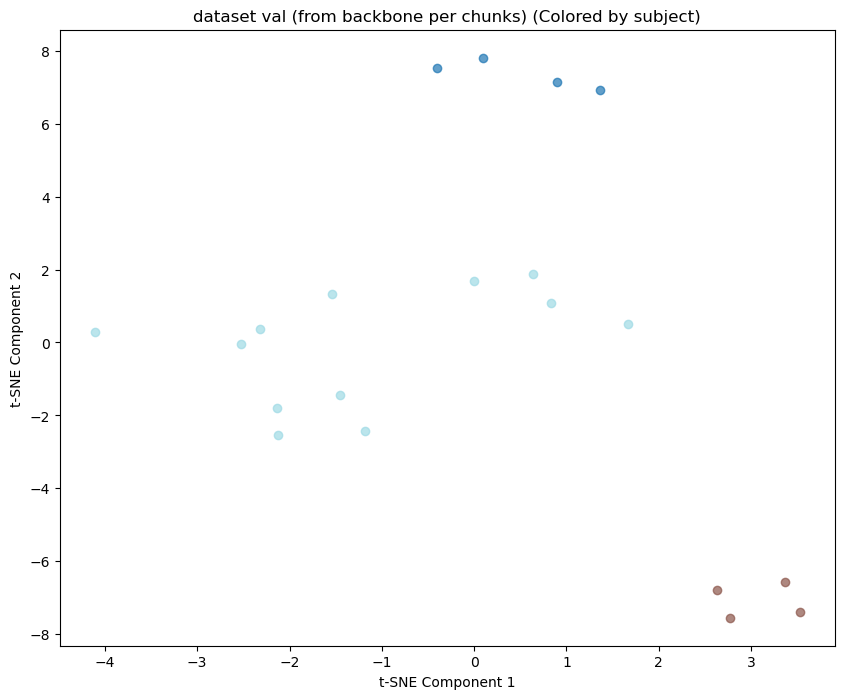

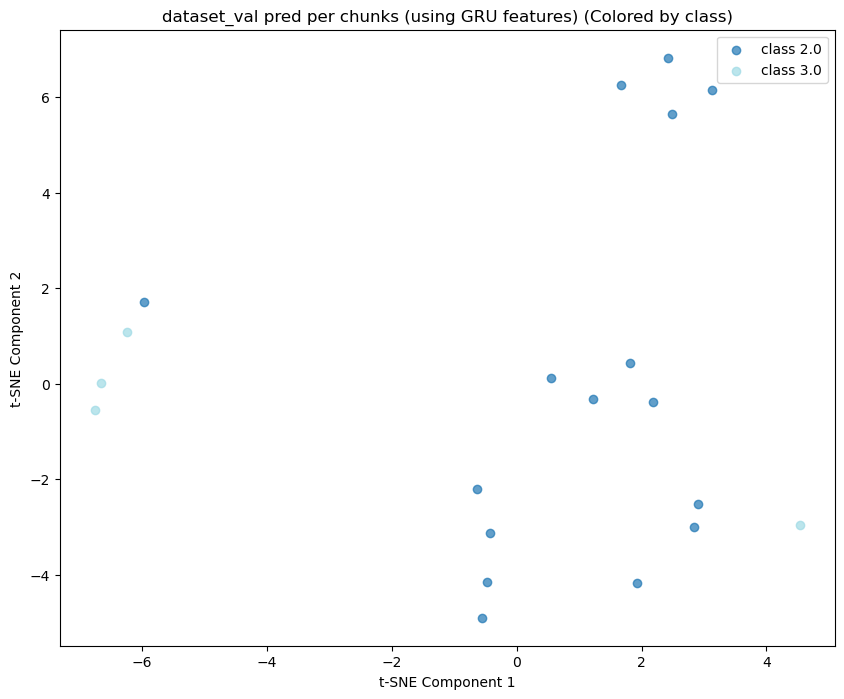

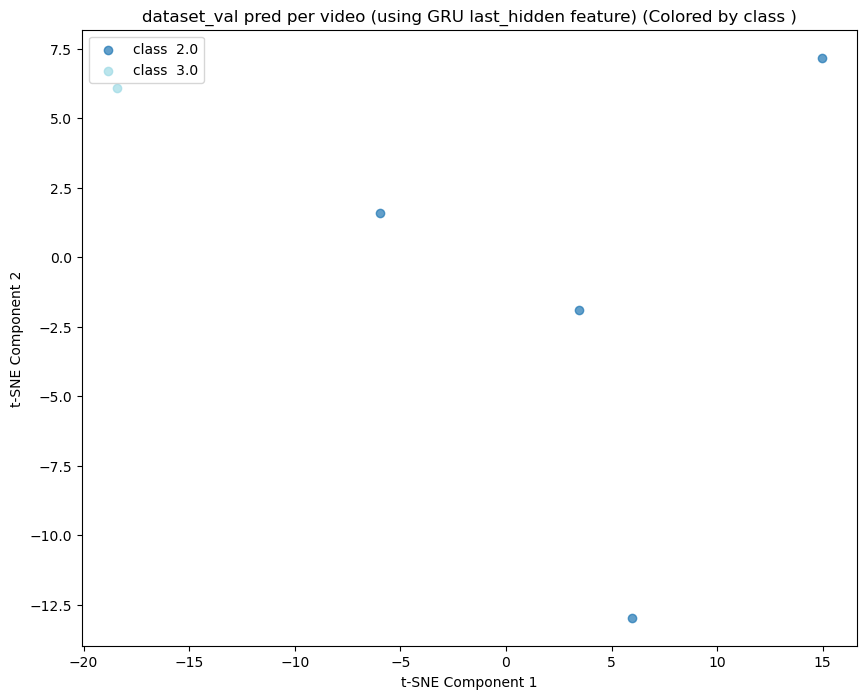

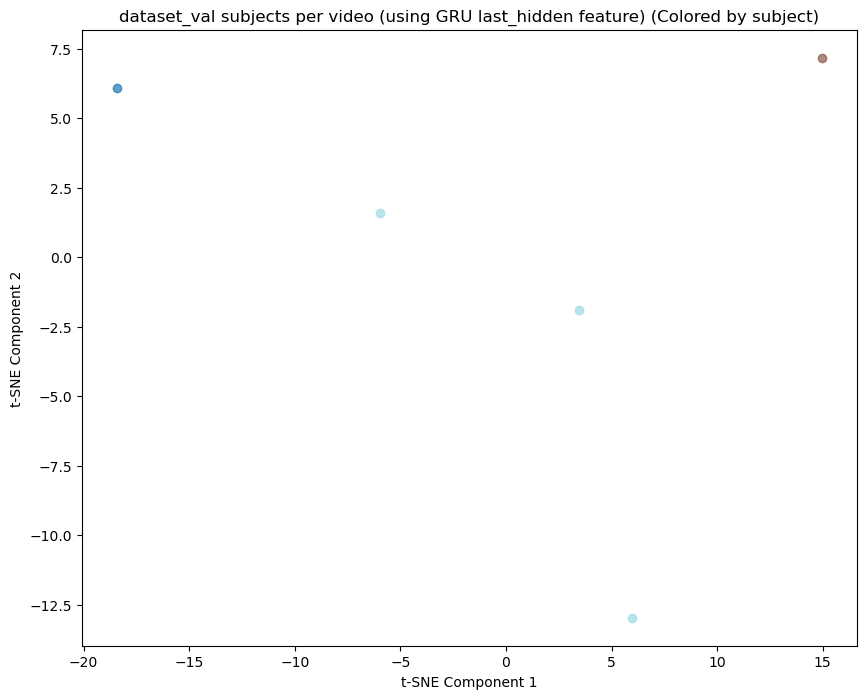

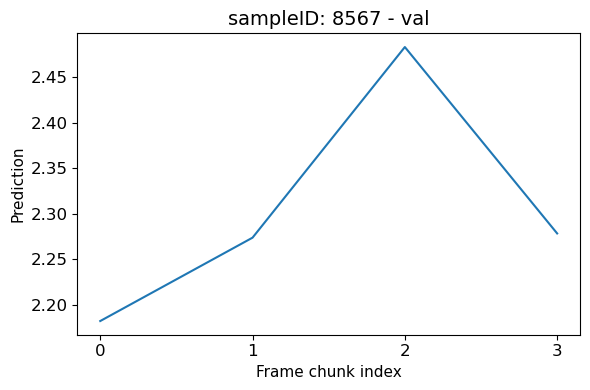

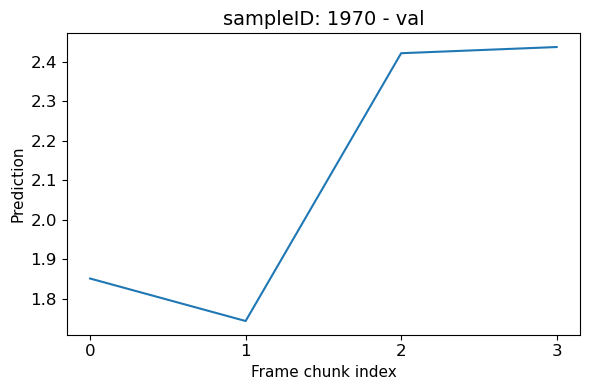

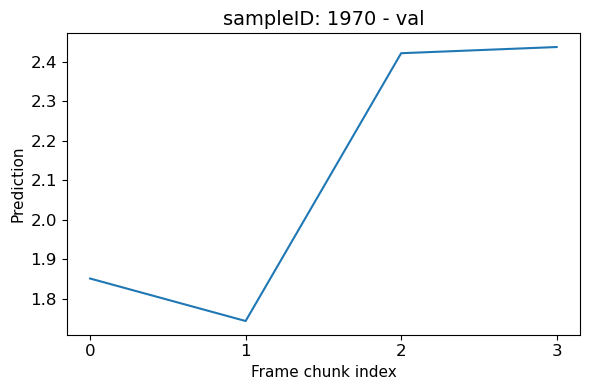

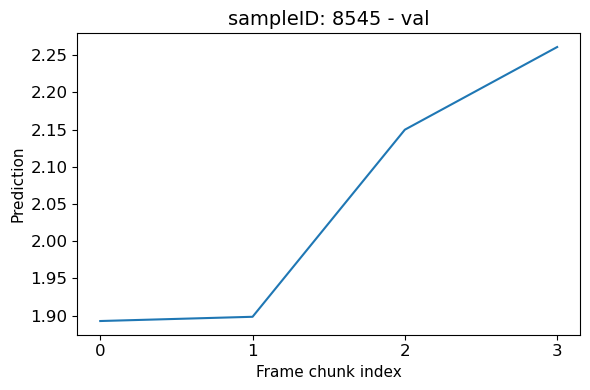

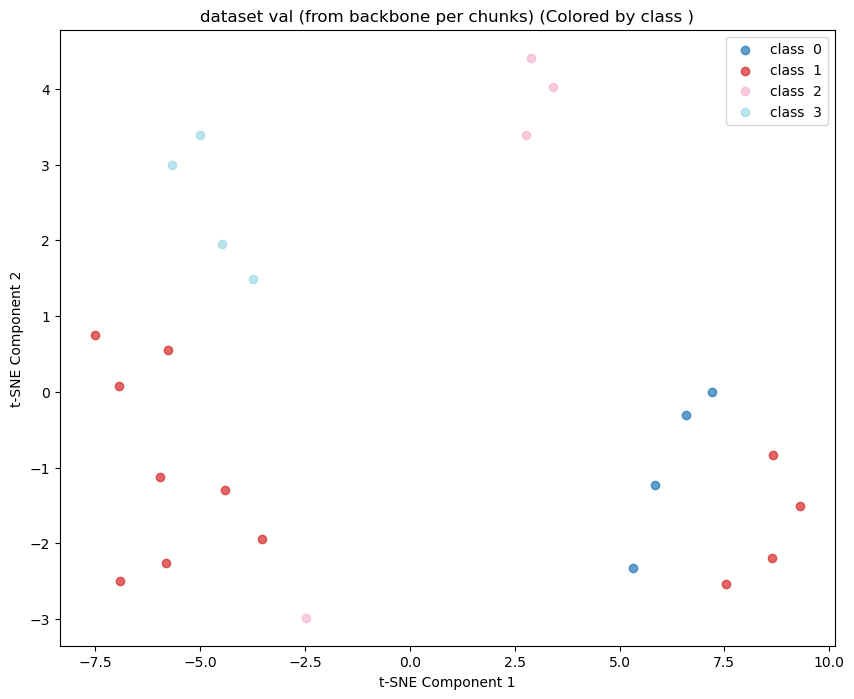

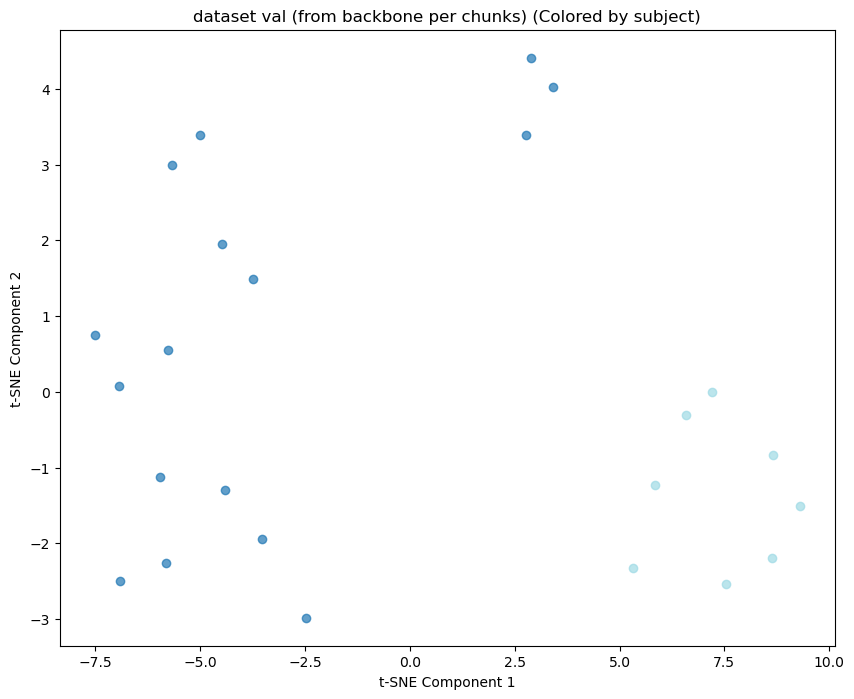

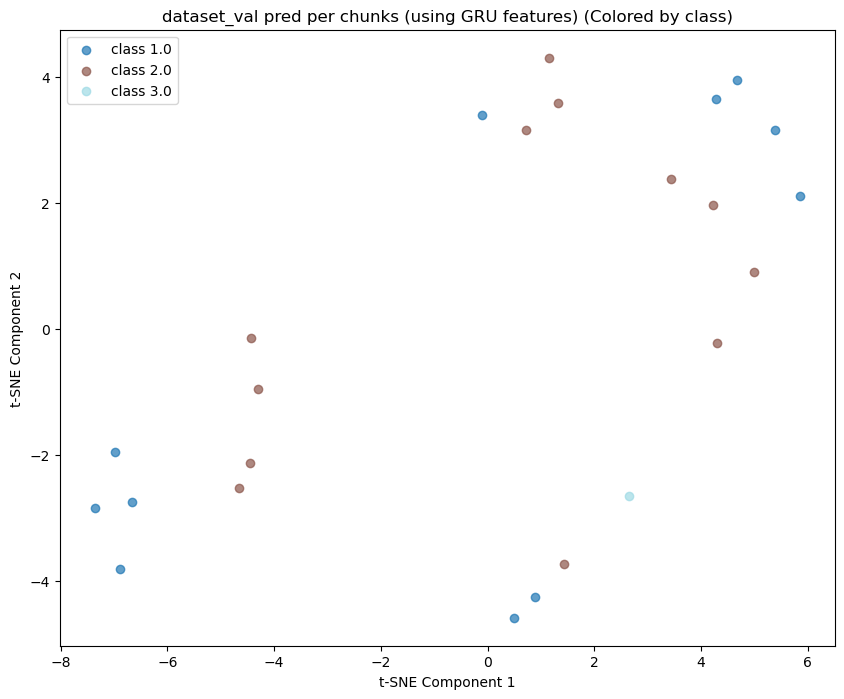

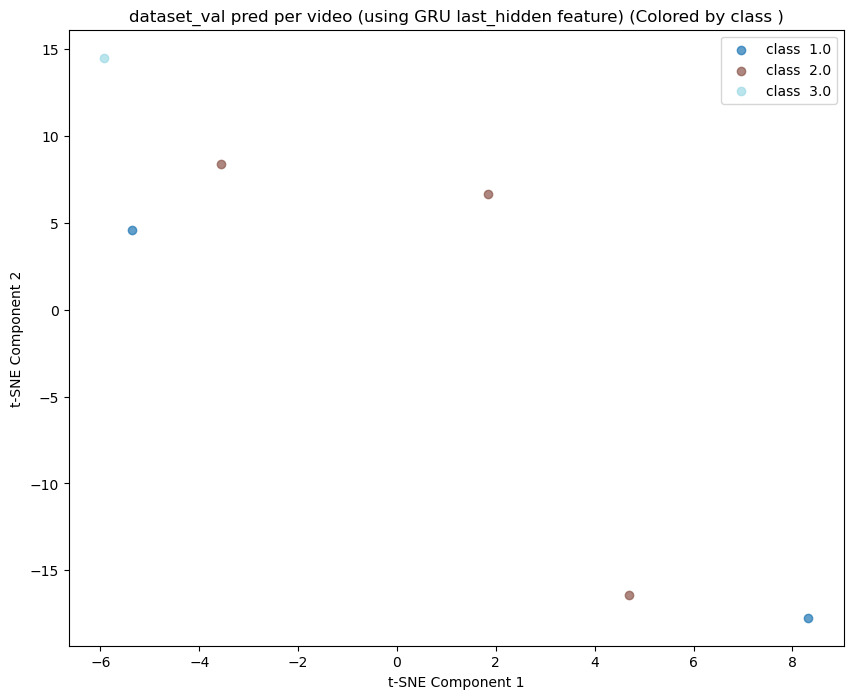

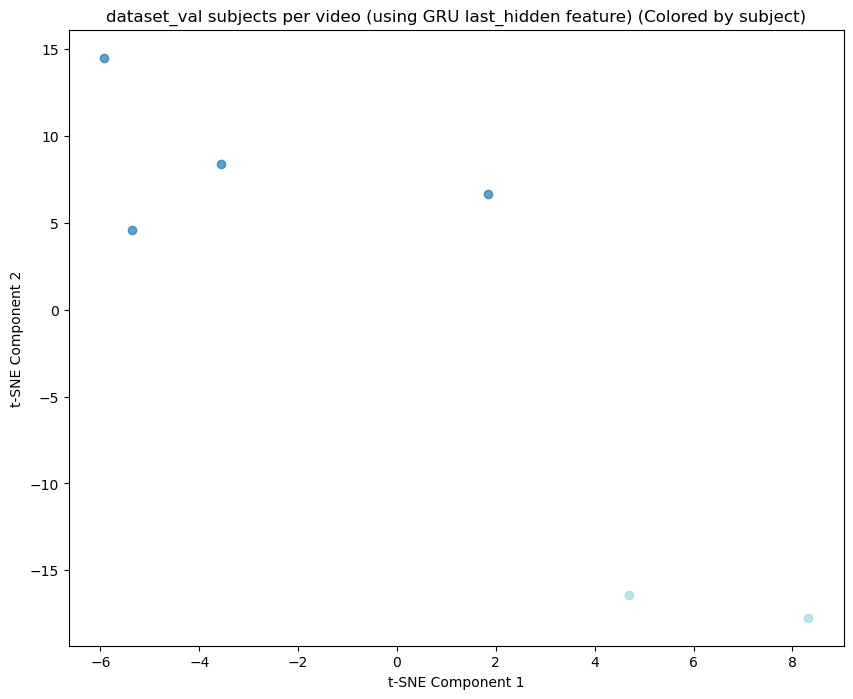

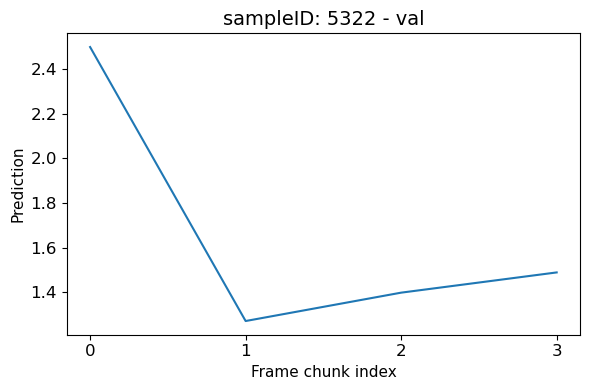

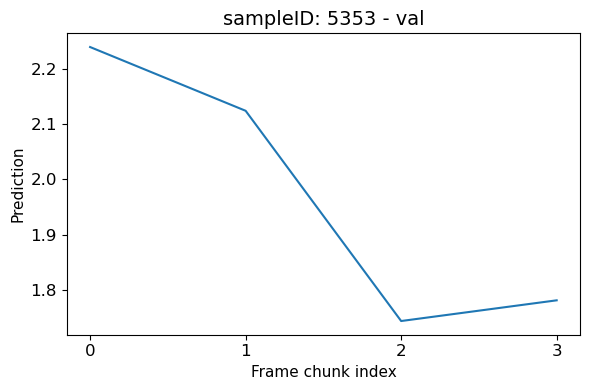

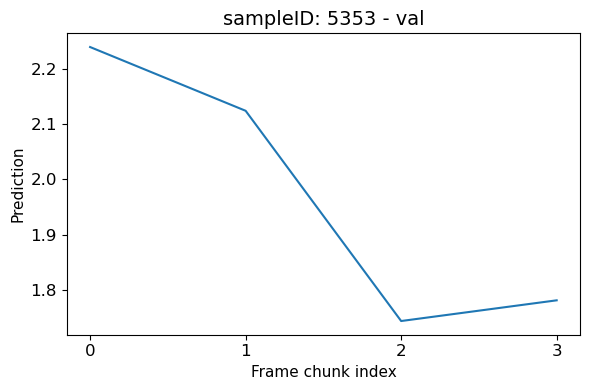

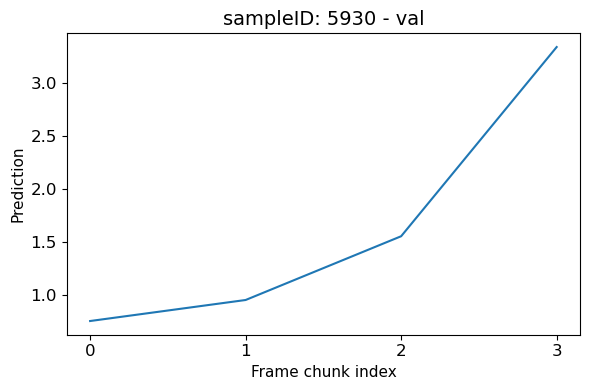

In [3]:
%load_ext autoreload
%autoreload 2
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time
import torch.nn as nn
import torch.optim as optim
import custom.scripts as scripts

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
# path_dict ={
#   'all' : os.path.join('partA','starting_point','samples.csv'),
  # 'train' : os.path.join('partA','starting_point','train_21.csv'),
  # 'val' : os.path.join('partA','starting_point','val_26.csv'),
  # 'test' : os.path.join('partA','starting_point','test_5.csv')
# }
path_dataset = os.path.join('partA','video','video')  
path_cvs_dataset = os.path.join('partA','starting_point','test_23.csv')
head = HEAD.GRU
# if head == 'GRU':
params = {
  'hidden_size': 1024,
  'num_layers': 1,
  'dropout': 0.0,
  'input_size': 384 * 8 # can be 384  (small), 768  (base), 1408  (large) [temporal_dim considered as input sequence for GRU]
                    # can be 384*8(small), 768*8(base), 1408*8(large) [temporal_dim considered feature in GRU] 
}

preprocess = AutoImageProcessor.from_pretrained(os.path.join("local_model_directory","preprocessor_config.json"))
stride_window_in_video = 40
model_advanced = scripts.run_train_test(model_type=model_type, 
                      pooling_embedding_reduction=pooling_embedding_reduction, 
                      pooling_clips_reduction=pooling_clips_reduction, 
                      sample_frame_strategy=sample_frame_strategy, 
                      path_csv_dataset=path_cvs_dataset, 
                      path_video_dataset=path_dataset,
                      head=head,
                      stride_window_in_video=stride_window_in_video, 
                      head_params=params,
                      preprocess=preprocess,
                      k_fold = 3,
                      epochs = 5,
                      train_size=0.8,
                      test_size=0.1,
                      val_size=0.1,
                      batch_size_training=2,
                      batch_size_feat_extraction=8,  
                      criterion = nn.L1Loss(),
                      optimizer_fn = optim.Adam,
                      lr = 0.0001,
                      random_state_split_dataset=42,
                      only_train=False,
                      is_save_features_extracted=False, 
                      is_validation=True,
                      is_plot_dataset_distribution=True,
                      is_plot_loss=True,
                      is_plot_tsne_backbone_feats=True,
                      is_plot_tsne_head_pred=True,
                      is_plot_tsne_gru_feats=True,
                      is_create_video_prediction=True,
                      is_create_video_prediction_per_video=True,
                      is_round_output_loss=False,
                      is_shuffle_training_batch=True,
                      is_shuffle_video_chunks=True,
                      is_download_if_unavailable=False
                      )

In [18]:
%autoreload 2
import custom.scripts as scripts

model_advanced.dataset.stride_window = 40
scripts.predict_per_video(
    path_csv='partA/starting_point/samples.csv',
    sample_ids=[10,35],
    model_advanced=model_advanced,
    root_folder_path='history_run/VIDEOMAE_v2_B_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733007378/train_GRU/video',
)

AttributeError: 'dict' object has no attribute 'dataset'

In [16]:
import os

def set_working_directory():
  target_dir = 'PainAssessmentVideo'
  current_dir = os.getcwd()
  if os.path.split(current_dir)[-1] != target_dir:
    while os.path.split(current_dir)[-1] != target_dir:
      current_dir = os.path.dirname(current_dir)
      if current_dir == os.path.dirname(current_dir):  # reached the root directory
        raise FileNotFoundError(f"{target_dir} not found in the directory tree. Please set PainAssessmentVideo as current working directory.")
    os.chdir(current_dir)
  print(f"Current working directory set to: {os.getcwd()}")

def create_folder(path):
  if not os.path.exists(path):
    os.makedirs(path)
    print(f'Folder created: {path}')
  else:
    print(f'Folder already exists: {path}')                                                                                       